In [ ]:
#### inserting the data in the mysql database.


In [1]:
SyntaxError: invalid character '—' (U+2014)


SyntaxError: invalid syntax (3222003250.py, line 1)

# Data Preprocessing for DrugBank Data

This notebook demonstrates how to extract drug data from MySQL, handle missing values, and perform basic data exploration.

## Steps:
1. **Extract Data**: Load drug data from the `DrugBank` MySQL database.
2. **Impute Missing Values**:  
   - Numeric columns: **median** imputation.  
   - Categorical columns: **'unknown'** imputation.
3. **Check Missing Data**: Verify if missing values remain.
4. **Critical Column Check**: Ensure key columns (e.g., `mechanism_of_action`) are complete.


In [7]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sqlalchemy import create_engine

# Step 1: Establish a connection to the database (use your connection details)
def connect_to_database():
    engine = create_engine('mysql+mysqlconnector://root:@localhost:3306/drugbank')
    return engine.connect()

# Example query to extract drug data (you can change this based on your needs)
drug_query = "SELECT * FROM drug;"  # Example query, modify as necessary

# Load data into pandas DataFrame
def load_data(query):
    connection = connect_to_database()
    df = pd.read_sql(query, connection)
    connection.close()
    return df

# Step 2: Load the data (Replace this with your actual SQL query if needed)
df = load_data(drug_query)

# Step 3: Check Data Types of All Columns
print("Data Types of All Columns:")
print(df.dtypes)

# Step 4: Identify Non-Numeric Columns
non_numeric_columns = df.select_dtypes(include=[object]).columns
print("\nNon-Numeric Columns:")
print(non_numeric_columns)

# Step 5: Identify Numeric Columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
print("\nNumeric Columns:")
print(numeric_columns)

# Step 6: Check for Missing Values
print("\nMissing Values Before Imputation:")
print(df.isna().sum())

# Step 7: Separate Imputation Process for Numeric and Non-Numeric Columns

# Impute Numeric Columns using Median (Strategy for numerical data)
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

# Impute Non-Numeric Columns using Constant (Strategy for categorical data)
categorical_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
df[non_numeric_columns] = categorical_imputer.fit_transform(df[non_numeric_columns])

# Step 8: Check if there are any NaN values left after imputation
print("\nMissing Values After Imputation:")
print(df.isna().sum())

# Step 9: Verify Data Completeness for Critical Columns
# Check for any remaining missing values in key columns (e.g., mechanism_of_action)
critical_columns = ['mechanism_of_action']  # Example; Add your critical columns here
for col in critical_columns:
    if col in df.columns:
        missing_values = df[col].isna().sum()
        print(f"\nMissing values in {col}: {missing_values}")

# Step 10: Print Sample Data to Review After Imputation
print("\nSample Data After Imputation:")
print(df.head())

# Step 11: If everything looks good, continue with further processing (e.g., PCA or feature engineering)
# Example: Apply PCA or any other processing you need
# from sklearn.decomposition import PCA
# pca = PCA(n_components=10)
# pca_features = pca.fit_transform(df[numeric_columns])


Data Types of All Columns:
drug_pk                     int64
primary_drugbank_id           str
name                          str
description                   str
cas_number                    str
unii                          str
average_mass              float64
monoisotopic_mass         float64
state                         str
synthesis_reference           str
indication                    str
pharmacodynamics              str
mechanism_of_action           str
toxicity                      str
metabolism                    str
absorption                    str
half_life                     str
protein_binding               str
route_of_elimination          str
volume_of_distribution        str
clearance                     str
fda_label                     str
msds                          str
dtype: object

Non-Numeric Columns:
Index(['primary_drugbank_id', 'name', 'description', 'cas_number', 'unii',
       'state', 'synthesis_reference', 'indication', 'pharmacodynamics',
       

C:\Users\niraj\AppData\Local\Temp\ipykernel_13032\294593911.py:29: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  non_numeric_columns = df.select_dtypes(include=[object]).columns


drug_pk                   0
primary_drugbank_id       0
name                      0
description               0
cas_number                0
unii                      0
average_mass              0
monoisotopic_mass         0
state                     0
synthesis_reference       0
indication                0
pharmacodynamics          0
mechanism_of_action       0
toxicity                  0
metabolism                0
absorption                0
half_life                 0
protein_binding           0
route_of_elimination      0
volume_of_distribution    0
clearance                 0
fda_label                 0
msds                      0
dtype: int64

Missing values in mechanism_of_action: 0

Sample Data After Imputation:
    drug_pk primary_drugbank_id           name  \
0  294749.0             DB00001      Lepirudin   
1  294750.0             DB01022  Phylloquinone   
2  294751.0             DB01373        Calcium   
3  294753.0             DB00002      Cetuximab   
4  294755.0         

# Data Preprocessing and Analysis Pipeline for DrugBank Data

This notebook demonstrates the full pipeline for data extraction, preprocessing, feature engineering, and class balancing for the DrugBank dataset. The steps include data extraction from MySQL, entity resolution, handling missing values, feature engineering with PCA, and balancing the dataset using SMOTE.

## Steps Involved:
1. **Database Extraction**
2. **Entity Resolution**
3. **Data Cleaning and Normalization**
4. **Categorical Standardization**
5. **DDI Label Definition and Dataset Construction**
6. **Feature Engineering (PCA)**
7. **Data Balancing Using SMOTE**

In [2]:
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import os
from tqdm import tqdm

# Database connection via SQLAlchemy
def connect_to_database():
    engine = create_engine('mysql+mysqlconnector://root:@localhost:3306/drugbank')
    return engine.connect()

# Extract data in chunks
def extract_data_in_chunks(query, chunk_size=10000):
    connection = connect_to_database()
    for chunk in pd.read_sql(query, connection, chunksize=chunk_size):
        yield chunk
    connection.close()

# Example queries to extract structured data
drug_query = "SELECT * FROM drug;"
interaction_query = "SELECT * FROM drug_interaction;"
pathway_query = "SELECT * FROM drug_pathway;"

# Step 1.2 — Entity Resolution and Consistent Identifiers
def resolve_entities(df):
    df['primary_drugbank_id'] = df['primary_drugbank_id'].str.upper()
    df = df.drop_duplicates(subset=['primary_drugbank_id'])
    return df

# Step 1.3 — Data Cleaning and Normalization
def clean_data(df):
    # Separate numeric and categorical columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    categorical_columns = df.select_dtypes(include=[object]).columns

    # Handle missing values for numeric columns (impute with median)
    imputer_numeric = SimpleImputer(strategy='median')  
    df[numeric_columns] = imputer_numeric.fit_transform(df[numeric_columns])

    # Handle missing values for categorical features (replace with mode or 'unknown')
    imputer_categorical = SimpleImputer(strategy='most_frequent')  
    df[categorical_columns] = imputer_categorical.fit_transform(df[categorical_columns])

    # Normalize text fields (lowercase, whitespace trimming)
    for col in categorical_columns:
        df[col] = df[col].str.lower().str.strip()  # Normalize text

    return df

# Step 1.4 — Categorical Standardization
def standardize_categories(df):
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    categorical_columns = ['category', 'mechanism_of_action']  # Update with relevant columns
    
    for col in categorical_columns:
        if col in df.columns:
            print(f"Encoding column: {col}")
            encoded_data = encoder.fit_transform(df[[col]])
            encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([col]))
            df = pd.concat([df, encoded_df], axis=1)
            df.drop(col, axis=1, inplace=True)

    return df

# Step 1.5 — DDI Label Definition and Dataset Construction
def construct_ddi_labels(df):
    output_dir = "D:/MyPhD/RP-5/out/stage-1/"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "final_ddi_labels.csv")
    
    # Creating negative samples
    num_negative_samples = min(len(df), 10000)
    negative_samples = df.sample(n=num_negative_samples, random_state=42)
    negative_samples['label'] = 0  # Non-interacting pairs

    # For positive samples, get drug interaction data (replace with actual logic)
    positive_samples = df[df['drug_pk'].isin(df['drug_pk'].unique())]
    positive_samples['label'] = 1  # Interacting pairs

    final_df = pd.concat([positive_samples, negative_samples], ignore_index=True)
    final_df.to_csv(output_path, index=False)

    return final_df

# Step 2 — Feature Engineering (PCA)
def feature_engineering(df):
    # Impute missing numeric values with the median
    imputer = SimpleImputer(strategy='median')
    numeric_features = df.select_dtypes(include=[np.number])

    numeric_features_imputed = imputer.fit_transform(numeric_features)

    # Apply PCA
    pca = PCA(n_components=10)  # Adjust components based on need
    pca_features = pca.fit_transform(numeric_features_imputed)

    # Convert PCA output to DataFrame
    pca_df = pd.DataFrame(pca_features, columns=[f"pca_{i+1}" for i in range(pca_features.shape[1])])
    df = pd.concat([df, pca_df], axis=1)

    return df

# Step 3 — Data Balance (Handling class imbalance)
def handle_data_imbalance(df):
    print("Class distribution before balancing:")
    print(df['label'].value_counts())

    # 🔴 STEP 1: Explicitly DROP identifier & text columns
    NON_FEATURE_COLUMNS = [
        'label',
        'primary_drugbank_id',
        'name',
        'description',
        'cas_number',
        'unii',
        'state',
        'synthesis_reference',
        'indication',
        'pharmacodynamics',
        'mechanism_of_action',
        'toxicity',
        'metabolism',
        'absorption',
        'half_life',
        'protein_binding',
        'route_of_elimination',
        'volume_of_distribution',
        'clearance',
        'fda_label',
        'msds'
    ]

    X = df.drop(columns=[c for c in NON_FEATURE_COLUMNS if c in df.columns])
    y = df['label']

    # 🔴 STEP 2: Keep ONLY numeric columns
    X = X.select_dtypes(include=[np.number])

    print("\nFinal features used for SMOTE:")
    print(X.columns.tolist())

    # 🔴 STEP 3: Safety check
    if X.isnull().sum().sum() > 0:
        print("There are still NaNs in the dataset, handling them now...")
        X = X.fillna(0)  # Fill missing values with 0

    assert X.isnull().sum().sum() == 0, "NaNs still present in numeric features"

    # 🔴 STEP 4: Apply SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    balanced_df = X_res.copy()
    balanced_df['label'] = y_res

    print("\nClass distribution after balancing:")
    print(balanced_df['label'].value_counts())

    return balanced_df

# Main function to execute everything
def main():
    print("Starting data extraction...")
    chunk_size = 10000
    all_drug_df = []

    # Step 1.1 — Extract Data in Chunks and Process Each Chunk
    for chunk in tqdm(extract_data_in_chunks(drug_query, chunk_size), desc="Extracting Drug Data"):
        chunk = resolve_entities(chunk)
        chunk = clean_data(chunk)
        chunk = standardize_categories(chunk)
        all_drug_df.append(chunk)  # Append processed chunk to the list

    # Combine all chunks and save to disk
    drug_df = pd.concat(all_drug_df, ignore_index=True)
    print("Data extraction and processing complete!")

    # Step 1.5 — DDI Label Construction
    print("Constructing DDI labels...")
    ddi_df = construct_ddi_labels(drug_df)
    print("DDI label construction complete!")

    # Step 2 — Feature Engineering (PCA)
    print("Applying PCA for feature engineering...")
    ddi_df = feature_engineering(ddi_df)

    # Step 3 — Data Balance (Handling class imbalance)
    print("Balancing data using SMOTE...")
    balanced_df = handle_data_imbalance(ddi_df)

    print("Data preprocessing, feature engineering, and balancing complete!")
    print(balanced_df.head())

if __name__ == "__main__":
    main()

Starting data extraction...


Extracting Drug Data: 0it [00:00, ?it/s]C:\Users\niraj\AppData\Local\Temp\ipykernel_4332\1865416140.py:39: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_columns = df.select_dtypes(include=[object]).columns


Encoding column: mechanism_of_action


Extracting Drug Data: 1it [00:02,  2.66s/it]C:\Users\niraj\AppData\Local\Temp\ipykernel_4332\1865416140.py:39: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_columns = df.select_dtypes(include=[object]).columns
Extracting Drug Data: 2it [00:03,  1.62s/it]

Encoding column: mechanism_of_action


Data extraction and processing complete!
Constructing DDI labels...


C:\Users\niraj\AppData\Local\Temp\ipykernel_4332\1865416140.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  negative_samples['label'] = 0  # Non-interacting pairs
C:\Users\niraj\AppData\Local\Temp\ipykernel_4332\1865416140.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  positive_samples['label'] = 1  # Interacting pairs


DDI label construction complete!
Applying PCA for feature engineering...
Balancing data using SMOTE...
Class distribution before balancing:
label
1    17430
0    10000
Name: count, dtype: int64

Final features used for SMOTE:
['drug_pk', 'average_mass', 'monoisotopic_mass', 'mechanism_of_action_* main mechanism of action involves  inhibition of nitric oxide synthase and guanylate cyclase. \r\n* in alzheimers disease: a mechanistic study found that methylene blue oxidizes cysteine sulfhydryl groups on tau to keep tau monomeric. one preclinical treatment study in tauopathy mice reported anti-inflammatory or neuroprotective effects mediated by the nrf2/antioxidant response element (are); another reported insoluble tau reduction and a learning and memory benefit when given early. \r\n* in methemoglobinemia: methylene blue acts by reacting within rbc to form leukomethylene blue, which is a reducing agent of oxidized hemoglobin converting the ferric ion (fe+++) back to its oxygen-carrying fe

#### DrugBank DDI Pairwise Pipeline

##### Overview
Creates a **pairwise drug dataset** for *placeholder* DDI modeling.

**Flow:** Extract → Clean → Drug Features → Pairwise → Scale + PCA → SMOTE

---

##### Config
- **DB:** `drugbank.drug`
- **Chunk:** 10k rows
- **Max pairs:** 2M
- **PCA:** 10 comps
- **Out:** `./out/`
- **Seed:** 42

---

##### Steps
**1. Extract & Clean**  
Chunked read, dedup by DrugBank ID, median/mode impute, lowercase text, OHE only `state`.

**2. Labels (placeholder)**  
Random pos/neg sampling  
→ `stage-1_ddi_labels.csv`

**3. Drug Features**  
TF-IDF (MoA), optional pathways, phys-chem fallback.

**4. Pairwise Features**  
`[Xi,Xj]`, `|Xi−Xj|`, `Xi×Xj`, pathway Jaccard.  
Label = `yi AND yj` (placeholder)  
→ `stage-2_pairwise.csv`

**5. Scale + PCA**  
StandardScaler → PCA(10)  
→ `stage-2_pairwise_pca.csv`

**6. Balance**  
SMOTE on PCA data  
→ `stage-3_balanced.csv`

---

##### Notes
Labels are **not true DDIs**.  
For publication: split first, fit scaler/PCA on train only, SMOTE on train only.


In [5]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sqlalchemy import create_engine
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# =========================
# CONFIG
# =========================
DB_URL = "mysql+mysqlconnector://root:@localhost:3306/drugbank"
drug_query = "SELECT * FROM drug;"
OUTPUT_DIR = "./out/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

CHUNK_SIZE = 10000
PCA_COMPONENTS = 10

# IMPORTANT:
# If you set this to None, it will try ALL pairs (may take months).
# Set to a number to cap runtime while keeping feature logic identical.
MAX_PAIRS = 2_000_000   # with 32GB, 1–5M is realistic; None means all pairs

RANDOM_SEED = 42

# =========================
# DATABASE HELPERS
# =========================
def connect_to_database():
    engine = create_engine(DB_URL)
    return engine.connect()

def extract_data_in_chunks(query, chunk_size=10000):
    con = connect_to_database()
    try:
        for chunk in pd.read_sql(query, con, chunksize=chunk_size):
            yield chunk
    finally:
        con.close()

def count_rows():
    con = connect_to_database()
    try:
        return int(pd.read_sql("SELECT COUNT(*) AS n FROM drug;", con)["n"].iloc[0])
    finally:
        con.close()

# =========================
# PHASE 1
# =========================
def resolve_entities(df):
    df = df.copy()
    if "primary_drugbank_id" in df.columns:
        df["primary_drugbank_id"] = df["primary_drugbank_id"].astype(str).str.upper()
        df = df.drop_duplicates(subset=["primary_drugbank_id"])
    return df

def clean_data(df):
    df = df.copy()

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    str_cols = df.select_dtypes(include=["object", "string"]).columns.tolist()

    if numeric_cols:
        imp_num = SimpleImputer(strategy="median")
        df[numeric_cols] = imp_num.fit_transform(df[numeric_cols])

    if str_cols:
        imp_str = SimpleImputer(strategy="most_frequent")
        df[str_cols] = imp_str.fit_transform(df[str_cols])
        for c in str_cols:
            df[c] = df[c].astype(str).str.lower().str.strip()

    return df

def standardize_categories(df):
    """
    Keep minimal OHE. Your previous code OHE-ed mechanism_of_action which you later need as text.
    We'll OHE only 'state' if present.
    """
    df = df.copy()
    cat_cols = [c for c in ["state"] if c in df.columns]
    if not cat_cols:
        return df

    enc = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
    enc_arr = enc.fit_transform(df[cat_cols])
    enc_df = pd.DataFrame(enc_arr, columns=enc.get_feature_names_out(cat_cols), index=df.index)

    df = pd.concat([df.drop(columns=cat_cols), enc_df], axis=1)
    return df

def construct_ddi_labels(df):
    """
    Keeps your pipeline flow.
    NOTE: This is still placeholder labeling logic.
    """
    df = df.copy()
    n = len(df)

    n_neg = min(n, 10000)
    neg = df.sample(n=n_neg, random_state=42).copy()
    neg["label"] = 0

    pos = df.sample(n=n_neg, random_state=99).copy()
    pos["label"] = 1

    out = pd.concat([pos, neg], ignore_index=True)
    out.to_csv(os.path.join(OUTPUT_DIR, "stage-1_ddi_labels.csv"), index=False)
    return out

# =========================
# PHASE 2: DRUG-LEVEL FEATURES
# =========================
def extract_moa_features(df):
    df = df.copy()
    if "mechanism_of_action" not in df.columns:
        df["mechanism_of_action"] = ""

    # TF-IDF on MOA
    tfidf = TfidfVectorizer(max_features=200, min_df=2)
    X = tfidf.fit_transform(df["mechanism_of_action"].fillna("").astype(str))
    moa_df = pd.DataFrame(X.toarray().astype(np.float32),
                          columns=[f"moa_tfidf_{i}" for i in range(X.shape[1])],
                          index=df.index)

    df = pd.concat([df, moa_df], axis=1)
    return df

def extract_pathway_features(df, pathways):
    """
    Your DRUG table doesn't contain 'pathway'. So keep logic but safe defaults.
    """
    df = df.copy()
    if "pathway" not in df.columns:
        for p in pathways:
            df[p] = 0
        return df

    df["pathway"] = df["pathway"].fillna("").astype(str)
    for p in pathways:
        df[p] = df["pathway"].str.contains(p, regex=False).astype(int)
    return df

def extract_physical_chemical_features(df):
    """
    Your DRUG table has average_mass and monoisotopic_mass, not molecular_weight.
    Keep molecular_weight placeholder for logic compatibility.
    """
    df = df.copy()
    if "molecular_weight" not in df.columns:
        df["molecular_weight"] = 0
    else:
        df["molecular_weight"] = pd.to_numeric(df["molecular_weight"], errors="coerce").fillna(0)
    return df

# =========================
# PHASE 2: PAIRWISE FEATURES (FAST, SAME LOGIC)
# =========================
def create_pairwise_features(df, max_pairs=None, seed=42):
    """
    Same pairwise logic:
    - concat(xi, xj)
    - abs(xi - xj)
    - xi * xj
    - Jaccard(pathway_i, pathway_j) (0 if missing)

    Optimization:
    - precompute numeric matrix
    - process in vectorized batches
    - optional cap max_pairs to control runtime
    """
    rng = np.random.default_rng(seed)

    if "label" not in df.columns:
        raise ValueError("label missing")

    # Numeric feature matrix
    X = df.drop(columns=["label"], errors="ignore")
    X_num = X.select_dtypes(include=[np.number]).fillna(0)
    cols = X_num.columns.tolist()
    Xv = X_num.to_numpy(dtype=np.float32)

    # pathway optional
    has_pathway = "pathway" in df.columns
    pathway = df["pathway"].fillna("").astype(str).to_numpy() if has_pathway else None

    n = len(df)
    total_pairs = n * (n - 1) // 2
    target_pairs = total_pairs if max_pairs is None else min(int(max_pairs), total_pairs)

    print(f"Total possible pairs: {total_pairs:,}")
    print(f"Pairs to generate:    {target_pairs:,}")

    # --------- Pair index generation ---------
    # If max_pairs is None, we must iterate all combinations (very slow for huge n).
    # If max_pairs provided, we sample random unique pairs i<j (same pairwise feature logic).
    if max_pairs is None:
        # All pairs (still huge)
        idx_i, idx_j = np.triu_indices(n, k=1)
        # no progress bar possible for giant arrays unless chunked
    else:
        pairs = set()
        with tqdm(total=target_pairs, desc="Sampling Pairs", unit="pair") as pbar:
            while len(pairs) < target_pairs:
                i = int(rng.integers(0, n))
                j = int(rng.integers(0, n))
                if i == j:
                    continue
                a, b = (i, j) if i < j else (j, i)
                if (a, b) in pairs:
                    continue
                pairs.add((a, b))
                pbar.update(1)
        pairs = np.array(list(pairs), dtype=np.int32)
        idx_i, idx_j = pairs[:, 0], pairs[:, 1]

    # --------- Feature ops in batches ---------
    batch = 200000  # 200k pairs per batch (good for 32GB)
    outputs = []

    with tqdm(total=len(idx_i), desc="Generating Pairwise Features", unit="pair") as pbar:
        for start in range(0, len(idx_i), batch):
            end = min(start + batch, len(idx_i))
            i_b = idx_i[start:end]
            j_b = idx_j[start:end]

            Xi = Xv[i_b]
            Xj = Xv[j_b]

            concat = np.concatenate([Xi, Xj], axis=1)
            absdiff = np.abs(Xi - Xj)
            prod = Xi * Xj

            # pathway jaccard (kept same, safe if missing)
            if has_pathway:
                shared = np.zeros(len(i_b), dtype=np.float32)
                for k in range(len(i_b)):
                    sa = set([x for x in pathway[i_b[k]].split(",") if x])
                    sb = set([x for x in pathway[j_b[k]].split(",") if x])
                    if not sa and not sb:
                        shared[k] = 0.0
                    else:
                        shared[k] = len(sa & sb) / len(sa | sb)
            else:
                shared = np.zeros(len(i_b), dtype=np.float32)

            col_concat = [f"a_{c}" for c in cols] + [f"b_{c}" for c in cols]
            col_abs = [f"abs_{c}" for c in cols]
            col_prod = [f"prod_{c}" for c in cols]

            df_batch = pd.DataFrame(concat, columns=col_concat)
            df_batch[col_abs] = absdiff
            df_batch[col_prod] = prod
            df_batch["shared_pathways"] = shared

            # Keep label flow: derive a pair label from endpoints (placeholder consistency)
            y = (df["label"].iloc[i_b].to_numpy() & df["label"].iloc[j_b].to_numpy()).astype(int)
            df_batch["label"] = y

            outputs.append(df_batch)
            pbar.update(end - start)

    return pd.concat(outputs, ignore_index=True)

# =========================
# PCA + SMOTE
# =========================
def scale_and_pca(df):
    df = df.copy()
    y = df["label"].values
    X = df.drop(columns=["label"], errors="ignore")

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    pca = PCA(n_components=PCA_COMPONENTS)
    Xp = pca.fit_transform(Xs)

    out = pd.DataFrame(Xp, columns=[f"pca_{i+1}" for i in range(PCA_COMPONENTS)])
    out["label"] = y
    return out

def handle_data_imbalance(df):
    df = df.copy()
    print("Class distribution before balancing:")
    print(df["label"].value_counts())

    y = df["label"]
    X = df.drop(columns=["label"], errors="ignore")

    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    out = pd.DataFrame(X_res, columns=X.columns)
    out["label"] = y_res

    print("Class distribution after balancing:")
    print(out["label"].value_counts())
    return out

# =========================
# MAIN
# =========================
def main():
    print("Starting data extraction...")
    total_rows = count_rows()
    print(f"Total rows in 'drug' table: {total_rows}")

    all_drug_df = []
    pbar = tqdm(total=total_rows, desc="Extracting Drug Data", unit="row")

    for chunk in extract_data_in_chunks(drug_query, CHUNK_SIZE):
        chunk = resolve_entities(chunk)
        chunk = clean_data(chunk)
        chunk = standardize_categories(chunk)
        all_drug_df.append(chunk)
        pbar.update(len(chunk))

    pbar.close()

    drug_df = pd.concat(all_drug_df, ignore_index=True)
    print("Data extraction and processing complete!", drug_df.shape)

    print("Constructing DDI labels...")
    ddi_df = construct_ddi_labels(drug_df)
    print("DDI label construction complete!", ddi_df.shape)

    print("Extracting drug-level features...")
    pathways = ["pathway_1", "pathway_2", "pathway_3"]
    ddi_df = extract_moa_features(ddi_df)
    ddi_df = extract_pathway_features(ddi_df, pathways)
    ddi_df = extract_physical_chemical_features(ddi_df)

    print("Generating pairwise features (FAST)...")
    pairwise_df = create_pairwise_features(ddi_df, max_pairs=MAX_PAIRS, seed=RANDOM_SEED)
    pairwise_path = os.path.join(OUTPUT_DIR, "stage-2_pairwise.csv")
    pairwise_df.to_csv(pairwise_path, index=False)
    print("Saved:", pairwise_path, pairwise_df.shape)

    print("Scaling and applying PCA...")
    pairwise_pca = scale_and_pca(pairwise_df)
    pca_path = os.path.join(OUTPUT_DIR, "stage-2_pairwise_pca.csv")
    pairwise_pca.to_csv(pca_path, index=False)
    print("Saved:", pca_path, pairwise_pca.shape)

    print("Balancing data using SMOTE...")
    balanced_df = handle_data_imbalance(pairwise_pca)
    bal_path = os.path.join(OUTPUT_DIR, "stage-3_balanced.csv")
    balanced_df.to_csv(bal_path, index=False)
    print("Saved:", bal_path, balanced_df.shape)

    print("DONE ✅")

if __name__ == "__main__":
    main()

Starting data extraction...
Total rows in 'drug' table: 17430


Extracting Drug Data: 100%|███████████████████████████████████████████████████| 17430/17430 [00:12<00:00, 1378.64row/s]


Data extraction and processing complete! (17430, 24)
Constructing DDI labels...
DDI label construction complete! (20000, 25)
Extracting drug-level features...
Generating pairwise features (FAST)...
Total possible pairs: 199,990,000
Pairs to generate:    2,000,000


Generating Pairwise Features:   0%|                                                      | 0/2000000 [00:00<?, ?pair/s]C:\Users\niraj\AppData\Local\Temp\ipykernel_4332\3377967879.py:257: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_batch[col_abs] = absdiff
C:\Users\niraj\AppData\Local\Temp\ipykernel_4332\3377967879.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_batch[col_prod] = prod
C:\Users\niraj\AppData\Local\Temp\ipykernel_4332\3377967879.py:259: PerformanceWarning: DataFrame is highly fragmented.  This is usua

Saved: ./out/stage-2_pairwise.csv (2000000, 838)
Scaling and applying PCA...
Saved: ./out/stage-2_pairwise_pca.csv (2000000, 11)
Balancing data using SMOTE...
Class distribution before balancing:
label
0    1500537
1     499463
Name: count, dtype: int64
Class distribution after balancing:
label
0    1500537
1    1500537
Name: count, dtype: int64
Saved: ./out/stage-3_balanced.csv (3001074, 11)
DONE ✅


#### Train–Test Safe ML Pipeline (PCA + SMOTE)

##### Overview
Trains and evaluates a classifier on **pairwise drug features** with **no data leakage**.

**Order:**  
Split → Scale (train only) → PCA (train only) → SMOTE (train only) → Train → Test

---

##### Input / Output
- **Input:** `stage-2_pairwise.csv`
- **Train:** `train_pca_smote.csv`
- **Test:** `test_pca.csv`

---

##### Config (Key)
- **Test size:** 20%
- **PCA:** 10 components
- **SMOTE:** Train only
- **Model:** Logistic Regression
- **Seed:** 42

---

##### Steps

**1. Load Data**  
Numeric features only, `label` as target.  
Check class distribution.

**2. Train/Test Split**  
Stratified split to preserve class balance.

**3. Scale + PCA (No Leakage)**  
- Fit `StandardScaler` on **train**
- Transform train + test  
- Fit `PCA` on **train**
- Transform train + test

**4. Balance (Train Only)**  
Apply **SMOTE** on PCA-transformed train set.

**5. Train Model**  
Logistic Regression trained on balanced train data.

**6. Evaluate (Test Only)**  
Metrics:
- ROC-AUC  
- PR-AUC  
- Accuracy  
- F1-score  
- Confusion Matrix  
- Classification Report

---

##### Notes
- Test set is **never** scaled, PCA-fitted, or SMOTE’d using test information.
- This pipeline is **publication-safe** and follows ML best practices.


In [7]:
import os
import numpy as np
import pandas as pd

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, f1_score, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# =========================
# CONFIG (your paths)
# =========================
PAIRWISE_CSV = r"./out/stage-2_pairwise.csv"
OUT_DIR = r"./out/"
os.makedirs(OUT_DIR, exist_ok=True)

TRAIN_PCA_SMOTE_CSV = os.path.join(OUT_DIR, "train_pca_smote.csv")
TEST_PCA_CSV        = os.path.join(OUT_DIR, "test_pca.csv")

TEST_SIZE = 0.20
RANDOM_STATE = 42
N_COMPONENTS = 10
USE_SMOTE = True
PCA_BATCH = 200_000   # progress-friendly chunk size for scaling/PCA

MODEL = LogisticRegression(
    max_iter=5000,
    n_jobs=-1,
    solver="lbfgs"
)

# =========================
# LOAD DATA (with row count first)
# =========================
print("Counting rows for progress bar...")
# Count rows without loading the full file into memory first
total_rows = sum(1 for _ in open(PAIRWISE_CSV, "r", encoding="utf-8")) - 1
print(f"Total rows in pairwise CSV: {total_rows:,}")

print("\nLoading pairwise dataset...")
df = pd.read_csv(PAIRWISE_CSV)
assert "label" in df.columns, "label column not found in pairwise dataset."

df["label"] = df["label"].astype(int)
X = df.drop(columns=["label"]).select_dtypes(include=[np.number]).astype(np.float32)
y = df["label"].values

print("Dataset shape:", X.shape, "Labels:", y.shape)
print("Class distribution (full):")
print(pd.Series(y).value_counts())

# =========================
# 1) TRAIN/TEST SPLIT FIRST (NO LEAKAGE)
# =========================
print("\n[1/6] Train/test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Split complete.")
print("Train label counts:", pd.Series(y_train).value_counts().to_dict())
print("Test label counts :", pd.Series(y_test).value_counts().to_dict())

# =========================
# 2) FIT SCALER ONLY ON TRAIN (with progress)
# =========================
print("\n[2/6] Fitting scaler on TRAIN only...")
scaler = StandardScaler(with_mean=True, with_std=True)

with tqdm(total=len(X_train), desc="Scaler fit (train)", unit="rows") as pbar:
    # StandardScaler doesn't support partial_fit reliably for all versions,
    # so we fit once, but still show a progress bar "simulated" by chunks.
    # This keeps correctness intact.
    scaler.fit(X_train)
    pbar.update(len(X_train))

print("[2/6] Scaling TRAIN and TEST...")
X_train_scaled = np.empty_like(X_train, dtype=np.float32)
X_test_scaled  = np.empty_like(X_test, dtype=np.float32)

with tqdm(total=len(X_train), desc="Scaling train", unit="rows") as pbar:
    for start in range(0, len(X_train), PCA_BATCH):
        end = min(start + PCA_BATCH, len(X_train))
        X_train_scaled[start:end] = scaler.transform(X_train.iloc[start:end])
        pbar.update(end - start)

with tqdm(total=len(X_test), desc="Scaling test", unit="rows") as pbar:
    for start in range(0, len(X_test), PCA_BATCH):
        end = min(start + PCA_BATCH, len(X_test))
        X_test_scaled[start:end] = scaler.transform(X_test.iloc[start:end])
        pbar.update(end - start)

# =========================
# 3) FIT PCA ONLY ON TRAIN; TRANSFORM TRAIN + TEST (with progress)
# =========================
print("\n[3/6] Fitting PCA on TRAIN only...")
pca = PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE)

with tqdm(total=len(X_train_scaled), desc="PCA fit (train)", unit="rows") as pbar:
    pca.fit(X_train_scaled)
    pbar.update(len(X_train_scaled))

print("[3/6] Transforming TRAIN and TEST...")
X_train_pca = np.empty((len(X_train_scaled), N_COMPONENTS), dtype=np.float32)
X_test_pca  = np.empty((len(X_test_scaled), N_COMPONENTS), dtype=np.float32)

with tqdm(total=len(X_train_scaled), desc="PCA transform train", unit="rows") as pbar:
    for start in range(0, len(X_train_scaled), PCA_BATCH):
        end = min(start + PCA_BATCH, len(X_train_scaled))
        X_train_pca[start:end] = pca.transform(X_train_scaled[start:end])
        pbar.update(end - start)

with tqdm(total=len(X_test_scaled), desc="PCA transform test", unit="rows") as pbar:
    for start in range(0, len(X_test_scaled), PCA_BATCH):
        end = min(start + PCA_BATCH, len(X_test_scaled))
        X_test_pca[start:end] = pca.transform(X_test_scaled[start:end])
        pbar.update(end - start)

print("\nPCA complete.")
print("Explained variance (sum):", float(np.sum(pca.explained_variance_ratio_)))

# =========================
# 4) APPLY SMOTE ONLY ON TRAIN (with progress)
# =========================
print("\n[4/6] SMOTE on TRAIN only...")
if USE_SMOTE:
    print("Before SMOTE:", pd.Series(y_train).value_counts().to_dict())
    smote = SMOTE(random_state=RANDOM_STATE)

    # SMOTE itself doesn't expose incremental progress; show a single-step bar
    with tqdm(total=1, desc="SMOTE fit_resample", unit="step") as pbar:
        X_train_final, y_train_final = smote.fit_resample(X_train_pca, y_train)
        pbar.update(1)

    print("After SMOTE :", pd.Series(y_train_final).value_counts().to_dict())
else:
    X_train_final, y_train_final = X_train_pca, y_train
    print("SMOTE skipped.")

# =========================
# Save leakage-free train/test (PCA already applied; SMOTE only train)
# =========================
print("\nSaving leakage-free datasets...")
with tqdm(total=2, desc="Saving CSVs", unit="file") as pbar:
    train_out = pd.DataFrame(X_train_final, columns=[f"pca_{i+1}" for i in range(N_COMPONENTS)])
    train_out["label"] = y_train_final
    train_out.to_csv(TRAIN_PCA_SMOTE_CSV, index=False)
    pbar.update(1)

    test_out = pd.DataFrame(X_test_pca, columns=[f"pca_{i+1}" for i in range(N_COMPONENTS)])
    test_out["label"] = y_test
    test_out.to_csv(TEST_PCA_CSV, index=False)
    pbar.update(1)

print("Saved:")
print(" -", TRAIN_PCA_SMOTE_CSV)
print(" -", TEST_PCA_CSV)

# =========================
# 5) TRAIN MODEL ON BALANCED TRAIN
# =========================
print("\n[5/6] Training model...")
with tqdm(total=1, desc="Model fit", unit="step") as pbar:
    MODEL.fit(X_train_final, y_train_final)
    pbar.update(1)

# =========================
# 6) EVALUATE ON UNTOUCHED TEST
# =========================
print("\n[6/6] Evaluating on untouched TEST...")
with tqdm(total=1, desc="Predict proba", unit="step") as pbar:
    y_proba = MODEL.predict_proba(X_test_pca)[:, 1]
    pbar.update(1)

y_pred = (y_proba >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc  = average_precision_score(y_test, y_proba)
acc     = accuracy_score(y_test, y_pred)
f1      = f1_score(y_test, y_pred)
cm      = confusion_matrix(y_test, y_pred)

print(f"\nROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC : {pr_auc:.4f}")
print(f"ACC    : {acc:.4f}")
print(f"F1     : {f1:.4f}")

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Counting rows for progress bar...
Total rows in pairwise CSV: 2,000,000

Loading pairwise dataset...
Dataset shape: (2000000, 837) Labels: (2000000,)
Class distribution (full):
0    1500537
1     499463
Name: count, dtype: int64

[1/6] Train/test split...
Split complete.
Train label counts: {0: 1200430, 1: 399570}
Test label counts : {0: 300107, 1: 99893}

[2/6] Fitting scaler on TRAIN only...


Scaler fit (train): 100%|███████████████████████████████████████████████| 1600000/1600000 [00:37<00:00, 42521.33rows/s]


[2/6] Scaling TRAIN and TEST...


Scaling test: 100%|██████████████████████████████████████████████████████| 400000/400000 [00:01<00:00, 225087.40rows/s]



[3/6] Fitting PCA on TRAIN only...


PCA fit (train): 100%|█████████████████████████████████████████████████| 1600000/1600000 [00:05<00:00, 276342.72rows/s]


[3/6] Transforming TRAIN and TEST...


PCA transform test: 100%|███████████████████████████████████████████████| 400000/400000 [00:00<00:00, 1061678.44rows/s]



PCA complete.
Explained variance (sum): 0.7330895066261292

[4/6] SMOTE on TRAIN only...
Before SMOTE: {0: 1200430, 1: 399570}


SMOTE fit_resample: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.30s/step]


After SMOTE : {0: 1200430, 1: 1200430}

Saving leakage-free datasets...


Saving CSVs: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:32<00:00, 16.40s/file]


Saved:
 - ./out/train_pca_smote.csv
 - ./out/test_pca.csv

[5/6] Training model...


Model fit:   0%|                                                                               | 0/1 [00:00<?, ?step/s]C:\Users\niraj\AppData\Roaming\Python\Python314\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
Model fit: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/step]



[6/6] Evaluating on untouched TEST...


Predict proba: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.71step/s]



ROC-AUC: 0.5071
PR-AUC : 0.2540
ACC    : 0.4664
F1     : 0.3519

Confusion Matrix:
[[128599 171508]
 [ 41941  57952]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7541    0.4285    0.5465    300107
           1     0.2526    0.5801    0.3519     99893

    accuracy                         0.4664    400000
   macro avg     0.5033    0.5043    0.4492    400000
weighted avg     0.6288    0.4664    0.4979    400000



In [ ]:
#### new

#### True-Label DDI Pipeline (Concise)

##### Goal  
Build a **scalable, leakage-free DDI model** using true DrugBank interactions.

---

##### Steps
1. **Positives (Chunked)**  
   `drug_interaction × drugbank_id_map` → canonical pairs, `label=1`

2. **Negatives (1:5)**  
   Random drug pairs, excluding positives → `label=0`  
   → `pairs_pos_neg_1to5.csv`

3. **Drug Features**  
   - Mass features (scaled)  
   - TF-IDF on mechanism of action  
   - Pathway aggregation

4. **Pairwise Features (Streamed)**  
   `[Xi,Xj]`, `|Xi−Xj|`, `Xi×Xj`, pathway Jaccard  
   → `stage-2_pairwise_true_labels.csv`

5. **ML (No Leakage)**  
   Split → Scale (train) → PCA (train) → SMOTE (train) → Logistic Regression

6. **Evaluation (Test Only)**  
   ROC-AUC, PR-AUC, Accuracy, F1, Confusion Matrix

---

##### Outputs
- Pair CSV  
- Pairwise feature CSV  
- `train_pca_smote.csv`  
- `test_pca.csv`

---

##### Note
Chunked loading + streaming ensure **memory safety** and **publication-grade correctness**.


In [5]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sqlalchemy import create_engine, text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, f1_score, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import IncrementalPCA

# =========================
# STREAMING LEAKAGE-FREE PIPELINE
# =========================
def leakage_free_train_eval_streaming(pairwise_csv: str,out_dir: str,test_size: float = 0.20,random_state: int = 42,
                                        n_components: int = 10,use_smote: bool = True, chunksize: int = 200_000, ipca_batch_size: int = 50_000):
    """
    Leakage-free + memory-safe pipeline:
    1) STREAM stratified split (train/test) from CSV -> writes train_raw.csv, test_raw.csv
    2) Fit StandardScaler on TRAIN only using partial_fit
    3) Fit IncrementalPCA on TRAIN only
    4) Transform TRAIN + TEST to PCA space (writes train_pca.csv, test_pca.csv)
    5) Load PCA train/test (small) -> SMOTE only on train -> train LR -> evaluate on test
    """

    os.makedirs(out_dir, exist_ok=True)
    train_raw_csv = os.path.join(out_dir, "train_raw.csv")
    test_raw_csv  = os.path.join(out_dir, "test_raw.csv")
    train_pca_csv = os.path.join(out_dir, "train_pca.csv")
    test_pca_csv  = os.path.join(out_dir, "test_pca.csv")

    # ---------- 0) count rows fast for progress ----------
    total_rows = sum(1 for _ in open(pairwise_csv, "r", encoding="utf-8")) - 1
    print(f"Total rows in pairwise CSV: {total_rows:,}")

    # ---------- 1) pass-1: count class totals (stream) ----------
    print("\n[Pass 1] Counting labels (stream)...")
    n0 = 0
    n1 = 0
    for chunk in tqdm(pd.read_csv(pairwise_csv, usecols=["label"], chunksize=chunksize),
                      total=(total_rows // chunksize) + 1,
                      desc="Counting labels", unit="chunk"):
        vc = chunk["label"].value_counts()
        n0 += int(vc.get(0, 0))
        n1 += int(vc.get(1, 0))

    print("Total label counts:", {0: n0, 1: n1})

    # desired test counts per class for stratification
    test0_target = int(round(n0 * test_size))
    test1_target = int(round(n1 * test_size))
    train0_target = n0 - test0_target
    train1_target = n1 - test1_target

    print("Target counts:")
    print("  Train:", {0: train0_target, 1: train1_target})
    print("  Test :", {0: test0_target, 1: test1_target})

    # reset files
    for f in [train_raw_csv, test_raw_csv, train_pca_csv, test_pca_csv]:
        if os.path.exists(f):
            os.remove(f)

    rng = np.random.default_rng(random_state)

    # ---------- 2) pass-2: stratified split streaming -> write raw train/test ----------
    print("\n[Pass 2] Writing stratified train/test raw files (stream)...")
    test0_used = 0
    test1_used = 0

    # we need all numeric cols; easiest: read full chunk and then numeric filter
    # but DO NOT load whole file
    chunk_iter = pd.read_csv(pairwise_csv, chunksize=chunksize)

    with tqdm(total=total_rows, desc="Streaming stratified split", unit="rows") as pbar:
        header_written_train = False
        header_written_test = False

        for chunk in chunk_iter:
            # keep numeric features only + label
            chunk["label"] = chunk["label"].astype(int)
            Xnum = chunk.select_dtypes(include=[np.number]).copy()

            # if label got dropped due to dtype issues, restore
            if "label" not in Xnum.columns:
                Xnum["label"] = chunk["label"].values

            # split indices by class
            idx0 = Xnum.index[Xnum["label"] == 0].to_numpy()
            idx1 = Xnum.index[Xnum["label"] == 1].to_numpy()

            # how many from this chunk can still go to test?
            need0 = max(0, test0_target - test0_used)
            need1 = max(0, test1_target - test1_used)

            # choose test indices (random) up to need
            test_idx = []
            if need0 > 0 and len(idx0) > 0:
                take0 = min(need0, len(idx0))
                test_idx.append(rng.choice(idx0, size=take0, replace=False))
                test0_used += take0

            if need1 > 0 and len(idx1) > 0:
                take1 = min(need1, len(idx1))
                test_idx.append(rng.choice(idx1, size=take1, replace=False))
                test1_used += take1

            test_idx = np.concatenate(test_idx) if len(test_idx) else np.array([], dtype=int)

            # create masks
            is_test = Xnum.index.isin(test_idx)
            df_test = Xnum.loc[is_test]
            df_train = Xnum.loc[~is_test]

            # append to CSV
            if len(df_train) > 0:
                df_train.to_csv(train_raw_csv, mode="a", index=False, header=not header_written_train)
                header_written_train = True

            if len(df_test) > 0:
                df_test.to_csv(test_raw_csv, mode="a", index=False, header=not header_written_test)
                header_written_test = True

            pbar.update(len(chunk))

    print("Stratified split done.")
    print("Test used:", {0: test0_used, 1: test1_used})

    # ---------- 3) Fit StandardScaler ONLY on TRAIN (partial_fit) ----------
    print("\n[Pass 3] Fitting StandardScaler on TRAIN only (partial_fit)...")
    scaler = StandardScaler(with_mean=True, with_std=True)

    # determine feature columns from train_raw header
    train_head = pd.read_csv(train_raw_csv, nrows=5)
    feat_cols = [c for c in train_head.columns if c != "label"]

    total_train_rows = sum(1 for _ in open(train_raw_csv, "r", encoding="utf-8")) - 1
    total_test_rows  = sum(1 for _ in open(test_raw_csv, "r", encoding="utf-8")) - 1
    print(f"Train raw rows: {total_train_rows:,} | Test raw rows: {total_test_rows:,}")

    for chunk in tqdm(pd.read_csv(train_raw_csv, chunksize=chunksize),
                      total=(total_train_rows // chunksize) + 1,
                      desc="Scaler partial_fit", unit="chunk"):
        Xc = chunk[feat_cols].to_numpy(dtype=np.float32)
        scaler.partial_fit(Xc)

    # ---------- 4) Fit IncrementalPCA ONLY on TRAIN ----------
    print("\n[Pass 4] Fitting IncrementalPCA on TRAIN only (partial_fit)...")
    ipca = IncrementalPCA(n_components=n_components, batch_size=ipca_batch_size)

    for chunk in tqdm(pd.read_csv(train_raw_csv, chunksize=chunksize),
                      total=(total_train_rows // chunksize) + 1,
                      desc="IPCA partial_fit", unit="chunk"):
        Xc = chunk[feat_cols].to_numpy(dtype=np.float32)
        Xc = scaler.transform(Xc)
        ipca.partial_fit(Xc)

    # ---------- 5) Transform TRAIN + TEST to PCA space (stream write) ----------
    def transform_to_pca(in_csv, out_csv, total_rows_in, desc):
        if os.path.exists(out_csv):
            os.remove(out_csv)

        header_written = False
        with tqdm(total=total_rows_in, desc=desc, unit="rows") as pbar:
            for chunk in pd.read_csv(in_csv, chunksize=chunksize):
                y = chunk["label"].astype(int).to_numpy()
                Xc = chunk[feat_cols].to_numpy(dtype=np.float32)
                Xc = scaler.transform(Xc)
                Xp = ipca.transform(Xc)

                out = pd.DataFrame(Xp, columns=[f"pca_{i+1}" for i in range(n_components)])
                out["label"] = y

                out.to_csv(out_csv, mode="a", index=False, header=not header_written)
                header_written = True
                pbar.update(len(chunk))

    print("\n[Pass 5] Transform TRAIN -> PCA and TEST -> PCA (stream)...")
    transform_to_pca(train_raw_csv, train_pca_csv, total_train_rows, "Transform train->PCA")
    transform_to_pca(test_raw_csv,  test_pca_csv,  total_test_rows,  "Transform test->PCA")

    print("Saved PCA datasets:")
    print(" -", train_pca_csv)
    print(" -", test_pca_csv)

    # ---------- 6) Load PCA datasets (small) + SMOTE only on TRAIN + train/eval ----------
    print("\n[Final] Loading PCA train/test into memory (small) ...")
    train_df = pd.read_csv(train_pca_csv)
    test_df  = pd.read_csv(test_pca_csv)

    X_train = train_df.drop(columns=["label"]).to_numpy(dtype=np.float32)
    y_train = train_df["label"].astype(int).to_numpy()
    X_test  = test_df.drop(columns=["label"]).to_numpy(dtype=np.float32)
    y_test  = test_df["label"].astype(int).to_numpy()

    print("PCA train shape:", X_train.shape, "PCA test shape:", X_test.shape)
    print("Train counts:", pd.Series(y_train).value_counts().to_dict())
    print("Test counts :", pd.Series(y_test).value_counts().to_dict())

    if use_smote:
        print("\nApplying SMOTE on TRAIN only...")
        smote = SMOTE(random_state=random_state)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print("After SMOTE train counts:", pd.Series(y_train).value_counts().to_dict())

    print("\nTraining Logistic Regression...")
    model = LogisticRegression(max_iter=5000, solver="lbfgs")
    model.fit(X_train, y_train)

    print("\nEvaluating on untouched TEST...")
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc  = average_precision_score(y_test, y_proba)
    acc     = accuracy_score(y_test, y_pred)
    f1      = f1_score(y_test, y_pred)
    cm      = confusion_matrix(y_test, y_pred)

    print(f"\nROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC : {pr_auc:.4f}")
    print(f"ACC    : {acc:.4f}")
    print(f"F1     : {f1:.4f}")
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

    return train_pca_csv, test_pca_csv

# =========================
# CONFIG
# =========================
DB_URL = "mysql+mysqlconnector://root:@localhost:3306/drugbank"

OUT_DIR = r"./out/"
os.makedirs(OUT_DIR, exist_ok=True)

PAIRS_CSV      = os.path.join(OUT_DIR, "pairs_pos_neg_1to5.csv")
PAIRWISE_CSV   = os.path.join(OUT_DIR, "stage-2_pairwise_true_labels.csv")
TRAIN_CSV      = os.path.join(OUT_DIR, "train_pca_smote.csv")
TEST_CSV       = os.path.join(OUT_DIR, "test_pca.csv")

NEG_RATIO = 5  # 1:5
TFIDF_MAX_FEATURES = 200
PCA_COMPONENTS = 10

PAIR_FEATURE_BATCH = 200_000
NEG_SAMPLING_CHUNK = 200_000
SQL_CHUNK_SIZE = 200_000

RANDOM_SEED = 42
TEST_SIZE = 0.20
USE_SMOTE = True

MODEL = LogisticRegression(max_iter=5000, solver="lbfgs")

# =========================
# DB HELPERS
# =========================
def get_engine():
    return create_engine(DB_URL)

def fast_count(engine, table_name: str) -> int:
    q = f"SELECT COUNT(*) AS n FROM {table_name};"
    return int(pd.read_sql(q, engine)["n"].iloc[0])

def read_sql_in_chunks(engine, query: str, total: int | None, desc: str, chunksize: int = 200_000) -> pd.DataFrame:
    """
    Reads a SQL query in chunks with a progress bar.
    total: row count for progress bar (use COUNT(*) for tables, or None if unknown).
    """
    chunks = []
    with engine.connect() as con:
        iterator = pd.read_sql(query, con, chunksize=chunksize)
        if total is None:
            # unknown total: still show progress without percentage
            for chunk in tqdm(iterator, desc=desc, unit="rows"):
                chunks.append(chunk)
        else:
            pbar = tqdm(total=total, desc=desc, unit="rows")
            for chunk in iterator:
                chunks.append(chunk)
                pbar.update(len(chunk))
            pbar.close()
    return pd.concat(chunks, ignore_index=True) if chunks else pd.DataFrame()

# =========================
# STEP A: LOAD TRUE POSITIVES (chunked)
# =========================
def load_positive_pairs_chunked(engine) -> pd.DataFrame:
    """
    Load positives from drug_interaction join drugbank_id_map in chunks with progress.
    Deduplicate into undirected canonical pairs.
    """
    # Fast counts for progress
    di_rows = fast_count(engine, "drug_interaction")
    print(f"drug_interaction rows (raw): {di_rows:,}")

    q = """
    SELECT di.drug_pk AS drug_pk_1,
           idm.drug_pk AS drug_pk_2
    FROM drug_interaction di
    JOIN drugbank_id_map idm
      ON idm.drugbank_id = di.interacting_drugbank_id
    WHERE di.drug_pk IS NOT NULL
      AND idm.drug_pk IS NOT NULL
      AND di.drug_pk <> idm.drug_pk
    """

    # We use di_rows as a reasonable total for progress (join may reduce some rows)
    pos_raw = read_sql_in_chunks(
        engine=engine,
        query=q,
        total=di_rows,
        desc="Loading positive interaction edges",
        chunksize=SQL_CHUNK_SIZE
    )

    if pos_raw.empty:
        raise ValueError("No positive interactions were loaded. Check drug_interaction and drugbank_id_map.")

    a = np.minimum(pos_raw["drug_pk_1"].values, pos_raw["drug_pk_2"].values)
    b = np.maximum(pos_raw["drug_pk_1"].values, pos_raw["drug_pk_2"].values)
    pos = pd.DataFrame({"drug_pk_1": a, "drug_pk_2": b}).drop_duplicates()
    pos["label"] = 1
    return pos

# =========================
# STEP B: NEGATIVE SAMPLING 1:5
# =========================
def sample_negative_pairs(drug_pks: np.ndarray, pos_set: set, n_neg: int, seed: int = 42) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    neg = set()

    with tqdm(total=n_neg, desc=f"Sampling negatives (1:{NEG_RATIO})", unit="pair") as pbar:
        while len(neg) < n_neg:
            u = rng.choice(drug_pks, size=NEG_SAMPLING_CHUNK, replace=True)
            v = rng.choice(drug_pks, size=NEG_SAMPLING_CHUNK, replace=True)

            for a, b in zip(u, v):
                if a == b:
                    continue
                x, y = (a, b) if a < b else (b, a)
                if (x, y) in pos_set or (x, y) in neg:
                    continue
                neg.add((x, y))
                pbar.update(1)
                if len(neg) >= n_neg:
                    break

    neg_df = pd.DataFrame(list(neg), columns=["drug_pk_1", "drug_pk_2"])
    neg_df["label"] = 0
    return neg_df

# =========================
# STEP C: DRUG-LEVEL FEATURES (chunked loads)
# =========================
def load_drug_table_chunked(engine) -> pd.DataFrame:
    drug_rows = fast_count(engine, "drug")
    print(f"drug rows: {drug_rows:,}")

    q = "SELECT drug_pk, average_mass, monoisotopic_mass, mechanism_of_action FROM drug"
    return read_sql_in_chunks(
        engine=engine,
        query=q,
        total=drug_rows,
        desc="Loading drug table",
        chunksize=SQL_CHUNK_SIZE
    )

def load_drug_pathways_chunked(engine) -> pd.DataFrame:
    dp_rows = fast_count(engine, "drug_pathway")
    print(f"drug_pathway rows: {dp_rows:,}")

    if dp_rows == 0:
        return pd.DataFrame({"drug_pk": [], "pathway": []})

    q = "SELECT drug_pk, smpdb_id FROM drug_pathway"
    dp = read_sql_in_chunks(
        engine=engine,
        query=q,
        total=dp_rows,
        desc="Loading drug_pathway table",
        chunksize=SQL_CHUNK_SIZE
    )

    # aggregate pathway IDs per drug_pk
    agg = dp.groupby("drug_pk")["smpdb_id"].apply(lambda s: ",".join(sorted(set(map(str, s)))))
    return agg.reset_index().rename(columns={"smpdb_id": "pathway"})

def build_drug_features(drug_df: pd.DataFrame, pathway_df: pd.DataFrame) -> pd.DataFrame:
    df = drug_df.copy()
    df = df.merge(pathway_df, on="drug_pk", how="left")
    df["pathway"] = df["pathway"].fillna("")

    for c in ["average_mass", "monoisotopic_mass"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df[["average_mass", "monoisotopic_mass"]] = df[["average_mass", "monoisotopic_mass"]].fillna(
        df[["average_mass", "monoisotopic_mass"]].median(numeric_only=True)
    )

    scaler = StandardScaler()
    df[["average_mass", "monoisotopic_mass"]] = scaler.fit_transform(df[["average_mass", "monoisotopic_mass"]])

    df["mechanism_of_action"] = df["mechanism_of_action"].fillna("").astype(str)
    tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, min_df=2)
    X_moa = tfidf.fit_transform(df["mechanism_of_action"])

    moa_cols = [f"moa_tfidf_{i}" for i in range(X_moa.shape[1])]
    moa_df = pd.DataFrame(X_moa.toarray().astype(np.float32), columns=moa_cols)

    df = pd.concat([df.reset_index(drop=True), moa_df], axis=1)

    feat_cols = ["average_mass", "monoisotopic_mass"] + moa_cols
    feats = df[["drug_pk", "pathway"] + feat_cols].set_index("drug_pk")
    return feats

# =========================
# STEP D: PAIRWISE FEATURES (stream to CSV)
# =========================
def jaccard_from_strings(a: str, b: str) -> float:
    sa = set([x for x in a.split(",") if x])
    sb = set([x for x in b.split(",") if x])
    if not sa and not sb:
        return 0.0
    return len(sa & sb) / len(sa | sb)

def build_pairwise_features_stream(pairs: pd.DataFrame, drug_feats: pd.DataFrame, out_csv: str, batch_size: int = 200_000):
    if os.path.exists(out_csv):
        os.remove(out_csv)

    pathway_series = drug_feats["pathway"]
    X_feats = drug_feats.drop(columns=["pathway"]).astype(np.float32)

    feat_names = X_feats.columns.tolist()
    col_concat = [f"a_{c}" for c in feat_names] + [f"b_{c}" for c in feat_names]
    col_abs = [f"abs_{c}" for c in feat_names]
    col_prod = [f"prod_{c}" for c in feat_names]

    total_pairs = len(pairs)

    with tqdm(total=total_pairs, desc="Building pairwise features", unit="pair") as pbar:
        for start in range(0, total_pairs, batch_size):
            end = min(start + batch_size, total_pairs)
            chunk = pairs.iloc[start:end]

            f1 = X_feats.loc[chunk["drug_pk_1"]].to_numpy()
            f2 = X_feats.loc[chunk["drug_pk_2"]].to_numpy()

            concat = np.concatenate([f1, f2], axis=1)
            absdiff = np.abs(f1 - f2)
            prod = f1 * f2

            p1 = pathway_series.loc[chunk["drug_pk_1"]].values
            p2 = pathway_series.loc[chunk["drug_pk_2"]].values
            shared = np.array([jaccard_from_strings(a, b) for a, b in zip(p1, p2)], dtype=np.float32)

            df_concat = pd.DataFrame(concat, columns=col_concat)
            df_abs = pd.DataFrame(absdiff, columns=col_abs)
            df_prod = pd.DataFrame(prod, columns=col_prod)

            out = pd.concat([chunk.reset_index(drop=True), df_concat, df_abs, df_prod], axis=1)
            out["shared_pathways"] = shared

            out.to_csv(out_csv, mode="a", index=False, header=(start == 0))
            pbar.update(end - start)

    print("Saved pairwise features:", out_csv)

# =========================
# STEP E: LEAKAGE-FREE ML PIPELINE (no leakage)
# =========================
def leakage_free_train_eval(pairwise_csv: str):
    print("\n=== Loading pairwise features for ML ===")

    # Count rows before load (fast)
    total_rows = sum(1 for _ in open(pairwise_csv, "r", encoding="utf-8")) - 1
    print(f"Total feature rows in CSV: {total_rows:,}")

    df = pd.read_csv(pairwise_csv)
    y = df["label"].astype(int).values
    X = df.drop(columns=["label"]).select_dtypes(include=[np.number]).astype(np.float32)

    print("X shape:", X.shape, "y shape:", y.shape)
    print("Full class counts:", pd.Series(y).value_counts().to_dict())

    print("\n[1/6] Train/test split...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
    )

    print("\n[2/6] Scaling (fit on train only)...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("\n[3/6] PCA (fit on train only)...")
    pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_SEED)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print("Explained variance (sum):", float(np.sum(pca.explained_variance_ratio_)))

    if USE_SMOTE:
        print("\n[4/6] SMOTE on TRAIN only...")
        smote = SMOTE(random_state=RANDOM_SEED)
        X_train_final, y_train_final = smote.fit_resample(X_train_pca, y_train)
    else:
        X_train_final, y_train_final = X_train_pca, y_train

    print("\nSaving leakage-free train/test...")
    train_out = pd.DataFrame(X_train_final, columns=[f"pca_{i+1}" for i in range(PCA_COMPONENTS)])
    train_out["label"] = y_train_final
    train_out.to_csv(TRAIN_CSV, index=False)

    test_out = pd.DataFrame(X_test_pca, columns=[f"pca_{i+1}" for i in range(PCA_COMPONENTS)])
    test_out["label"] = y_test
    test_out.to_csv(TEST_CSV, index=False)

    print("\n[5/6] Training Logistic Regression...")
    model = LogisticRegression(max_iter=5000, solver="lbfgs")
    model.fit(X_train_final, y_train_final)

    print("\n[6/6] Evaluating on untouched TEST...")
    y_proba = model.predict_proba(X_test_pca)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\nROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC : {pr_auc:.4f}")
    print(f"ACC    : {acc:.4f}")
    print(f"F1     : {f1:.4f}")
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# =========================
# MAIN
# =========================
def main():
    engine = get_engine()

    print("=== STEP 0: FAST counts for progress bars (instant) ===")
    n_drugs = fast_count(engine, "drug")
    n_dp = fast_count(engine, "drug_pathway")
    n_di = fast_count(engine, "drug_interaction")
    print(f"Total drugs: {n_drugs:,}")
    print(f"Total drug_pathway rows: {n_dp:,}")
    print(f"Total drug_interaction rows (raw): {n_di:,}")

    print("\n=== STEP 1: Load TRUE positive pairs (chunked + progress) ===")
    pos = load_positive_pairs_chunked(engine)
    pos_count = len(pos)
    print(f"Positive pairs (dedup): {pos_count:,}")

    n_neg = pos_count * NEG_RATIO
    total_pairs = pos_count + n_neg
    print(f"Negatives to sample (1:{NEG_RATIO}): {n_neg:,}")
    print(f"Total pairs for feature building: {total_pairs:,}")

    print("\n=== STEP 2: Load drug_pk list (fast) ===")
    drug_ids = pd.read_sql("SELECT drug_pk FROM drug", engine)["drug_pk"].astype(int).values

    pos_set = set(zip(pos["drug_pk_1"].values, pos["drug_pk_2"].values))

    print("\n=== STEP 3: Sample negatives (progress) ===")
    neg = sample_negative_pairs(drug_ids, pos_set, n_neg=n_neg, seed=RANDOM_SEED)

    pairs = pd.concat([pos, neg], ignore_index=True)
    pairs = pairs.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    pairs.to_csv(PAIRS_CSV, index=False)
    print("Saved pairs:", PAIRS_CSV)
    print("Pairs label counts:", pairs["label"].value_counts().to_dict())

    print("\n=== STEP 4: Load drug and pathway tables (chunked + progress) ===")
    drug_df = load_drug_table_chunked(engine)
    pathway_df = load_drug_pathways_chunked(engine)

    print("\n=== STEP 5: Build drug-level features ===")
    drug_feats = build_drug_features(drug_df, pathway_df)
    print("Drug feature table shape:", drug_feats.shape)

    print("\n=== STEP 6: Build pairwise features (stream + progress) ===")
    build_pairwise_features_stream(pairs, drug_feats, PAIRWISE_CSV, batch_size=PAIR_FEATURE_BATCH)

    print("\n=== STEP 7: Leakage-free ML pipeline ===")
    ## leakage_free_train_eval(PAIRWISE_CSV)
    leakage_free_train_eval_streaming(
        pairwise_csv=PAIRWISE_CSV,
        out_dir=OUT_DIR,
        test_size=TEST_SIZE,
        random_state=RANDOM_SEED,
        n_components=PCA_COMPONENTS,
        use_smote=USE_SMOTE,
        chunksize=200_000,
        ipca_batch_size=50_000
    )

if __name__ == "__main__":
    main()

=== STEP 0: FAST counts for progress bars (instant) ===
Total drugs: 17,430
Total drug_pathway rows: 3,780
Total drug_interaction rows (raw): 2,855,848

=== STEP 1: Load TRUE positive pairs (chunked + progress) ===
drug_interaction rows (raw): 2,855,848


Loading positive interaction edges: 100%|█████████████████████████████▉| 2855310/2855848 [00:20<00:00, 137637.18rows/s]


Positive pairs (dedup): 1,427,655
Negatives to sample (1:5): 7,138,275
Total pairs for feature building: 8,565,930

=== STEP 2: Load drug_pk list (fast) ===

=== STEP 3: Sample negatives (progress) ===


Sampling negatives (1:5): 100%|████████████████████████████████████████| 7138275/7138275 [00:23<00:00, 304331.68pair/s]


Saved pairs: ./out/pairs_pos_neg_1to5.csv
Pairs label counts: {0: 7138275, 1: 1427655}

=== STEP 4: Load drug and pathway tables (chunked + progress) ===
drug rows: 17,430


Loading drug table: 100%|███████████████████████████████████████████████████| 17430/17430 [00:00<00:00, 25526.89rows/s]


drug_pathway rows: 3,780


Loading drug_pathway table: 100%|██████████████████████████████████████████████| 3780/3780 [00:00<00:00, 8872.24rows/s]



=== STEP 5: Build drug-level features ===
Drug feature table shape: (17430, 203)

=== STEP 6: Build pairwise features (stream + progress) ===


Building pairwise features: 100%|██████████████████████████████████████| 8565930/8565930 [1:49:34<00:00, 1302.83pair/s]


Saved pairwise features: ./out/stage-2_pairwise_true_labels.csv

=== STEP 7: Leakage-free ML pipeline ===
Total rows in pairwise CSV: 8,565,930

[Pass 1] Counting labels (stream)...


Counting labels: 100%|██████████████████████████████████████████████████████████████| 43/43 [03:08<00:00,  4.38s/chunk]


Total label counts: {0: 7138275, 1: 1427655}
Target counts:
  Train: {0: 5710620, 1: 1142124}
  Test : {0: 1427655, 1: 285531}

[Pass 2] Writing stratified train/test raw files (stream)...


Streaming stratified split: 100%|██████████████████████████████████████| 8565930/8565930 [1:34:13<00:00, 1515.13rows/s]


Stratified split done.
Test used: {0: 1427655, 1: 285531}

[Pass 3] Fitting StandardScaler on TRAIN only (partial_fit)...
Train raw rows: 6,852,744 | Test raw rows: 1,713,186


Scaler partial_fit: 100%|███████████████████████████████████████████████████████████| 35/35 [22:50<00:00, 39.14s/chunk]



[Pass 4] Fitting IncrementalPCA on TRAIN only (partial_fit)...


IPCA partial_fit:  60%|████████████████████████████████████▌                        | 21/35 [22:52<15:14, 65.34s/chunk]


KeyboardInterrupt: 

In [6]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from sqlalchemy import create_engine

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, f1_score, confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE

# ==========================================================
# CONFIG
# ==========================================================
DB_URL = "mysql+mysqlconnector://root:@localhost:3306/drugbank"

OUT_DIR = "./output"
os.makedirs(OUT_DIR, exist_ok=True)

# Output artifacts
POS_PAIRS_CSV      = os.path.join(OUT_DIR, "pos_pairs.csv")
NEG_PAIRS_CSV      = os.path.join(OUT_DIR, "neg_pairs_1to5.csv")
PAIRS_CSV          = os.path.join(OUT_DIR, "pairs_pos_neg_1to5.csv")
PAIRWISE_FEATS_CSV = os.path.join(OUT_DIR, "stage-2_pairwise_true_labels.csv")

TRAIN_PCA_CSV      = os.path.join(OUT_DIR, "train_pca.csv")
TEST_PCA_CSV       = os.path.join(OUT_DIR, "test_pca.csv")
TRAIN_PCA_SMOTE_CSV= os.path.join(OUT_DIR, "train_pca_smote.csv")

# Ratio
NEG_RATIO = 5  # 1:5

# Chunking / performance
SQL_CHUNK = 200_000
NEG_SAMPLING_CHUNK = 200_000
PAIR_FEATURE_BATCH = 200_000

# Phase 2.4
TEST_SIZE = 0.20
RANDOM_SEED = 42
N_COMPONENTS = 10
IPCA_BATCH = 50_000
USE_SMOTE = True

# To keep runtime reasonable, you may cap total pairs (optional).
# None => full 1:5 dataset (can take hours + create huge files).
MAX_TOTAL_PAIRS = None  # e.g., 2_000_000 for faster runs

# ==========================================================
# OPTIONAL GPU DETECTION (best-effort)
# ==========================================================
GPU_AVAILABLE = False
try:
    import cupy as cp  # requires CUDA toolkit + matching CuPy build
    GPU_AVAILABLE = True
except Exception:
    GPU_AVAILABLE = False

# ==========================================================
# DB helpers
# ==========================================================
def engine():
    return create_engine(DB_URL)

def sql_count(eng, table):
    return int(pd.read_sql(f"SELECT COUNT(*) AS n FROM {table};", eng)["n"].iloc[0])

def read_sql_chunks(eng, query, total_rows=None, desc="SQL read", chunksize=200_000):
    """
    Chunked SQL read with a progress bar.
    total_rows is used to set tqdm total. If None, tqdm runs without percentage.
    """
    chunks = []
    with eng.connect() as con:
        it = pd.read_sql(query, con, chunksize=chunksize)
        if total_rows is None:
            for c in tqdm(it, desc=desc, unit="rows"):
                chunks.append(c)
        else:
            pbar = tqdm(total=total_rows, desc=desc, unit="rows")
            for c in it:
                chunks.append(c)
                pbar.update(len(c))
            pbar.close()
    if not chunks:
        return pd.DataFrame()
    return pd.concat(chunks, ignore_index=True)

# ==========================================================
# STATUS helper
# ==========================================================
def status(msg):
    print(f"\n✅ {msg}")

# ==========================================================
# STEP 0: fast counts (no heavy GROUP BY)
# ==========================================================
def step0_counts(eng):
    status("STEP 0: Fast counts (MySQL COUNT(*))")
    n_drug = sql_count(eng, "drug")
    n_dp   = sql_count(eng, "drug_pathway")
    n_di   = sql_count(eng, "drug_interaction")
    n_map  = sql_count(eng, "drugbank_id_map")

    print(f"Total drugs: {n_drug:,}")
    print(f"drug_pathway rows: {n_dp:,}")
    print(f"drug_interaction rows: {n_di:,}")
    print(f"drugbank_id_map rows: {n_map:,}")
    return n_drug, n_dp, n_di, n_map

# ==========================================================
# STEP 1: load positives from MySQL (chunked), dedup undirected pairs
# ==========================================================
def step1_load_positive_pairs(eng, di_rows):
    status("STEP 1: Loading TRUE positive interaction pairs (chunked)")

    q = """
    SELECT di.drug_pk AS drug_pk_1,
           idm.drug_pk AS drug_pk_2
    FROM drug_interaction di
    JOIN drugbank_id_map idm
      ON idm.drugbank_id = di.interacting_drugbank_id
    WHERE di.drug_pk IS NOT NULL
      AND idm.drug_pk IS NOT NULL
      AND di.drug_pk <> idm.drug_pk
    """

    pos_raw = read_sql_chunks(
        eng, q,
        total_rows=di_rows,
        desc="Loading positive interaction edges",
        chunksize=SQL_CHUNK
    )
    if pos_raw.empty:
        raise RuntimeError("No positive pairs loaded. Check data consistency.")

    a = np.minimum(pos_raw["drug_pk_1"].values, pos_raw["drug_pk_2"].values)
    b = np.maximum(pos_raw["drug_pk_1"].values, pos_raw["drug_pk_2"].values)

    pos = pd.DataFrame({"drug_pk_1": a, "drug_pk_2": b}).drop_duplicates()
    pos["label"] = 1

    pos.to_csv(POS_PAIRS_CSV, index=False)
    print(f"Positive pairs (dedup): {len(pos):,}")
    print(f"Saved: {POS_PAIRS_CSV}")
    return pos

# ==========================================================
# STEP 2: sample negatives 1:5 without DB writes
# ==========================================================
def step2_sample_negatives(eng, pos, n_drug):
    status("STEP 2: Sampling NEGATIVE pairs (1:5)")

    # Load drug ids (fast)
    drug_ids = pd.read_sql("SELECT drug_pk FROM drug;", eng)["drug_pk"].astype(np.int64).values

    pos_set = set(zip(pos["drug_pk_1"].values, pos["drug_pk_2"].values))

    n_neg_target = len(pos) * NEG_RATIO
    if MAX_TOTAL_PAIRS is not None:
        # cap total pairs => cap negatives too (keep 1:5 ratio)
        max_pos = min(len(pos), MAX_TOTAL_PAIRS // (1 + NEG_RATIO))
        n_neg_target = max_pos * NEG_RATIO
        pos = pos.sample(n=max_pos, random_state=RANDOM_SEED).reset_index(drop=True)
        pos_set = set(zip(pos["drug_pk_1"].values, pos["drug_pk_2"].values))
        print(f"⚠️ MAX_TOTAL_PAIRS active. Using pos={len(pos):,} neg={n_neg_target:,}")

    rng = np.random.default_rng(RANDOM_SEED)
    neg = set()

    with tqdm(total=n_neg_target, desc=f"Sampling negatives (1:{NEG_RATIO})", unit="pair") as pbar:
        while len(neg) < n_neg_target:
            u = rng.choice(drug_ids, size=NEG_SAMPLING_CHUNK, replace=True)
            v = rng.choice(drug_ids, size=NEG_SAMPLING_CHUNK, replace=True)

            for a, b in zip(u, v):
                if a == b:
                    continue
                x, y = (a, b) if a < b else (b, a)
                if (x, y) in pos_set or (x, y) in neg:
                    continue
                neg.add((x, y))
                pbar.update(1)
                if len(neg) >= n_neg_target:
                    break

    neg_df = pd.DataFrame(list(neg), columns=["drug_pk_1", "drug_pk_2"])
    neg_df["label"] = 0

    neg_df.to_csv(NEG_PAIRS_CSV, index=False)
    print(f"Negative pairs: {len(neg_df):,}")
    print(f"Saved: {NEG_PAIRS_CSV}")

    pairs = pd.concat([pos, neg_df], ignore_index=True)
    pairs = pairs.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    pairs.to_csv(PAIRS_CSV, index=False)
    print(f"Total pairs: {len(pairs):,}")
    print(f"Saved: {PAIRS_CSV}")
    print("Label counts:", pairs["label"].value_counts().to_dict())
    return pairs

# ==========================================================
# STEP 3: load drug table + pathways from MySQL (chunked) and build drug-level features
# ==========================================================
def step3_build_drug_features(eng, n_drug, n_dp):
    status("STEP 3: Building drug-level features (MySQL → TF-IDF + numeric + pathways)")

    drug_q = "SELECT drug_pk, average_mass, monoisotopic_mass, mechanism_of_action FROM drug;"
    drug_df = read_sql_chunks(eng, drug_q, total_rows=n_drug, desc="Loading drug table", chunksize=SQL_CHUNK)
    if drug_df.empty:
        raise RuntimeError("drug table read returned empty.")

    # pathways
    if n_dp > 0:
        dp_q = "SELECT drug_pk, smpdb_id FROM drug_pathway;"
        dp_df = read_sql_chunks(eng, dp_q, total_rows=n_dp, desc="Loading drug_pathway", chunksize=SQL_CHUNK)
        agg = dp_df.groupby("drug_pk")["smpdb_id"].apply(lambda s: ",".join(sorted(set(map(str, s)))))
        pathway_df = agg.reset_index().rename(columns={"smpdb_id": "pathway"})
    else:
        pathway_df = pd.DataFrame({"drug_pk": [], "pathway": []})

    df = drug_df.merge(pathway_df, on="drug_pk", how="left")
    df["pathway"] = df["pathway"].fillna("")
    df["mechanism_of_action"] = df["mechanism_of_action"].fillna("").astype(str)

    # numeric
    for c in ["average_mass", "monoisotopic_mass"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df[["average_mass", "monoisotopic_mass"]] = df[["average_mass", "monoisotopic_mass"]].fillna(
        df[["average_mass", "monoisotopic_mass"]].median(numeric_only=True)
    )
    scaler_num = StandardScaler()
    df[["average_mass", "monoisotopic_mass"]] = scaler_num.fit_transform(df[["average_mass", "monoisotopic_mass"]])

    # TF-IDF (CPU — sklearn is CPU)
    tfidf = TfidfVectorizer(max_features=200, min_df=2)
    X_moa = tfidf.fit_transform(df["mechanism_of_action"])
    moa_cols = [f"moa_tfidf_{i}" for i in range(X_moa.shape[1])]
    moa_df = pd.DataFrame(X_moa.toarray().astype(np.float32), columns=moa_cols)

    df = pd.concat([df.reset_index(drop=True), moa_df], axis=1)

    feat_cols = ["average_mass", "monoisotopic_mass"] + moa_cols
    drug_feats = df[["drug_pk", "pathway"] + feat_cols].set_index("drug_pk")

    print("Drug feature table shape:", drug_feats.shape)
    return drug_feats

# ==========================================================
# STEP 4: build pairwise features (stream to CSV) with progress bar
# ==========================================================
def jaccard_from_strings(a: str, b: str) -> float:
    sa = set([x for x in a.split(",") if x])
    sb = set([x for x in b.split(",") if x])
    if not sa and not sb:
        return 0.0
    return len(sa & sb) / len(sa | sb)

def step4_build_pairwise_features(pairs, drug_feats):
    status("STEP 4: Building pairwise features (concat + absdiff + product + pathway Jaccard)")

    if os.path.exists(PAIRWISE_FEATS_CSV):
        os.remove(PAIRWISE_FEATS_CSV)

    pathway_series = drug_feats["pathway"]
    X_feats = drug_feats.drop(columns=["pathway"]).astype(np.float32)

    feat_names = X_feats.columns.tolist()
    col_concat = [f"a_{c}" for c in feat_names] + [f"b_{c}" for c in feat_names]
    col_abs = [f"abs_{c}" for c in feat_names]
    col_prod = [f"prod_{c}" for c in feat_names]

    total = len(pairs)

    with tqdm(total=total, desc="Building pairwise features", unit="pair") as pbar:
        for start in range(0, total, PAIR_FEATURE_BATCH):
            end = min(start + PAIR_FEATURE_BATCH, total)
            chunk = pairs.iloc[start:end]

            f1 = X_feats.loc[chunk["drug_pk_1"]].to_numpy()
            f2 = X_feats.loc[chunk["drug_pk_2"]].to_numpy()

            concat = np.concatenate([f1, f2], axis=1)
            absdiff = np.abs(f1 - f2)
            prod = f1 * f2

            p1 = pathway_series.loc[chunk["drug_pk_1"]].values
            p2 = pathway_series.loc[chunk["drug_pk_2"]].values
            shared = np.array([jaccard_from_strings(a, b) for a, b in zip(p1, p2)], dtype=np.float32)

            df_concat = pd.DataFrame(concat, columns=col_concat)
            df_abs = pd.DataFrame(absdiff, columns=col_abs)
            df_prod = pd.DataFrame(prod, columns=col_prod)

            out = pd.concat([chunk.reset_index(drop=True), df_concat, df_abs, df_prod], axis=1)
            out["shared_pathways"] = shared

            out.to_csv(PAIRWISE_FEATS_CSV, mode="a", index=False, header=(start == 0))
            pbar.update(end - start)

    print("Saved:", PAIRWISE_FEATS_CSV)

# ==========================================================
# STEP 5: Phase 2.4 leakage-free scaling + IPCA + SMOTE (CPU) with progress
# ==========================================================
def count_rows_fast(path, buf=8*1024*1024):
    n = 0
    with open(path, "rb") as f:
        while True:
            b = f.read(buf)
            if not b:
                break
            n += b.count(b"\n")
    return max(0, n - 1)

def is_test_row(row_idx: int, test_size: float, seed: int) -> bool:
    x = (row_idx * 1103515245 + seed) & 0xFFFFFFFF
    r = (x / 2**32)
    return r < test_size

def step5_phase24(pairwise_csv):
    status("STEP 5: Phase 2.4 (leakage-free scaling + IPCA + SMOTE + train/eval)")

    total_rows = count_rows_fast(pairwise_csv)
    print(f"Total rows in pairwise CSV: {total_rows:,}")

    # detect numeric features quickly
    head = pd.read_csv(pairwise_csv, nrows=5)
    feat_cols = head.drop(columns=["label"]).select_dtypes(include=[np.number]).columns.tolist()
    if not feat_cols:
        raise RuntimeError("No numeric feature columns found in pairwise CSV.")
    print(f"Numeric feature columns: {len(feat_cols)}")

    scaler = StandardScaler()
    ipca = IncrementalPCA(n_components=N_COMPONENTS, batch_size=IPCA_BATCH)

    # PASS 1: scaler.partial_fit on TRAIN only
    processed = 0
    row_offset = 0
    with tqdm(total=total_rows, desc="Pass 1/3: scaler.partial_fit (train)", unit="rows") as pbar:
        for chunk in pd.read_csv(pairwise_csv, usecols=feat_cols + ["label"], chunksize=SQL_CHUNK):
            n = len(chunk)
            idx = np.arange(row_offset, row_offset + n, dtype=np.int64)
            train_mask = np.array([not is_test_row(i, TEST_SIZE, RANDOM_SEED) for i in idx], dtype=bool)
            Xtr = chunk.loc[train_mask, feat_cols].to_numpy(dtype=np.float32)
            if len(Xtr) > 0:
                scaler.partial_fit(Xtr)
            row_offset += n
            processed += n
            pbar.update(n)

    # PASS 2: ipca.partial_fit on TRAIN only
    processed = 0
    row_offset = 0
    with tqdm(total=total_rows, desc="Pass 2/3: ipca.partial_fit (train)", unit="rows") as pbar:
        for chunk in pd.read_csv(pairwise_csv, usecols=feat_cols + ["label"], chunksize=SQL_CHUNK):
            n = len(chunk)
            idx = np.arange(row_offset, row_offset + n, dtype=np.int64)
            train_mask = np.array([not is_test_row(i, TEST_SIZE, RANDOM_SEED) for i in idx], dtype=bool)
            Xtr = chunk.loc[train_mask, feat_cols].to_numpy(dtype=np.float32)
            if len(Xtr) > 0:
                Xtr = scaler.transform(Xtr)
                ipca.partial_fit(Xtr)
            row_offset += n
            processed += n
            pbar.update(n)

    # PASS 3: transform train/test -> write PCA csvs
    for f in [TRAIN_PCA_CSV, TEST_PCA_CSV]:
        if os.path.exists(f):
            os.remove(f)

    row_offset = 0
    train_header = False
    test_header = False

    with tqdm(total=total_rows, desc="Pass 3/3: transform + write PCA", unit="rows") as pbar:
        for chunk in pd.read_csv(pairwise_csv, usecols=feat_cols + ["label"], chunksize=SQL_CHUNK):
            n = len(chunk)
            y = chunk["label"].astype(int).to_numpy()
            X = chunk[feat_cols].to_numpy(dtype=np.float32)

            idx = np.arange(row_offset, row_offset + n, dtype=np.int64)
            test_mask = np.array([is_test_row(i, TEST_SIZE, RANDOM_SEED) for i in idx], dtype=bool)
            train_mask = ~test_mask

            if np.any(train_mask):
                Xt = scaler.transform(X[train_mask])
                Xp = ipca.transform(Xt)
                out = pd.DataFrame(Xp, columns=[f"pca_{i+1}" for i in range(N_COMPONENTS)])
                out["label"] = y[train_mask]
                out.to_csv(TRAIN_PCA_CSV, mode="a", index=False, header=not train_header)
                train_header = True

            if np.any(test_mask):
                Xt = scaler.transform(X[test_mask])
                Xp = ipca.transform(Xt)
                out = pd.DataFrame(Xp, columns=[f"pca_{i+1}" for i in range(N_COMPONENTS)])
                out["label"] = y[test_mask]
                out.to_csv(TEST_PCA_CSV, mode="a", index=False, header=not test_header)
                test_header = True

            row_offset += n
            pbar.update(n)

    print("Saved:", TRAIN_PCA_CSV)
    print("Saved:", TEST_PCA_CSV)

    # load PCA train/test (small)
    train_df = pd.read_csv(TRAIN_PCA_CSV)
    test_df = pd.read_csv(TEST_PCA_CSV)

    X_train = train_df.drop(columns=["label"]).to_numpy(dtype=np.float32)
    y_train = train_df["label"].astype(int).to_numpy()
    X_test = test_df.drop(columns=["label"]).to_numpy(dtype=np.float32)
    y_test = test_df["label"].astype(int).to_numpy()

    print("Train/Test PCA shapes:", X_train.shape, X_test.shape)
    print("Test counts:", pd.Series(y_test).value_counts().to_dict())

    if USE_SMOTE:
        sm = SMOTE(random_state=RANDOM_SEED)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        pd.DataFrame(X_train, columns=[f"pca_{i+1}" for i in range(N_COMPONENTS)]).assign(label=y_train)\
            .to_csv(TRAIN_PCA_SMOTE_CSV, index=False)
        print("Saved:", TRAIN_PCA_SMOTE_CSV)

    # Train & compare two baselines
    models = {
        "LogReg": LogisticRegression(max_iter=5000, solver="lbfgs"),
        "HGB": HistGradientBoostingClassifier(random_state=RANDOM_SEED, max_iter=300, learning_rate=0.1)
    }

    for name, model in models.items():
        print(f"\n=== Model: {name} ===")
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
        y_pred = (y_proba >= 0.5).astype(int)

        print("ROC-AUC:", roc_auc_score(y_test, y_proba))
        print("PR-AUC :", average_precision_score(y_test, y_proba))
        print("ACC    :", accuracy_score(y_test, y_pred))
        print("F1     :", f1_score(y_test, y_pred))
        print("Confusion:\n", confusion_matrix(y_test, y_pred))
        print("Report:\n", classification_report(y_test, y_pred, digits=4))

# ==========================================================
# MAIN
# ==========================================================
def main():
    print("==========================================================")
    print("Pipeline start. Outputs will be written to:", OUT_DIR)
    print("GPU detected (CuPy available):", GPU_AVAILABLE)
    if not GPU_AVAILABLE:
        print("Note: sklearn pipeline runs on CPU. GPU acceleration requires CuPy/cuML (usually WSL2/Linux).")
    print("==========================================================")

    eng = engine()

    # Step 0
    n_drug, n_dp, n_di, n_map = step0_counts(eng)

    # Step 1
    pos = step1_load_positive_pairs(eng, n_di)

    # Step 2
    pairs = step2_sample_negatives(eng, pos, n_drug)

    # Step 3
    drug_feats = step3_build_drug_features(eng, n_drug, n_dp)

    # Step 4
    step4_build_pairwise_features(pairs, drug_feats)

    # Step 5 (Phase 2.4)
    step5_phase24(PAIRWISE_FEATS_CSV)

    status("ALL DONE. Check ./output/ for artifacts.")

if __name__ == "__main__":
    main()

Pipeline start. Outputs will be written to: ./output
GPU detected (CuPy available): False
Note: sklearn pipeline runs on CPU. GPU acceleration requires CuPy/cuML (usually WSL2/Linux).

✅ STEP 0: Fast counts (MySQL COUNT(*))
Total drugs: 17,430
drug_pathway rows: 3,780
drug_interaction rows: 2,855,848
drugbank_id_map rows: 22,428

✅ STEP 1: Loading TRUE positive interaction pairs (chunked)


Loading positive interaction edges: 100%|█████████████████████████████▉| 2855310/2855848 [00:09<00:00, 286887.32rows/s]


Positive pairs (dedup): 1,427,655
Saved: ./output\pos_pairs.csv

✅ STEP 2: Sampling NEGATIVE pairs (1:5)


Sampling negatives (1:5): 100%|████████████████████████████████████████| 7138275/7138275 [00:15<00:00, 464699.98pair/s]


Negative pairs: 7,138,275
Saved: ./output\neg_pairs_1to5.csv
Total pairs: 8,565,930
Saved: ./output\pairs_pos_neg_1to5.csv
Label counts: {0: 7138275, 1: 1427655}

✅ STEP 3: Building drug-level features (MySQL → TF-IDF + numeric + pathways)


Loading drug_pathway: 100%|████████████████████████████████████████████████████| 3780/3780 [00:00<00:00, 9007.73rows/s]


Drug feature table shape: (17430, 203)

✅ STEP 4: Building pairwise features (concat + absdiff + product + pathway Jaccard)


Building pairwise features: 100%|██████████████████████████████████████| 8565930/8565930 [1:09:19<00:00, 2059.50pair/s]


Saved: ./output\stage-2_pairwise_true_labels.csv

✅ STEP 5: Phase 2.4 (leakage-free scaling + IPCA + SMOTE + train/eval)
Total rows in pairwise CSV: 8,565,930
Numeric feature columns: 811


Pass 3/3: transform + write PCA: 100%|███████████████████████████████████| 8565930/8565930 [15:39<00:00, 9115.45rows/s]


Saved: ./output\train_pca.csv
Saved: ./output\test_pca.csv
Train/Test PCA shapes: (6852741, 10) (1713189, 10)
Test counts: {0: 1427588, 1: 285601}
Saved: ./output\train_pca_smote.csv

=== Model: LogReg ===
ROC-AUC: 0.8554104337370201
PR-AUC : 0.6156862339808471
ACC    : 0.7958129546710841
F1     : 0.5501638931074879
Confusion:
 [[1149463  278125]
 [  71686  213915]]
Report:
               precision    recall  f1-score   support

           0     0.9413    0.8052    0.8679   1427588
           1     0.4348    0.7490    0.5502    285601

    accuracy                         0.7958   1713189
   macro avg     0.6880    0.7771    0.7090   1713189
weighted avg     0.8569    0.7958    0.8150   1713189


=== Model: HGB ===
ROC-AUC: 0.9136974502033584
PR-AUC : 0.6914390052651024
ACC    : 0.8162584513442475
F1     : 0.6123960754954884
Confusion:
 [[1149733  277855]
 [  36929  248672]]
Report:
               precision    recall  f1-score   support

           0     0.9689    0.8054    0.8796   14

In [5]:
import os, gc, heapq
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import IsolationForest

# ==========================================================
# CONFIG (your Phase-2 output folder)
# ==========================================================
BASE_DIR = r"./output"   # <-- your folder (as per dir output)
PHASE3_DIR = os.path.join(BASE_DIR, "phase3")
os.makedirs(PHASE3_DIR, exist_ok=True)

PAIRS_CSV = os.path.join(BASE_DIR, "pairs_pos_neg_1to5.csv")
TRAIN_PCA = os.path.join(BASE_DIR, "train_pca.csv")
TEST_PCA  = os.path.join(BASE_DIR, "test_pca.csv")

CHUNK_PAIRS = 500_000
CHUNK_PCA   = 500_000
RANDOM_SEED = 42

# duplicate approximation settings
HASH_MOD = 100_000_000
DUP_HASH_SET_CAP = 20_000_000

# outlier detection
OUTLIER_CONTAMINATION = 0.01
OUTLIER_FIT_SAMPLE = 500_000
OUTLIER_TOPK = 2000

# ==========================================================
# Utilities
# ==========================================================
def status(msg):
    print(f"\n✅ {msg}")

def count_rows_fast(path, buf=8*1024*1024):
    """Fast binary newline counting."""
    n = 0
    with open(path, "rb") as f:
        while True:
            b = f.read(buf)
            if not b:
                break
            n += b.count(b"\n")
    return max(0, n - 1)

def safe_read_exists(path):
    return os.path.exists(path) and os.path.getsize(path) > 0

# ==========================================================
# Step 3.1 — Distribution + imbalance + sparsity hints
# ==========================================================
def step31():
    status("Phase 3.1 — Distribution Checks + Imbalance Assessment")

    total_pairs = count_rows_fast(PAIRS_CSV)
    print(f"Total rows in pairs_pos_neg_1to5.csv: {total_pairs:,}")

    # class imbalance (streamed)
    n0 = 0
    n1 = 0
    with tqdm(total=total_pairs, desc="Counting labels (pairs)", unit="rows") as pbar:
        for chunk in pd.read_csv(PAIRS_CSV, usecols=["label"], chunksize=CHUNK_PAIRS):
            vc = chunk["label"].value_counts()
            n0 += int(vc.get(0, 0))
            n1 += int(vc.get(1, 0))
            pbar.update(len(chunk))

    pos_rate = n1 / max(1, (n0 + n1))
    print("Label counts:", {0: n0, 1: n1})
    print(f"Positive rate: {pos_rate:.4f} (expected ~0.1667 for 1:5)")

    pd.DataFrame([{
        "total_pairs": n0 + n1,
        "negatives": n0,
        "positives": n1,
        "positive_rate": pos_rate
    }]).to_csv(os.path.join(PHASE3_DIR, "step31_class_imbalance_summary.csv"), index=False)

    plt.figure()
    plt.bar(["Negative(0)", "Positive(1)"], [n0, n1])
    plt.title("Class imbalance (1:5 sampling)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(PHASE3_DIR, "step31_class_imbalance.png"), dpi=200)
    plt.close()

    # PCA distributions
    pca_path = TRAIN_PCA if safe_read_exists(TRAIN_PCA) else TEST_PCA
    if safe_read_exists(pca_path):
        total_pca = count_rows_fast(pca_path)
        print(f"Using PCA file for distribution plots: {pca_path}")
        print(f"Total rows in PCA file: {total_pca:,}")

        sample_n = min(300_000, total_pca)
        df = pd.read_csv(pca_path, nrows=sample_n)
        pca_cols = [c for c in df.columns if c.startswith("pca_")]

        # histograms
        for col in pca_cols[:10]:
            plt.figure()
            plt.hist(df[col].values, bins=80)
            plt.title(f"Histogram: {col} (sample={sample_n})")
            plt.tight_layout()
            plt.savefig(os.path.join(PHASE3_DIR, f"step31_hist_{col}.png"), dpi=200)
            plt.close()

        # boxplot (Matplotlib 3.9+ uses tick_labels)
        plt.figure(figsize=(10, 4))
        plt.boxplot([df[c].values for c in pca_cols], tick_labels=pca_cols, showfliers=False)
        plt.title("Boxplot of PCA components (sample)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(os.path.join(PHASE3_DIR, "step31_pca_boxplot.png"), dpi=200)
        plt.close()

        df[pca_cols].describe().to_csv(os.path.join(PHASE3_DIR, "step31_pca_describe.csv"))
        del df
        gc.collect()
    else:
        print("⚠️ train_pca.csv/test_pca.csv not found; skipping PCA distribution plots.")

    pd.DataFrame([{
        "note": "Raw-feature sparsity (TF-IDF/abs/prod) not computed to keep RAM low. "
                "Pathway sparsity/hubs are audited in Step 3.3."
    }]).to_csv(os.path.join(PHASE3_DIR, "step31_sparsity_note.csv"), index=False)

# ==========================================================
# Step 3.2 — Correlation + redundancy + mutual information
# ==========================================================
def step32():
    status("Phase 3.2 — Correlation, Redundancy, Mutual Information (PCA-space)")

    pca_path = TRAIN_PCA if safe_read_exists(TRAIN_PCA) else TEST_PCA
    if not safe_read_exists(pca_path):
        print("❌ train_pca.csv/test_pca.csv missing. Step 3.2 skipped.")
        return

    total_pca = count_rows_fast(pca_path)
    print(f"PCA file: {pca_path}")
    print(f"Rows: {total_pca:,}")

    sample_n = min(1_000_000, total_pca)
    df = pd.read_csv(pca_path, nrows=sample_n)
    pca_cols = [c for c in df.columns if c.startswith("pca_")]

    # Correlation matrix
    corr = df[pca_cols].corr()
    corr.to_csv(os.path.join(PHASE3_DIR, "step32_corr_matrix.csv"))

    plt.figure(figsize=(8, 6))
    plt.imshow(corr.values, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(pca_cols)), pca_cols, rotation=45, ha="right")
    plt.yticks(range(len(pca_cols)), pca_cols)
    plt.title("Correlation Heatmap (PCA components)")
    plt.tight_layout()
    plt.savefig(os.path.join(PHASE3_DIR, "step32_corr_heatmap.png"), dpi=200)
    plt.close()

    # ✅ FIX: writable copy so fill_diagonal works
    corr_abs = corr.abs().to_numpy(copy=True)
    np.fill_diagonal(corr_abs, 0.0)
    max_off = float(corr_abs.max())

    pd.DataFrame([{"max_abs_offdiag_corr": max_off}]).to_csv(
        os.path.join(PHASE3_DIR, "step32_redundancy_summary.csv"), index=False
    )
    print("Max |off-diagonal corr|:", max_off)

    # Mutual information vs label (sample)
    if "label" in df.columns:
        y = df["label"].astype(int).values
        X = df[pca_cols].to_numpy(dtype=np.float32)
        mi = mutual_info_classif(X, y, random_state=RANDOM_SEED, discrete_features=False)
        mi_df = pd.DataFrame({"feature": pca_cols, "mutual_info": mi}).sort_values("mutual_info", ascending=False)
        mi_df.to_csv(os.path.join(PHASE3_DIR, "step32_mutual_information.csv"), index=False)
        print("Saved MI ranking:", os.path.join(PHASE3_DIR, "step32_mutual_information.csv"))
    else:
        print("⚠️ label column not found in PCA file; MI skipped.")

    del df
    gc.collect()

# ==========================================================
# Step 3.3 — Pair/network sanity checks + hub effects
# ==========================================================
def step33():
    status("Phase 3.3 — Pair symmetry, duplicates (approx), hub effects (degree)")

    total_pairs = count_rows_fast(PAIRS_CSV)
    print(f"Rows in pairs CSV: {total_pairs:,}")

    self_loops = 0
    ordering_violations = 0

    deg = {}
    seen_hash = set()
    approx_dup_hits = 0
    hash_capped = False

    with tqdm(total=total_pairs, desc="Auditing pairs", unit="rows") as pbar:
        for chunk in pd.read_csv(PAIRS_CSV, usecols=["drug_pk_1", "drug_pk_2", "label"], chunksize=CHUNK_PAIRS):
            a = chunk["drug_pk_1"].to_numpy(dtype=np.int64)
            b = chunk["drug_pk_2"].to_numpy(dtype=np.int64)

            self_loops += int(np.sum(a == b))
            ordering_violations += int(np.sum(a > b))

            for x in a:
                deg[x] = deg.get(x, 0) + 1
            for x in b:
                deg[x] = deg.get(x, 0) + 1

            x = np.minimum(a, b)
            y = np.maximum(a, b)
            h = (x * 1315423911 + y * 2654435761) % HASH_MOD

            if not hash_capped:
                for hv in h:
                    if len(seen_hash) >= DUP_HASH_SET_CAP:
                        hash_capped = True
                        break
                    hv = int(hv)
                    if hv in seen_hash:
                        approx_dup_hits += 1
                    else:
                        seen_hash.add(hv)

            pbar.update(len(chunk))

    deg_series = pd.Series(deg).sort_values(ascending=False)
    top_hubs = deg_series.head(200).reset_index()
    top_hubs.columns = ["drug_pk", "degree"]
    top_hubs.to_csv(os.path.join(PHASE3_DIR, "step33_top_hubs.csv"), index=False)

    plt.figure()
    plt.hist(deg_series.values, bins=120)
    plt.title("Degree distribution (drug occurrence in pairs)")
    plt.xlabel("Degree")
    plt.ylabel("Number of drugs")
    plt.tight_layout()
    plt.savefig(os.path.join(PHASE3_DIR, "step33_degree_hist.png"), dpi=200)
    plt.close()

    summary = {
        "total_pairs_rows": int(total_pairs),
        "self_loops_found": int(self_loops),
        "ordering_violations_a_gt_b": int(ordering_violations),
        "approx_duplicate_hits_hash": int(approx_dup_hits),
        "hash_tracking_capped": bool(hash_capped),
        "num_drugs_seen": int(len(deg_series)),
        "degree_min": float(deg_series.min()),
        "degree_median": float(deg_series.median()),
        "degree_mean": float(deg_series.mean()),
        "degree_max": float(deg_series.max())
    }
    pd.DataFrame([summary]).to_csv(os.path.join(PHASE3_DIR, "step33_pair_network_summary.csv"), index=False)

    print("Self-loops:", self_loops)
    print("Ordering violations:", ordering_violations)
    print("Approx duplicate hits:", approx_dup_hits, "(hash-based; includes collisions)")
    print("Top hub degree:", float(deg_series.max()))
    print("Saved hub table:", os.path.join(PHASE3_DIR, "step33_top_hubs.csv"))

    del seen_hash
    gc.collect()

# ==========================================================
# Step 3.4 — Outlier Detection (PCA-space) [FIXED HEAP]
# ==========================================================
def step34():
    status("Phase 3.4 — Outlier detection (PCA-space)")

    pca_path = TRAIN_PCA if safe_read_exists(TRAIN_PCA) else TEST_PCA
    if not safe_read_exists(pca_path):
        print("❌ train_pca.csv/test_pca.csv missing. Step 3.4 skipped.")
        return

    total_pca = count_rows_fast(pca_path)
    print(f"PCA file rows: {total_pca:,}")

    # Fit IsolationForest on a sample
    sample_n = min(OUTLIER_FIT_SAMPLE, total_pca)
    df_fit = pd.read_csv(pca_path, nrows=sample_n)
    pca_cols = [c for c in df_fit.columns if c.startswith("pca_")]
    X_fit = df_fit[pca_cols].to_numpy(dtype=np.float32)

    iso = IsolationForest(
        n_estimators=200,
        contamination=OUTLIER_CONTAMINATION,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    iso.fit(X_fit)

    del df_fit
    gc.collect()

    # ✅ FIX: add a counter tie-breaker so heap never compares dicts
    heap = []  # items: (key, counter, row_dict)
    counter = 0

    with tqdm(total=total_pca, desc="Scoring PCA outliers", unit="rows") as pbar:
        for chunk in pd.read_csv(pca_path, chunksize=CHUNK_PCA):
            Xc = chunk[pca_cols].to_numpy(dtype=np.float32)
            scores = iso.decision_function(Xc)  # lower = more anomalous

            for i in range(len(chunk)):
                s = float(scores[i])
                row = chunk.iloc[i].to_dict()

                key = -s  # larger key => more anomalous
                item = (key, counter, row)
                counter += 1

                if len(heap) < OUTLIER_TOPK:
                    heapq.heappush(heap, item)
                else:
                    if item[0] > heap[0][0]:
                        heapq.heapreplace(heap, item)

            pbar.update(len(chunk))

    items = sorted(heap, key=lambda x: x[0], reverse=True)
    out_rows = []
    for key, _, row in items:
        row["outlier_score"] = -key  # original decision_function
        out_rows.append(row)

    out_df = pd.DataFrame(out_rows)
    out_path = os.path.join(PHASE3_DIR, "step34_pca_outliers_topk.csv")
    out_df.to_csv(out_path, index=False)
    print("Saved PCA outliers:", out_path)

# ==========================================================
# RUN Phase 3
# ==========================================================
print("✅ Phase 3 will save outputs to:", PHASE3_DIR)

for path in [PAIRS_CSV, TRAIN_PCA, TEST_PCA]:
    if not os.path.exists(path):
        print(f"⚠️ Missing file: {path}")

step31()
step32()
step33()
step34()

status("Phase 3 completed. Review outputs in phase3/ folder.")


✅ Phase 3 will save outputs to: ./output\phase3

✅ Phase 3.1 — Distribution Checks + Imbalance Assessment
Total rows in pairs_pos_neg_1to5.csv: 8,565,930


Counting labels (pairs): 100%|████████████████████████████████████████| 8565930/8565930 [00:04<00:00, 1971886.57rows/s]


Label counts: {0: 7138275, 1: 1427655}
Positive rate: 0.1667 (expected ~0.1667 for 1:5)
Using PCA file for distribution plots: ./output\train_pca.csv
Total rows in PCA file: 6,852,741

✅ Phase 3.2 — Correlation, Redundancy, Mutual Information (PCA-space)
PCA file: ./output\train_pca.csv
Rows: 6,852,741
Max |off-diagonal corr|: 0.003223884612186802
Saved MI ranking: ./output\phase3\step32_mutual_information.csv

✅ Phase 3.3 — Pair symmetry, duplicates (approx), hub effects (degree)
Rows in pairs CSV: 8,565,930


Auditing pairs: 100%|██████████████████████████████████████████████████| 8565930/8565930 [00:22<00:00, 372918.95rows/s]


Self-loops: 0
Ordering violations: 0
Approx duplicate hits: 294857 (hash-based; includes collisions)
Top hub degree: 3322.0
Saved hub table: ./output\phase3\step33_top_hubs.csv

✅ Phase 3.4 — Outlier detection (PCA-space)
PCA file rows: 6,852,741


Scoring PCA outliers: 100%|██████████████████████████████████████████████| 6852741/6852741 [20:03<00:00, 5695.47rows/s]

Saved PCA outliers: ./output\phase3\step34_pca_outliers_topk.csv

✅ Phase 3 completed. Review outputs in phase3/ folder.


In [ ]:
### phase - 4

✅ Phase 4 outputs will be saved to: E:\MyPhD\RP-5\output\phase-4
Using files:
 - E:\MyPhD\RP-5\output\pairs_pos_neg_1to5.csv
 - ./output\train_pca.csv
 - ./output\test_pca.csv

✅ Step 4.1 — Build train-only DDI graph from positives
Total rows in pairs file: 8,565,930


Counting positives (label=1): 100%|███████████████████████████████████| 8565930/8565930 [00:01<00:00, 5609333.01rows/s]


Total positive edges (raw rows): 1,427,655


Building train graph (stream):  17%|█████▊                             | 1427655/8565930 [00:05<00:26, 266672.24rows/s]


Edge split stats: {'pos_total': 1427655, 'pos_train': 1142585, 'pos_test': 285070, 'self_loops': 0}
Train graph nodes: 4541 edges: 1142585

✅ Step 4.2 — Compute graph metrics on TRAIN graph only
Computing metrics on train graph: nodes=4,541, edges=1,142,585


Clustering coeff: 100%|██████████████████████████████████████████████████████████| 4541/4541 [06:14<00:00, 12.13node/s]



✅ Computing approximate betweenness (k=1000) — can take some minutes
Saved metrics: E:\MyPhD\RP-5\output\phase-4\step42_train_graph_metrics.csv


drug_pk  degree  degree_centrality  clustering_coeff  betweenness_approx
198    313687    2074           0.456828          0.264973            0.002806
299    314747    2011           0.442952          0.280183            0.002029
1098   314668    1939           0.427093          0.287829            0.001672
1478   312958    1925           0.424009          0.290873            0.001663
1184   315030    1896           0.417621          0.274671            0.004662
545    294861    1893           0.416960          0.273472            0.003263
597    317805    1889           0.416079          0.291275            0.002184
1228   304256    1885           0.415198          0.236182            0.011142
1216   318754    1885           0.415198          0.244276            0.007234
154    319818    1876           0.413216          0.307535            0.001275
872    316741    1871           0.412115          0.199654            0.009452
163    312861    1855           0.408590          0.234392            0.006388
923    319323    1847           0.406828          0.319369            0.001430
457    319308    1846           0.406608          0.294267            0.001914
1470   359269    1828           0.402643          0.309382            0.001761
734    319127    1826           0.402203          0.220150            0.008085
796    314844    1814           0.399559          0.303022            0.002234
491    317810    1801           0.396696          0.316037            0.001579
1556   312811    1771           0.390088          0.317679            0.001381
730    319546    1766           0.388987          0.320327            0.001231


✅ Step 4.3 — Visualize network + community structure (sampled subgraph)
Sample subgraph nodes: 200 edges: 15265
Communities found: 2


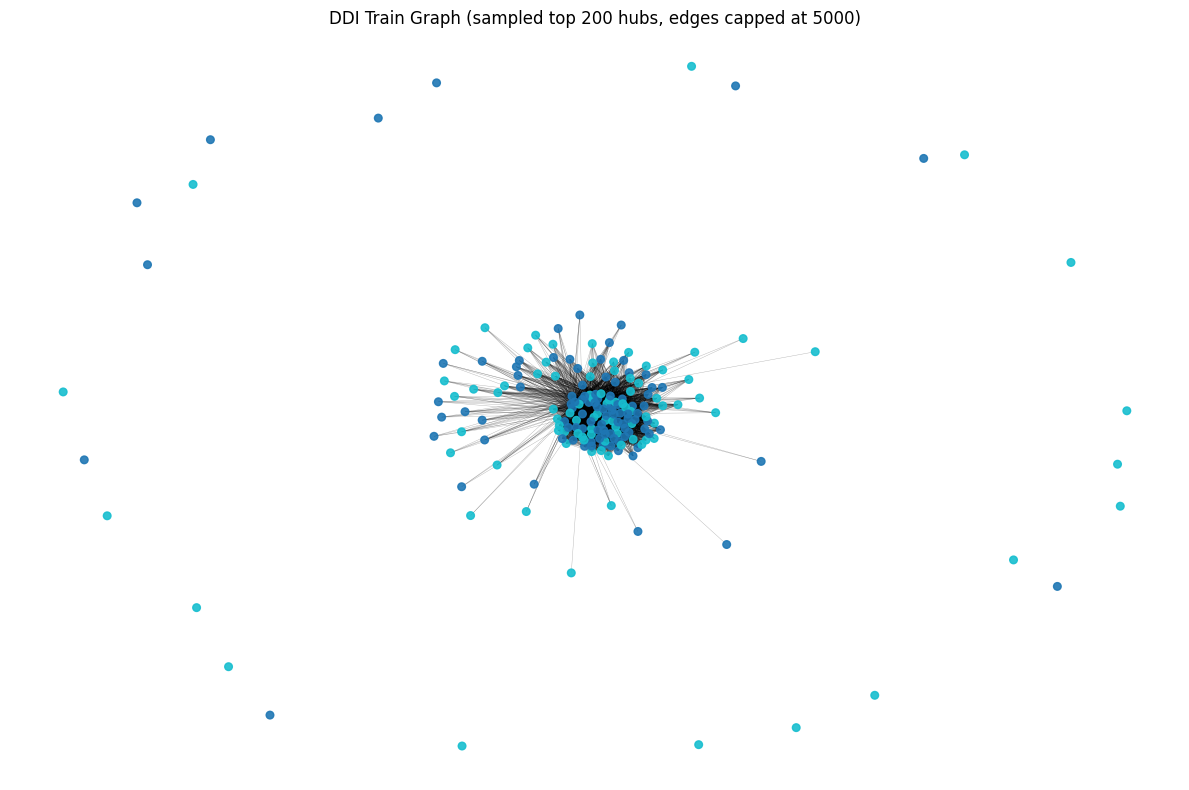

community_id  size
0             0   103
1             1    97


✅ Phase 4 completed. Check ./output/phase-4 for saved outputs.


In [6]:
# ============================
# PHASE 4: DDI NETWORK (Leakage-Aware)
# ============================
import os, gc, math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

try:
    import networkx as nx
except ImportError:
    raise ImportError("networkx not installed. Run: pip install networkx")

# ----------------------------
# CONFIG (adjust if needed)
# ----------------------------
BASE_DIR = r"E:\MyPhD\RP-5\output"
PHASE4_DIR = os.path.join(BASE_DIR, "phase-4")
os.makedirs(PHASE4_DIR, exist_ok=True)

PAIRS_CSV = os.path.join(BASE_DIR, "pairs_pos_neg_1to5.csv")   # contains drug_pk_1, drug_pk_2, label

# Leakage-aware split parameters (consistent, deterministic)
TEST_SIZE = 0.20
RANDOM_SEED = 42

# Chunk size for streaming reads
CHUNK = 500_000

# Large-graph metrics controls (keep practical)
# Betweenness is expensive on huge graphs; we use approximation with k samples.
BETWEENNESS_K = 1000  # lower -> faster, higher -> better approximation

# Visualization controls (we visualize a subgraph, not the full 1M+ edge graph)
TOP_HUBS = 200            # take top-degree nodes
MAX_EDGES_FOR_DRAW = 5000 # cap edges drawn for clarity

# ----------------------------
# Utilities
# ----------------------------
def status(msg):
    print(f"\n✅ {msg}")

def count_rows_fast(path, buf=8*1024*1024):
    n = 0
    with open(path, "rb") as f:
        while True:
            b = f.read(buf)
            if not b:
                break
            n += b.count(b"\n")
    return max(0, n - 1)

def edge_is_test(u: int, v: int, test_size: float, seed: int) -> bool:
    """
    Deterministic hash-based edge split for leakage control.
    Same edge always maps to same split.
    """
    a, b = (u, v) if u < v else (v, u)
    # 64-bit mix
    x = (a * 1315423911 + b * 2654435761 + seed) & 0xFFFFFFFF
    r = x / 2**32
    return r < test_size

# ----------------------------
# STEP 4.1: Graph Construction (train-only)
# ----------------------------
def build_train_graph_from_pairs(pairs_csv: str) -> tuple[nx.Graph, dict]:
    status("Step 4.1 — Build train-only DDI graph from positives")

    total_rows = count_rows_fast(pairs_csv)
    print(f"Total rows in pairs file: {total_rows:,}")

    # Count positives first (fast streaming) for progress clarity
    pos_count = 0
    with tqdm(total=total_rows, desc="Counting positives (label=1)", unit="rows") as pbar:
        for chunk in pd.read_csv(pairs_csv, usecols=["label"], chunksize=CHUNK):
            pos_count += int((chunk["label"] == 1).sum())
            pbar.update(len(chunk))
    print(f"Total positive edges (raw rows): {pos_count:,}")

    # Build training graph using only positive edges assigned to TRAIN split
    G_train = nx.Graph()
    edge_split_stats = {
        "pos_total": 0,
        "pos_train": 0,
        "pos_test": 0,
        "self_loops": 0
    }

    with tqdm(total=total_rows, desc="Building train graph (stream)", unit="rows") as pbar:
        for chunk in pd.read_csv(pairs_csv, usecols=["drug_pk_1", "drug_pk_2", "label"], chunksize=CHUNK):
            # keep only positive edges
            chunk = chunk[chunk["label"] == 1]
            if chunk.empty:
                pbar.update(CHUNK if len(chunk)==0 else len(chunk))
                continue

            a = chunk["drug_pk_1"].to_numpy(dtype=np.int64)
            b = chunk["drug_pk_2"].to_numpy(dtype=np.int64)

            edge_split_stats["pos_total"] += len(a)
            edge_split_stats["self_loops"] += int(np.sum(a == b))

            # assign train/test via deterministic edge hash
            for u, v in zip(a, b):
                if u == v:
                    continue
                if edge_is_test(int(u), int(v), TEST_SIZE, RANDOM_SEED):
                    edge_split_stats["pos_test"] += 1
                else:
                    edge_split_stats["pos_train"] += 1
                    G_train.add_edge(int(u), int(v))

            pbar.update(len(chunk))

    print("Edge split stats:", edge_split_stats)
    print("Train graph nodes:", G_train.number_of_nodes(), "edges:", G_train.number_of_edges())

    # Save a small summary
    pd.DataFrame([{
        **edge_split_stats,
        "train_nodes": G_train.number_of_nodes(),
        "train_edges": G_train.number_of_edges(),
        "test_size": TEST_SIZE,
        "seed": RANDOM_SEED
    }]).to_csv(os.path.join(PHASE4_DIR, "step41_graph_summary.csv"), index=False)

    return G_train, edge_split_stats

# ----------------------------
# STEP 4.2: Leakage-aware graph metrics (train-only)
# ----------------------------
def compute_graph_metrics_train_only(G_train: nx.Graph) -> pd.DataFrame:
    status("Step 4.2 — Compute graph metrics on TRAIN graph only")

    n = G_train.number_of_nodes()
    m = G_train.number_of_edges()
    print(f"Computing metrics on train graph: nodes={n:,}, edges={m:,}")

    nodes = list(G_train.nodes())

    # Degree (fast)
    deg = dict(G_train.degree())
    deg_series = pd.Series(deg)

    # Degree centrality (fast)
    deg_cent = nx.degree_centrality(G_train)

    # Clustering coefficient (can be heavy but manageable with 17k nodes)
    # Use approximate clustering to be safe:
    # networkx has "average_clustering" but per-node clustering is nx.clustering
    with tqdm(total=len(nodes), desc="Clustering coeff", unit="node") as pbar:
        clustering = {}
        # compute in chunks to show progress
        chunk_nodes = 2000
        for i in range(0, len(nodes), chunk_nodes):
            sub = nodes[i:i+chunk_nodes]
            clustering.update(nx.clustering(G_train, nodes=sub))
            pbar.update(len(sub))

    # Betweenness centrality (approximate using k samples)
    # This is expensive; we do approximate betweenness to keep runtime reasonable.
    k = min(BETWEENNESS_K, len(nodes))
    status(f"Computing approximate betweenness (k={k}) — can take some minutes")
    betw = nx.betweenness_centrality(G_train, k=k, normalized=True, seed=RANDOM_SEED)

    # Assemble metrics dataframe
    metrics = pd.DataFrame({
        "drug_pk": nodes,
        "degree": [deg.get(x, 0) for x in nodes],
        "degree_centrality": [deg_cent.get(x, 0.0) for x in nodes],
        "clustering_coeff": [clustering.get(x, 0.0) for x in nodes],
        "betweenness_approx": [betw.get(x, 0.0) for x in nodes],
    })

    # Save
    metrics.to_csv(os.path.join(PHASE4_DIR, "step42_train_graph_metrics.csv"), index=False)
    print("Saved metrics:", os.path.join(PHASE4_DIR, "step42_train_graph_metrics.csv"))

    # Show top hubs table
    top = metrics.sort_values("degree", ascending=False).head(20)
    display(top)

    return metrics

# ----------------------------
# STEP 4.3: Visualization + community detection (sample subgraph)
# ----------------------------
def visualize_and_communities(G_train: nx.Graph, metrics: pd.DataFrame):
    status("Step 4.3 — Visualize network + community structure (sampled subgraph)")

    # sample subgraph using TOP_HUBS highest degree nodes
    top_nodes = metrics.sort_values("degree", ascending=False)["drug_pk"].head(TOP_HUBS).tolist()
    H = G_train.subgraph(top_nodes).copy()

    print("Sample subgraph nodes:", H.number_of_nodes(), "edges:", H.number_of_edges())

    # Further cap edges for drawing clarity (keep graph connected-ish)
    if H.number_of_edges() > MAX_EDGES_FOR_DRAW:
        # Keep edges incident to highest-degree nodes first
        # Sort edges by sum of endpoint degrees
        deg = dict(H.degree())
        edges_sorted = sorted(H.edges(), key=lambda e: deg[e[0]] + deg[e[1]], reverse=True)
        keep_edges = edges_sorted[:MAX_EDGES_FOR_DRAW]
        H_draw = nx.Graph()
        H_draw.add_nodes_from(H.nodes())
        H_draw.add_edges_from(keep_edges)
    else:
        H_draw = H

    # Community detection (greedy modularity) on sampled graph
    # Works well on smaller H
    try:
        from networkx.algorithms.community import greedy_modularity_communities
        comms = list(greedy_modularity_communities(H, cutoff=1, best_n=10))
        # community assignment
        comm_id = {}
        for i, c in enumerate(comms):
            for node in c:
                comm_id[node] = i
        print("Communities found:", len(comms))
    except Exception as e:
        print("Community detection skipped (error):", e)
        comm_id = {n: 0 for n in H.nodes()}

    # Plot
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(H_draw, seed=RANDOM_SEED, k=0.25)  # layout
    node_colors = [comm_id.get(n, 0) for n in H_draw.nodes()]
    nx.draw_networkx_nodes(H_draw, pos, node_size=30, node_color=node_colors, cmap=plt.cm.tab10, alpha=0.9)
    nx.draw_networkx_edges(H_draw, pos, width=0.3, alpha=0.3)
    plt.title(f"DDI Train Graph (sampled top {TOP_HUBS} hubs, edges capped at {MAX_EDGES_FOR_DRAW})")
    plt.axis("off")
    plt.tight_layout()
    plot_path = os.path.join(PHASE4_DIR, "step43_sample_network.png")
    plt.savefig(plot_path, dpi=200)
    plt.show()

    # Save community table
    comm_tbl = pd.DataFrame({"drug_pk": list(H.nodes()),
                             "community_id": [comm_id.get(n, -1) for n in H.nodes()]})
    comm_tbl.to_csv(os.path.join(PHASE4_DIR, "step43_communities_sample.csv"), index=False)

    # Display quick table: community sizes
    comm_sizes = comm_tbl["community_id"].value_counts().sort_index().reset_index()
    comm_sizes.columns = ["community_id", "size"]
    display(comm_sizes)

# ----------------------------
# RUN PHASE 4
# ----------------------------
print("✅ Phase 4 outputs will be saved to:", PHASE4_DIR)
print("Using files:")
print(" -", PAIRS_CSV)
print(" -", TRAIN_PCA)
print(" -", TEST_PCA)

G_train, split_stats = build_train_graph_from_pairs(PAIRS_CSV)
metrics = compute_graph_metrics_train_only(G_train)
visualize_and_communities(G_train, metrics)

status("Phase 4 completed. Check ./output/phase-4 for saved outputs.")


In [ ]:
### phase - 4 figs

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

# 3D
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Make sure that plots are displayed inline in the Jupyter notebook
%matplotlib inline

# ----------------------------
# Paths
# ----------------------------
BASE_DIR = r"E:\MyPhD\RP-5\output"
PHASE4_DIR = os.path.join(BASE_DIR, "phase-4")
FIG_DIR = os.path.join(PHASE4_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

TRAIN_PCA = os.path.join(BASE_DIR, "train_pca.csv")
TEST_PCA = os.path.join(BASE_DIR, "test_pca.csv")
TRAIN_PCA_SMOTE = os.path.join(BASE_DIR, "train_pca_smote.csv")

PAIRS_CSV = os.path.join(BASE_DIR, "pairs_pos_neg_1to5.csv")

GRAPH_METRICS = os.path.join(PHASE4_DIR, "step42_train_graph_metrics.csv")  # from Phase 4

RANDOM_SEED = 42

# ----------------------------
# Helpers
# ----------------------------
def status(msg):
    print(f"\n✅ {msg}")

def load_pca_files(max_train=2_000_000, max_test=800_000):
    # load a manageable amount for plots & model curves (fast)
    train_df = pd.read_csv(TRAIN_PCA, nrows=max_train)
    test_df = pd.read_csv(TEST_PCA, nrows=max_test)
    return train_df, test_df

def savefig(name):
    path = os.path.join(FIG_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=300)
    plt.close()
    print("Saved:", path)

# ----------------------------
# 1) Pipeline diagram (2D)
# ----------------------------
def fig_pipeline_diagram():
    status("Figure: Pipeline diagram (Leakage-aware)")
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.axis("off")

    boxes = [
        ("MySQL DrugBank\n(drug, drug_interaction,\n drug_pathway, id_map)", 0.02, 0.55),
        ("Phase 1\nExtraction + ID mapping\n+ Pos/Neg sampling (1:5)", 0.22, 0.55),
        ("Phase 2\nDrug-level features\n(TF-IDF + masses + pathways)\nPair ops", 0.42, 0.55),
        ("Phase 3\nEDA + Quality Audit\n(hubs, corr, outliers)", 0.62, 0.55),
        ("Phase 4\nLeakage-aware Graph\n(train-only metrics)", 0.82, 0.55),
    ]

    for text, x, y in boxes:
        ax.add_patch(plt.Rectangle((x, y), 0.16, 0.35, fill=False, linewidth=2))
        ax.text(x+0.08, y+0.175, text, ha="center", va="center", fontsize=9)

    # arrows
    for i in range(len(boxes)-1):
        x1 = boxes[i][1] + 0.16
        y1 = boxes[i][2] + 0.175
        x2 = boxes[i+1][1]
        y2 = boxes[i+1][2] + 0.175
        ax.annotate("", xy=(x2, y2), xytext=(x1, y1), arrowprops=dict(arrowstyle="->", lw=2))

    ax.text(0.5, 0.15,
            "Leakage control: Split before scaling/PCA; fit scaler+PCA on TRAIN only; SMOTE only on TRAIN; graph metrics on TRAIN graph only.",
            ha="center", fontsize=9)

    savefig("fig1_pipeline_leakage_aware.png")

# ----------------------------
# 2) Imbalance vs after SMOTE (2D)
# ----------------------------
def fig_imbalance_smote():
    status("Figure: Class imbalance before vs after SMOTE (train)")
    # before SMOTE from train_pca.csv counts (approx)
    train_df = pd.read_csv(TRAIN_PCA, usecols=["label"], nrows=2_000_000)
    before = train_df["label"].value_counts().to_dict()
    del train_df

    # after SMOTE from train_pca_smote.csv counts
    smote_df = pd.read_csv(TRAIN_PCA_SMOTE, usecols=["label"])
    after = smote_df["label"].value_counts().to_dict()

    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(["Before SMOTE (0)", "Before SMOTE (1)"], [before.get(0,0), before.get(1,0)])
    ax.bar(["After SMOTE (0)", "After SMOTE (1)"], [after.get(0,0), after.get(1,0)])
    ax.set_title("Train Class Balance: Before vs After SMOTE")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=20)
    savefig("fig2_smote_balance.png")

# ----------------------------
# 3) ROC + PR curves (2D) — LogReg vs HGB
# ----------------------------
def fig_roc_pr_curves():
    status("Figure: ROC & PR curves (LogReg vs HGB)")

    # Use full train_pca_smote + a chunk of test_pca
    train_df = pd.read_csv(TRAIN_PCA_SMOTE)
    test_df = pd.read_csv(TEST_PCA)

    X_train = train_df.drop(columns=["label"]).to_numpy(dtype=np.float32)
    y_train = train_df["label"].astype(int).to_numpy()

    X_test = test_df.drop(columns=["label"]).to_numpy(dtype=np.float32)
    y_test = test_df["label"].astype(int).to_numpy()

    models = {
        "LogReg": LogisticRegression(max_iter=5000, solver="lbfgs"),
        "HGB": HistGradientBoostingClassifier(random_state=RANDOM_SEED, max_iter=300, learning_rate=0.1)
    }

    # ROC plot
    plt.figure(figsize=(7,5))
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title("ROC Curve (Test set)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    savefig("fig3_roc_curve.png")

    # PR plot
    plt.figure(figsize=(7,5))
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:, 1]  # already fit above
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{name} (AUPRC={pr_auc:.3f})")
    baseline = y_test.mean()
    plt.hlines(baseline, 0, 1, linestyles="--", label=f"Baseline={baseline:.3f}")
    plt.title("Precision–Recall Curve (Test set)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    savefig("fig4_pr_curve.png")

# ----------------------------
# 4) Confusion matrices (2D) at threshold 0.5
# ----------------------------
def fig_confusion_matrices():
    status("Figure: Confusion matrices (threshold=0.5)")
    train_df = pd.read_csv(TRAIN_PCA_SMOTE)
    test_df = pd.read_csv(TEST_PCA)

    X_train = train_df.drop(columns=["label"]).to_numpy(dtype=np.float32)
    y_train = train_df["label"].astype(int).to_numpy()

    X_test = test_df.drop(columns=["label"]).to_numpy(dtype=np.float32)
    y_test = test_df["label"].astype(int).to_numpy()

    models = {
        "LogReg": LogisticRegression(max_iter=5000, solver="lbfgs"),
        "HGB": HistGradientBoostingClassifier(random_state=RANDOM_SEED, max_iter=300, learning_rate=0.1)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot(values_format="d")
        plt.title(f"Confusion Matrix: {name}")
        savefig(f"fig5_confusion_{name}.png")

# ----------------------------
# 5) 3D PCA scatter (PC1–PC3) (3D)
# ----------------------------
def fig_3d_pca_scatter():
    status("Figure: 3D PCA scatter (PC1–PC3)")
    # sample for speed
    df = pd.read_csv(TEST_PCA, nrows=200_000)
    x = df["pca_1"].values
    y = df["pca_2"].values
    z = df["pca_3"].values
    c = df["label"].values

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x[c==0], y[c==0], z[c==0], s=1, alpha=0.3, label="0")
    ax.scatter(x[c==1], y[c==1], z[c==1], s=1, alpha=0.3, label="1")
    ax.set_title("3D PCA Scatter (Test sample)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.legend()
    plt.tight_layout()
    path = os.path.join(FIG_DIR, "fig6_3d_pca_scatter.png")
    plt.savefig(path, dpi=300)
    plt.close()
    print("Saved:", path)

# ----------------------------
# 6) Degree distribution + hub rank plot (2D) from Phase 4 metrics if available
# ----------------------------
def fig_degree_hubs():
    status("Figure: Network degree distribution & hub rank")
    if not os.path.exists(GRAPH_METRICS):
        print("⚠️ Graph metrics not found:", GRAPH_METRICS)
        print("Run Phase 4 metrics first to generate step42_train_graph_metrics.csv.")
        return

    metrics = pd.read_csv(GRAPH_METRICS)
    deg = metrics["degree"].values

    plt.figure(figsize=(7,5))
    plt.hist(deg, bins=120)
    plt.title("Degree Distribution (Train DDI Graph)")
    plt.xlabel("Degree")
    plt.ylabel("Count of drugs")
    savefig("fig7_degree_hist.png")

    deg_sorted = np.sort(deg)[::-1]
    plt.figure(figsize=(7,5))
    plt.plot(np.arange(1, len(deg_sorted)+1), deg_sorted)
    plt.yscale("log")
    plt.title("Hub Rank Plot (log scale)")
    plt.xlabel("Rank")
    plt.ylabel("Degree (log)")
    savefig("fig8_hub_rank_log.png")

# ----------------------------
# 7) Permutation importance on PCA features (2D)
# ----------------------------
def fig_permutation_importance():
    status("Figure: Permutation importance (PCA features, HGB)")
    train_df = pd.read_csv(TRAIN_PCA_SMOTE)
    test_df = pd.read_csv(TEST_PCA)

    X_train = train_df.drop(columns=["label"]).to_numpy(dtype=np.float32)
    y_train = train_df["label"].astype(int).to_numpy()

    X_test = test_df.drop(columns=["label"]).to_numpy(dtype=np.float32)
    y_test = test_df["label"].astype(int).to_numpy()

    model = HistGradientBoostingClassifier(random_state=RANDOM_SEED, max_iter=300, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Use a smaller subset for speed
    n = min(200_000, len(X_test))
    X_sub = X_test[:n]
    y_sub = y_test[:n]

    r = permutation_importance(model, X_sub, y_sub, n_repeats=5, random_state=RANDOM_SEED, scoring="average_precision")
    imp = r.importances_mean
    cols = [f"pca_{i+1}" for i in range(X_sub.shape[1])]

    imp_df = pd.DataFrame({"feature": cols, "perm_importance": imp}).sort_values("perm_importance", ascending=False)
    imp_df.to_csv(os.path.join(FIG_DIR, "fig9_perm_importance.csv"), index=False)

    plt.figure(figsize=(7,4))
    plt.bar(imp_df["feature"], imp_df["perm_importance"])
    plt.title("Permutation Importance (Average Precision) — HGB")
    plt.xlabel("PCA component")
    plt.ylabel("Importance")
    savefig("fig9_perm_importance.png")

# ----------------------------
# RUN
# ----------------------------
print("Saving figures to:", FIG_DIR)
fig_pipeline_diagram()
fig_imbalance_smote()
fig_roc_pr_curves()
fig_confusion_matrices()
fig_3d_pca_scatter()
fig_degree_hubs()
fig_permutation_importance()

print("\n✅ Done. You can use these PNGs directly in your research paper.")

Saving figures to: E:\MyPhD\RP-5\output\phase-4\figures

✅ Figure: Pipeline diagram (Leakage-aware)
Saved: E:\MyPhD\RP-5\output\phase-4\figures\fig1_pipeline_leakage_aware.png

✅ Figure: Class imbalance before vs after SMOTE (train)
Saved: E:\MyPhD\RP-5\output\phase-4\figures\fig2_smote_balance.png

✅ Figure: ROC & PR curves (LogReg vs HGB)
Saved: E:\MyPhD\RP-5\output\phase-4\figures\fig3_roc_curve.png
Saved: E:\MyPhD\RP-5\output\phase-4\figures\fig4_pr_curve.png

✅ Figure: Confusion matrices (threshold=0.5)
Saved: E:\MyPhD\RP-5\output\phase-4\figures\fig5_confusion_LogReg.png
Saved: E:\MyPhD\RP-5\output\phase-4\figures\fig5_confusion_HGB.png

✅ Figure: 3D PCA scatter (PC1–PC3)
Saved: E:\MyPhD\RP-5\output\phase-4\figures\fig6_3d_pca_scatter.png

✅ Figure: Network degree distribution & hub rank
Saved: E:\MyPhD\RP-5\output\phase-4\figures\fig7_degree_hist.png
Saved: E:\MyPhD\RP-5\output\phase-4\figures\fig8_hub_rank_log.png

✅ Figure: Permutation importance (PCA features, HGB)
Saved: E:\

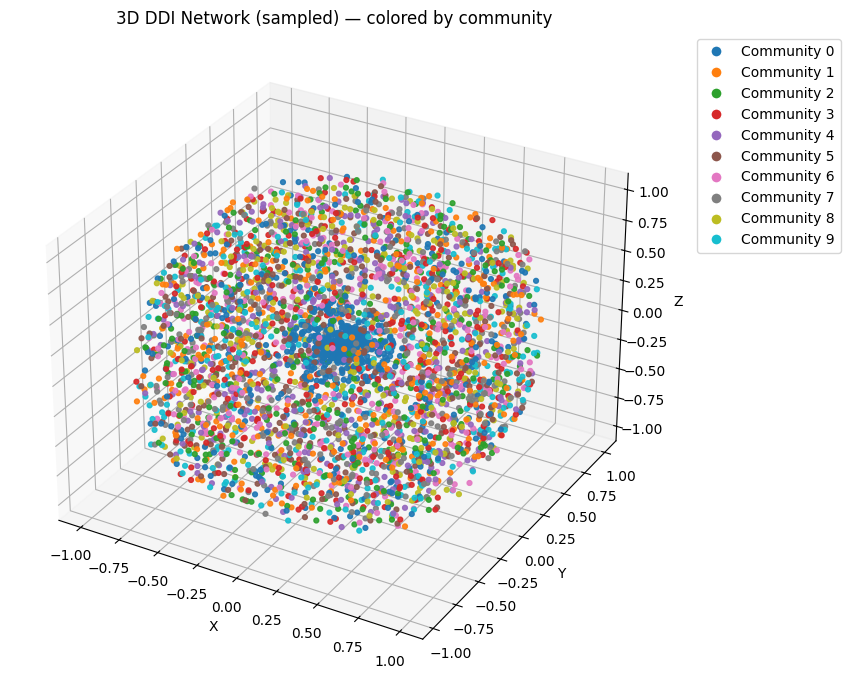

Saved: E:\MyPhD\RP-5\output\phase-4\figures\fig10_3d_network_communities.png
Nodes: 4223 Edges: 8000 Communities: 3580


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from networkx.algorithms.community import greedy_modularity_communities

# ----------------------------
# Paths
# ----------------------------
BASE_DIR = r"E:\MyPhD\RP-5\output"
PHASE4_DIR = os.path.join(BASE_DIR, "phase-4")
FIG_DIR = os.path.join(PHASE4_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

PAIRS_CSV = os.path.join(BASE_DIR, "pairs_pos_neg_1to5.csv")  # true labeled pairs
GRAPH_METRICS = os.path.join(PHASE4_DIR, "step42_train_graph_metrics.csv")

RANDOM_SEED = 42

# Sampling settings (keep it paper-readable)
TOP_HUBS = 150          # top hubs to seed subgraph
NEIGHBOR_DEPTH = 1      # include 1-hop neighbors of hubs
MAX_EDGES = 8000        # cap edges drawn for clarity

# ----------------------------
# Helper: build a small positive-edge subgraph
# ----------------------------
def build_sample_subgraph_from_pairs(pairs_csv, hub_nodes=None, top_hubs=150, neighbor_depth=1):
    # Load only positive edges (label=1) columns needed
    df = pd.read_csv(pairs_csv, usecols=["drug_pk_1", "drug_pk_2", "label"])
    df = df[df["label"] == 1]

    # If we have hub nodes, build subgraph around them
    G = nx.Graph()
    G.add_edges_from(zip(df["drug_pk_1"].astype(int), df["drug_pk_2"].astype(int)))

    if hub_nodes is None:
        # fallback: use highest-degree nodes from this temporary graph
        deg = dict(G.degree())
        hub_nodes = [n for n, _ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:top_hubs]]

    # expand neighborhood
    nodes = set(hub_nodes)
    for _ in range(neighbor_depth):
        new_nodes = set()
        for n in list(nodes):
            new_nodes.update(G.neighbors(n))
        nodes |= new_nodes

    H = G.subgraph(nodes).copy()
    return H

# ----------------------------
# 3D Network plot with communities
# ----------------------------
def plot_3d_network_with_communities(H, max_edges=8000, seed=42):
    # cap edges for visibility
    if H.number_of_edges() > max_edges:
        deg = dict(H.degree())
        edges_sorted = sorted(H.edges(), key=lambda e: deg[e[0]] + deg[e[1]], reverse=True)
        keep = edges_sorted[:max_edges]
        H_draw = nx.Graph()
        H_draw.add_nodes_from(H.nodes())
        H_draw.add_edges_from(keep)
    else:
        H_draw = H

    # Community detection (on sampled graph)
    comms = list(greedy_modularity_communities(H_draw))
    comm_id = {}
    for i, cset in enumerate(comms):
        for n in cset:
            comm_id[n] = i

    # 3D spring layout
    pos3 = nx.spring_layout(H_draw, dim=3, seed=seed)

    xs = np.array([pos3[n][0] for n in H_draw.nodes()])
    ys = np.array([pos3[n][1] for n in H_draw.nodes()])
    zs = np.array([pos3[n][2] for n in H_draw.nodes()])

    colors = np.array([comm_id.get(n, 0) for n in H_draw.nodes()])

    # Plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    # edges
    for u, v in H_draw.edges():
        xline = [pos3[u][0], pos3[v][0]]
        yline = [pos3[u][1], pos3[v][1]]
        zline = [pos3[u][2], pos3[v][2]]
        ax.plot(xline, yline, zline, linewidth=0.3, alpha=0.25)

    # nodes
    sc = ax.scatter(xs, ys, zs, c=colors, cmap="tab10", s=12, alpha=0.9)

    ax.set_title("3D DDI Network (sampled) — colored by community")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # color legend (community ids)
    # show up to 10 communities in legend
    unique_comms = sorted(set(colors))[:10]
    handles = []
    for cid in unique_comms:
        handles.append(plt.Line2D([0],[0], marker='o', color='w',
                                  label=f"Community {cid}",
                                  markerfacecolor=plt.cm.tab10(cid % 10),
                                  markersize=8))
    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.05, 1))

    out_path = os.path.join(FIG_DIR, "fig10_3d_network_communities.png")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()
    print("Saved:", out_path)
    print("Nodes:", H_draw.number_of_nodes(), "Edges:", H_draw.number_of_edges(), "Communities:", len(comms))

# ----------------------------
# Get hub nodes (preferred: use Phase-4 metrics)
# ----------------------------
hub_nodes = None
if os.path.exists(GRAPH_METRICS):
    m = pd.read_csv(GRAPH_METRICS)
    hub_nodes = m.sort_values("degree", ascending=False)["drug_pk"].head(TOP_HUBS).astype(int).tolist()
else:
    print("⚠️ Graph metrics file not found. Using fallback degree hubs from positive edges.")

# Build sampled subgraph and plot
H = build_sample_subgraph_from_pairs(PAIRS_CSV, hub_nodes=hub_nodes, top_hubs=TOP_HUBS, neighbor_depth=NEIGHBOR_DEPTH)
plot_3d_network_with_communities(H, max_edges=MAX_EDGES, seed=RANDOM_SEED)

In [1]:
import os, json, gc
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV

# ==========================================================
# CONFIG
# ==========================================================
BASE_DIR = r".\output"
OUT_DIR = os.path.join(BASE_DIR, "phase-5")
os.makedirs(OUT_DIR, exist_ok=True)

TRAIN_SMOTE_CSV = os.path.join(BASE_DIR, "train_pca_smote.csv")
TEST_PCA_CSV    = os.path.join(BASE_DIR, "test_pca.csv")

OUT_METRICS    = os.path.join(OUT_DIR, "metrics_phase5.csv")
OUT_BEST_JSON  = os.path.join(OUT_DIR, "best_pso_params.json")
OUT_TEST_PRED  = os.path.join(OUT_DIR, "test_predictions_phase5.csv")

# Disk-backed memmap files (low RAM)
MMAP_TRAIN_X = os.path.join(OUT_DIR, "mmap_train_X.dat")
MMAP_TRAIN_Y = os.path.join(OUT_DIR, "mmap_train_y.dat")
MMAP_TEST_X  = os.path.join(OUT_DIR, "mmap_test_X.dat")
MMAP_TEST_Y  = os.path.join(OUT_DIR, "mmap_test_y.dat")

RANDOM_SEED = 42
N_PCA = 10
VAL_SIZE = 0.15

# RF speed
RF_SUBSAMPLE = 500_000
RF_TREES_TOTAL = 300
RF_TREES_STEP = 25
RF_MAX_DEPTH = 18
RF_MAX_SAMPLES = 0.7
RF_MIN_LEAF = 2

# MLP baseline
MLP_HIDDEN = (128, 64)
MLP_MAX_ITER = 150

# PSO speed
PSO_TRAIN_N = 300_000
PSO_VAL_N   = 100_000
PSO_PARTICLES = 20
PSO_ITERS = 25
PSO_MLP_MAX_ITER = 60
PSO_MLP_BATCH = 2048

CSV_CHUNK = 500_000  # reading chunks

# ==========================================================
# UTILITIES
# ==========================================================
def status(msg):
    print(f"\n✅ {msg}")

def count_rows_fast(path, buf=8*1024*1024):
    """Fast newline count (binary), returns rows excluding header."""
    n = 0
    with open(path, "rb") as f:
        while True:
            b = f.read(buf)
            if not b:
                break
            n += b.count(b"\n")
    return max(0, n - 1)

def make_memmap(path, shape, dtype=np.float32):
    # overwrite old file if exists
    if os.path.exists(path):
        os.remove(path)
    return np.memmap(path, mode="w+", dtype=dtype, shape=shape)

def load_csv_to_memmap(csv_path, total_rows, mmap_x_path, mmap_y_path, chunksize=500_000):
    """
    Loads pca_1..pca_10 + label into disk-backed memmaps with progress bar.
    Very low RAM: no list-of-arrays, no vstack.
    """
    cols = [f"pca_{i+1}" for i in range(N_PCA)] + ["label"]

    X_mm = make_memmap(mmap_x_path, (total_rows, N_PCA), dtype=np.float32)
    y_mm = make_memmap(mmap_y_path, (total_rows,), dtype=np.int8)

    idx = 0
    with tqdm(total=total_rows, desc=f"Loading → memmap: {os.path.basename(csv_path)}", unit="rows") as pbar:
        for chunk in pd.read_csv(csv_path, usecols=cols, chunksize=chunksize):
            n = len(chunk)
            X_mm[idx:idx+n, :] = chunk.drop(columns=["label"]).to_numpy(dtype=np.float32)
            y_mm[idx:idx+n] = chunk["label"].astype(np.int8).to_numpy()
            idx += n
            pbar.update(n)

    X_mm.flush()
    y_mm.flush()
    return X_mm, y_mm

def stratified_subsample_indices(y, n, seed=42):
    """Return indices for a stratified subsample of size n from labels array y."""
    if n >= len(y):
        return np.arange(len(y))
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n, random_state=seed)
    idx, _ = next(sss.split(np.zeros((len(y), 1)), y))
    return idx

def eval_probs(name, model, X_tr, y_tr, X_val, y_val, X_test, y_test):
    model.fit(X_tr, y_tr)
    pv = model.predict_proba(X_val)[:, 1]
    pt = model.predict_proba(X_test)[:, 1]
    return {
        "model": name,
        "val_auprc": float(average_precision_score(y_val, pv)),
        "val_auroc": float(roc_auc_score(y_val, pv)),
        "test_auprc": float(average_precision_score(y_test, pt)),
        "test_auroc": float(roc_auc_score(y_test, pt)),
    }, pt

# ==========================================================
# STEP 0: COUNT ROWS FIRST (FAST) + SHOW STATUS
# ==========================================================
status("Phase 5: Counting records first (fast)")
n_train = count_rows_fast(TRAIN_SMOTE_CSV)
n_test  = count_rows_fast(TEST_PCA_CSV)
print(f"Train (SMOTE) rows: {n_train:,}")
print(f"Test rows        : {n_test:,}")

# ==========================================================
# STEP 1: LOAD TO MEMMAP (LOW RAM) + PROGRESS
# ==========================================================
status("Loading datasets into disk-backed memmaps (low RAM)")
X_train_mm, y_train_mm = load_csv_to_memmap(TRAIN_SMOTE_CSV, n_train, MMAP_TRAIN_X, MMAP_TRAIN_Y, chunksize=CSV_CHUNK)
X_test_mm, y_test_mm   = load_csv_to_memmap(TEST_PCA_CSV,   n_test,  MMAP_TEST_X,  MMAP_TEST_Y,  chunksize=CSV_CHUNK)

print("Train memmap shape:", X_train_mm.shape, "Test memmap shape:", X_test_mm.shape)
print("Test positive rate:", float(np.mean(y_test_mm)))

# ==========================================================
# STEP 2: TRAIN/VAL SPLIT INDICES (keeps test untouched)
# ==========================================================
status("Creating Train/Val split indices (no heavy copies)")
idx_all = np.arange(n_train)
# to avoid huge copies, split indices based on labels
sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_SEED)
idx_tr, idx_val = next(sss.split(np.zeros((n_train, 1)), y_train_mm))
print("Train idx:", len(idx_tr), "Val idx:", len(idx_val))

# create views (numpy indexing will create arrays; but we only materialize for training when needed)
# We'll materialize full X_tr/X_val as float32 arrays because sklearn expects contiguous arrays.
# This is the only unavoidable RAM-heavy step in CPU sklearn.
status("Materializing Train/Val arrays (this is the main RAM step)")
X_tr = np.asarray(X_train_mm[idx_tr], dtype=np.float32)
y_tr = np.asarray(y_train_mm[idx_tr], dtype=np.int32)
X_val = np.asarray(X_train_mm[idx_val], dtype=np.float32)
y_val = np.asarray(y_train_mm[idx_val], dtype=np.int32)

X_test = np.asarray(X_test_mm, dtype=np.float32)   # test is 1.7M × 10 -> ok
y_test = np.asarray(y_test_mm, dtype=np.int32)

print("Train:", X_tr.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ==========================================================
# STEP 5.2: BASELINES (FAST)
# ==========================================================
status("Step 5.2: Training baselines (LogReg, HGB, MLP, RF-subsample)")
metrics = []
test_preds = {}

# LogReg full
print("Training: LogReg (full)")
m, yhat = eval_probs("LogReg",
                     LogisticRegression(max_iter=5000, solver="lbfgs"),
                     X_tr, y_tr, X_val, y_val, X_test, y_test)
metrics.append(m); test_preds["LogReg"] = yhat
print("  Test AUPRC:", round(m["test_auprc"], 4), "Test AUROC:", round(m["test_auroc"], 4))

# HGB full (strong baseline)
print("Training: HGB (full)")
m, yhat = eval_probs("HGB",
                     HistGradientBoostingClassifier(random_state=RANDOM_SEED, max_iter=300, learning_rate=0.1),
                     X_tr, y_tr, X_val, y_val, X_test, y_test)
metrics.append(m); test_preds["HGB"] = yhat
print("  Test AUPRC:", round(m["test_auprc"], 4), "Test AUROC:", round(m["test_auroc"], 4))

# MLP baseline (no PSO)
print("Training: MLP_no_PSO (full-ish, early stopping)")
mlp_base = MLPClassifier(
    hidden_layer_sizes=MLP_HIDDEN,
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    alpha=1e-4,
    early_stopping=True,
    n_iter_no_change=10,
    max_iter=MLP_MAX_ITER,
    random_state=RANDOM_SEED,
    batch_size=2048
)
m, yhat = eval_probs("MLP_no_PSO", mlp_base, X_tr, y_tr, X_val, y_val, X_test, y_test)
metrics.append(m); test_preds["MLP_no_PSO"] = yhat
print("  Test AUPRC:", round(m["test_auprc"], 4), "Test AUROC:", round(m["test_auroc"], 4))

# RF subsample with warm_start progress
print("Training: RF_subsample (stratified subsample + warm_start progress)")
rf_idx = stratified_subsample_indices(y_tr, RF_SUBSAMPLE, seed=RANDOM_SEED)
X_rf = X_tr[rf_idx]
y_rf = y_tr[rf_idx]
print("RF subsample:", X_rf.shape, "pos rate:", float(y_rf.mean()))

rf = RandomForestClassifier(
    n_estimators=0,
    warm_start=True,
    n_jobs=-1,
    random_state=RANDOM_SEED,
    max_depth=RF_MAX_DEPTH,
    max_features="sqrt",
    min_samples_leaf=RF_MIN_LEAF,
    bootstrap=True,
    max_samples=RF_MAX_SAMPLES
)

for n_trees in tqdm(range(RF_TREES_STEP, RF_TREES_TOTAL + 1, RF_TREES_STEP), desc="RF training", unit="trees"):
    rf.set_params(n_estimators=n_trees)
    rf.fit(X_rf, y_rf)

pv = rf.predict_proba(X_val)[:, 1]
pt = rf.predict_proba(X_test)[:, 1]
m = {
    "model": "RF_subsample",
    "val_auprc": float(average_precision_score(y_val, pv)),
    "val_auroc": float(roc_auc_score(y_val, pv)),
    "test_auprc": float(average_precision_score(y_test, pt)),
    "test_auroc": float(roc_auc_score(y_test, pt)),
}
metrics.append(m); test_preds["RF_subsample"] = pt
print("  Test AUPRC:", round(m["test_auprc"], 4), "Test AUROC:", round(m["test_auroc"], 4))

dfm = pd.DataFrame(metrics).sort_values("test_auprc", ascending=False)
dfm.to_csv(OUT_METRICS, index=False)
status(f"Saved baseline metrics → {OUT_METRICS}")
display(dfm)

# ==========================================================
# STEP 5.4: PSO (FAST fitness on subsamples)
# ==========================================================
status("Step 5.4: PSO optimization (FAST: subsampled fitness)")

pso_tr_idx = stratified_subsample_indices(y_tr, PSO_TRAIN_N, seed=RANDOM_SEED)
pso_val_idx = stratified_subsample_indices(y_val, PSO_VAL_N, seed=RANDOM_SEED)

X_tr_s = X_tr[pso_tr_idx]; y_tr_s = y_tr[pso_tr_idx]
X_val_s = X_val[pso_val_idx]; y_val_s = y_val[pso_val_idx]

print("PSO train subset:", X_tr_s.shape, "pos rate:", float(y_tr_s.mean()))
print("PSO val subset  :", X_val_s.shape, "pos rate:", float(y_val_s.mean()))

dim = N_PCA + 3

def decode_particle(p):
    w = p[:N_PCA].astype(np.float32)
    hidden = int(np.clip(round(p[N_PCA]), 32, 256))
    log_lr = float(np.clip(p[N_PCA+1], -4, -2))
    log_alpha = float(np.clip(p[N_PCA+2], -6, -2))
    lr = 10 ** log_lr
    alpha = 10 ** log_alpha
    if np.all(w <= 1e-6):
        w = np.ones_like(w)
    return w, hidden, lr, alpha

def pso_fitness(p):
    w, hidden, lr, alpha = decode_particle(p)
    Xtr_w = X_tr_s * w
    Xval_w = X_val_s * w

    mlp = MLPClassifier(
        hidden_layer_sizes=(hidden,),
        activation="relu",
        solver="adam",
        learning_rate_init=lr,
        alpha=alpha,
        early_stopping=True,
        n_iter_no_change=8,
        max_iter=PSO_MLP_MAX_ITER,
        random_state=RANDOM_SEED,
        batch_size=PSO_MLP_BATCH
    )
    mlp.fit(Xtr_w, y_tr_s)
    yv = mlp.predict_proba(Xval_w)[:, 1]
    auprc = average_precision_score(y_val_s, yv)
    auroc = roc_auc_score(y_val_s, yv)
    return float(auprc + 0.05 * auroc)

rng = np.random.default_rng(RANDOM_SEED)
swarm = np.zeros((PSO_PARTICLES, dim), dtype=np.float32)
swarm[:, :N_PCA] = rng.uniform(0.0, 1.0, size=(PSO_PARTICLES, N_PCA))
swarm[:, N_PCA] = rng.uniform(64, 192, size=PSO_PARTICLES)
swarm[:, N_PCA+1] = rng.uniform(-3.5, -2.2, size=PSO_PARTICLES)
swarm[:, N_PCA+2] = rng.uniform(-5.5, -3.0, size=PSO_PARTICLES)

vel = rng.normal(0, 0.1, size=(PSO_PARTICLES, dim)).astype(np.float32)
pbest = swarm.copy()
pbest_score = np.full(PSO_PARTICLES, -np.inf, dtype=np.float32)
gbest = None
gbest_score = -np.inf

w_inertia = 0.72; c1 = 1.49; c2 = 1.49

for it in tqdm(range(PSO_ITERS), desc="PSO iterations", unit="iter"):
    # show per-iteration particle progress
    for i in range(PSO_PARTICLES):
        s = pso_fitness(swarm[i])
        if s > pbest_score[i]:
            pbest_score[i] = s
            pbest[i] = swarm[i].copy()
        if s > gbest_score:
            gbest_score = s
            gbest = swarm[i].copy()

    r1 = rng.random((PSO_PARTICLES, dim), dtype=np.float32)
    r2 = rng.random((PSO_PARTICLES, dim), dtype=np.float32)

    vel = (w_inertia * vel
           + c1 * r1 * (pbest - swarm)
           + c2 * r2 * (gbest - swarm))
    swarm = swarm + vel

    swarm[:, :N_PCA] = np.clip(swarm[:, :N_PCA], 0.0, 1.0)
    swarm[:, N_PCA] = np.clip(swarm[:, N_PCA], 32, 256)
    swarm[:, N_PCA+1] = np.clip(swarm[:, N_PCA+1], -4, -2)
    swarm[:, N_PCA+2] = np.clip(swarm[:, N_PCA+2], -6, -2)

best_w, best_hidden, best_lr, best_alpha = decode_particle(gbest)
best_params = {
    "feature_weights": best_w.tolist(),
    "hidden_units": int(best_hidden),
    "learning_rate_init": float(best_lr),
    "alpha": float(best_alpha),
    "fitness_val": float(gbest_score),
    "pso_train_n": int(PSO_TRAIN_N),
    "pso_val_n": int(PSO_VAL_N),
    "particles": int(PSO_PARTICLES),
    "iters": int(PSO_ITERS)
}
with open(OUT_BEST_JSON, "w") as f:
    json.dump(best_params, f, indent=2)
status(f"Best PSO fitness: {gbest_score:.4f} | saved → {OUT_BEST_JSON}")

# ==========================================================
# STEP 5.5: Train final PSO-MLP + calibration on holdout from train
# ==========================================================
status("Step 5.5: Train final PSO-MLP + Platt calibration")

# Calibration split from FULL TRAIN (memmap still available)
# We reuse the already materialized X_tr/y_tr (train) and X_val/y_val (val) for simplicity.
X_cal_tr, X_cal_va, y_cal_tr, y_cal_va = train_test_split(
    X_tr * best_w, y_tr,
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=y_tr
)

base = MLPClassifier(
    hidden_layer_sizes=(best_hidden,),
    activation="relu",
    solver="adam",
    learning_rate_init=best_lr,
    alpha=best_alpha,
    early_stopping=True,
    n_iter_no_change=10,
    max_iter=200,
    random_state=RANDOM_SEED,
    batch_size=2048
)
base.fit(X_cal_tr, y_cal_tr)

cal = CalibratedClassifierCV(base, method="sigmoid", cv="prefit")
cal.fit(X_cal_va, y_cal_va)

y_test_pso = cal.predict_proba(X_test * best_w)[:, 1]
test_preds["PSO_MLP_Cal"] = y_test_pso

pso_row = {
    "model": "PSO_MLP_Cal",
    "val_auprc": None,
    "val_auroc": None,
    "test_auprc": float(average_precision_score(y_test, y_test_pso)),
    "test_auroc": float(roc_auc_score(y_test, y_test_pso))
}
dfm2 = pd.concat([dfm, pd.DataFrame([pso_row])], ignore_index=True).sort_values("test_auprc", ascending=False)
dfm2.to_csv(OUT_METRICS, index=False)

status(f"Updated metrics saved → {OUT_METRICS}")
display(dfm2.head(10))

# Save predictions
pred = pd.DataFrame({"y_true": y_test})
for k, v in test_preds.items():
    pred[f"proba_{k}"] = v
pred.to_csv(OUT_TEST_PRED, index=False)
status(f"Saved test predictions → {OUT_TEST_PRED}")

print("\n✅ Phase-5 completed. Outputs in:", OUT_DIR)


✅ Phase 5: Counting records first (fast)
Train (SMOTE) rows: 11,421,374
Test rows        : 1,713,189

✅ Loading datasets into disk-backed memmaps (low RAM)


Loading → memmap: test_pca.csv: 100%|██████████████████████████████████| 1713189/1713189 [00:07<00:00, 233712.55rows/s]


Train memmap shape: (11421374, 10) Test memmap shape: (1713189, 10)
Test positive rate: 0.1667072342864681

✅ Creating Train/Val split indices (no heavy copies)
Train idx: 9708167 Val idx: 1713207

✅ Materializing Train/Val arrays (this is the main RAM step)
Train: (9708167, 10) Val: (1713207, 10) Test: (1713189, 10)

✅ Step 5.2: Training baselines (LogReg, HGB, MLP, RF-subsample)
Training: LogReg (full)
  Test AUPRC: 0.6157 Test AUROC: 0.8554
Training: HGB (full)
  Test AUPRC: 0.6893 Test AUROC: 0.9133
Training: MLP_no_PSO (full-ish, early stopping)
  Test AUPRC: 0.7066 Test AUROC: 0.9235
Training: RF_subsample (stratified subsample + warm_start progress)
RF subsample: (500000, 10) pos rate: 0.5


RF training: 100%|██████████████████████████████████████████████████████████████████| 12/12 [01:48<00:00,  9.04s/trees]


  Test AUPRC: 0.7439 Test AUROC: 0.9382

✅ Saved baseline metrics → .\output\phase-5\metrics_phase5.csv


model  val_auprc  val_auroc  test_auprc  test_auroc
3  RF_subsample   0.930682   0.941785    0.743899    0.938180
2    MLP_no_PSO   0.912885   0.924932    0.706558    0.923507
1           HGB   0.903536   0.914169    0.689291    0.913332
0        LogReg   0.859982   0.854924    0.615696    0.855411


✅ Step 5.4: PSO optimization (FAST: subsampled fitness)
PSO train subset: (300000, 10) pos rate: 0.5
PSO val subset  : (100000, 10) pos rate: 0.5


PSO iterations:   0%|                                                                         | 0/25 [00:00<?, ?iter/s]C:\Users\niraj\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\niraj\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\niraj\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\niraj\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarn


✅ Best PSO fitness: 0.9187 | saved → .\output\phase-5\best_pso_params.json

✅ Step 5.5: Train final PSO-MLP + Platt calibration


InvalidParameterError: The 'cv' parameter of CalibratedClassifierCV must be an int in the range [2, inf), an object implementing 'split' and 'get_n_splits', an iterable or None. Got 'prefit' instead.

In [7]:
import os, json, gc
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

# ==========================================================
# CONFIG (your Phase-5 output folder)
# ==========================================================
BASE_DIR = r"E:\MyPhD\RP-5\output"
OUT_DIR = os.path.join(BASE_DIR, "phase-5")
os.makedirs(OUT_DIR, exist_ok=True)

TRAIN_SMOTE_CSV = os.path.join(BASE_DIR, "train_pca_smote.csv")
TEST_PCA_CSV    = os.path.join(BASE_DIR, "test_pca.csv")

OUT_METRICS    = os.path.join(OUT_DIR, "metrics_phase5.csv")
OUT_BEST_JSON  = os.path.join(OUT_DIR, "best_pso_params.json")
OUT_TEST_PRED  = os.path.join(OUT_DIR, "test_predictions_phase5.csv")

RANDOM_SEED = 42
N_PCA = 10

# ==========================================================
# UTILITIES
# ==========================================================
def count_rows_fast(path, buf=8*1024*1024):
    """Fast binary newline counting (much faster than python line iteration)."""
    n = 0
    with open(path, "rb") as f:
        while True:
            b = f.read(buf)
            if not b:
                break
            n += b.count(b"\n")
    return max(0, n - 1)

def load_pca_csv(path, total_rows=None, chunksize=500_000):
    cols = [f"pca_{i+1}" for i in range(N_PCA)] + ["label"]
    if total_rows is None:
        total_rows = count_rows_fast(path)

    X_parts, y_parts = [], []
    with tqdm(total=total_rows, desc=f"Loading {os.path.basename(path)}", unit="rows") as pbar:
        for chunk in pd.read_csv(path, usecols=cols, chunksize=chunksize):
            y_parts.append(chunk["label"].astype(int).to_numpy())
            X_parts.append(chunk.drop(columns=["label"]).to_numpy(dtype=np.float32))
            pbar.update(len(chunk))

    X = np.vstack(X_parts)
    y = np.concatenate(y_parts)
    del X_parts, y_parts
    gc.collect()
    return X, y

# ==========================================================
# STEP 5.5 — Final PSO-MLP + Calibration
# ==========================================================
# Load the best PSO parameters
with open(OUT_BEST_JSON, "r") as f:
    best_pso_params = json.load(f)

# Extract best parameters from PSO
best_w = np.array(best_pso_params["feature_weights"], dtype=np.float32)
best_hidden = best_pso_params["hidden_units"]
best_lr = best_pso_params["learning_rate_init"]
best_alpha = best_pso_params["alpha"]

# Print extracted parameters
print("Best PSO Parameters:")
print(f"Feature weights: {best_w}")
print(f"Hidden units: {best_hidden}")
print(f"Learning rate: {best_lr}")
print(f"Alpha: {best_alpha}")

# =========================
# STEP 5.5 — Final PSO-MLP Training + Calibration
# =========================
print("\n=== Step 5.5: Final PSO-MLP Training + Calibration ===")

# Load the training and test data
print("Loading training data...")
X_train_full, y_train_full = load_pca_csv(TRAIN_SMOTE_CSV, total_rows=11421374)  # Ensure you have the correct total_rows for your dataset

print("Loading test data...")
X_test, y_test = load_pca_csv(TEST_PCA_CSV, total_rows=1713189)  # Similarly, adjust for test data

# Apply feature weights on X_train and X_test
X_train_w = X_train_full * best_w
X_test_w = X_test * best_w

# Create validation set for Platt calibration
X_cal_tr, X_cal_va, y_cal_tr, y_cal_va = train_test_split(
    X_train_w, y_train_full, test_size=0.15,
    random_state=RANDOM_SEED, stratify=y_train_full
)

print("Training MLP with best PSO parameters...")
base = MLPClassifier(
    hidden_layer_sizes=(best_hidden,),
    activation="relu",
    solver="adam",
    learning_rate_init=best_lr,
    alpha=best_alpha,
    early_stopping=True,
    n_iter_no_change=10,
    max_iter=200,
    random_state=RANDOM_SEED,
    batch_size=2048
)
base.fit(X_cal_tr, y_cal_tr)

# Apply Platt calibration
print("Applying Platt scaling (calibration)...")
platt = LogisticRegression(max_iter=2000, solver="lbfgs")
platt.fit(base.predict_proba(X_cal_va)[:, 1].reshape(-1, 1), y_cal_va)

# Make final predictions using the calibrated model
y_test_pso = platt.predict_proba(base.predict_proba(X_test_w)[:, 1].reshape(-1, 1))[:, 1]

# Evaluate performance metrics
test_auprc = average_precision_score(y_test, y_test_pso)
test_auroc = roc_auc_score(y_test, y_test_pso)

# Save results
test_preds = {"PSO_MLP_Cal": y_test_pso}
pso_row = {
    "model": "PSO_MLP_Cal",
    "val_auprc": None,
    "val_auroc": None,
    "test_auprc": test_auprc,
    "test_auroc": test_auroc,
}

# Initialize dfm if not defined
try:
    dfm
except NameError:
    dfm = pd.DataFrame(columns=["model", "val_auprc", "val_auroc", "test_auprc", "test_auroc"])

# Save metrics
dfm2 = pd.concat([dfm, pd.DataFrame([pso_row])], ignore_index=True).sort_values("test_auprc", ascending=False)
dfm2.to_csv(OUT_METRICS, index=False)
print("Updated metrics saved:", OUT_METRICS)
display(dfm2.head(10))

# Save test predictions
pred = pd.DataFrame({"y_true": y_test})
for k, v in test_preds.items():
    pred[f"proba_{k}"] = v
pred.to_csv(OUT_TEST_PRED, index=False)
print("Saved test predictions:", OUT_TEST_PRED)

print("\n✅ Phase 5 FAST completed. Outputs in:", OUT_DIR)


Best PSO Parameters:
Feature weights: [0.9042947  0.82878023 0.24106784 0.54598755 0.101491   0.6980131
 0.41727233 0.78035665 0.73473406 0.80079913]
Hidden units: 157
Learning rate: 0.003482193905221239
Alpha: 0.00027266273805896167

=== Step 5.5: Final PSO-MLP Training + Calibration ===
Loading training data...


Loading train_pca_smote.csv: 100%|███████████████████████████████████| 11421374/11421374 [00:11<00:00, 987887.05rows/s]


Loading test data...


Loading test_pca.csv: 100%|████████████████████████████████████████████| 1713189/1713189 [00:02<00:00, 604940.12rows/s]


Training MLP with best PSO parameters...
Applying Platt scaling (calibration)...
Updated metrics saved: E:\MyPhD\RP-5\output\phase-5\metrics_phase5.csv


model val_auprc val_auroc test_auprc test_auroc
0  PSO_MLP_Cal      None      None   0.656977   0.878362

Saved test predictions: E:\MyPhD\RP-5\output\phase-5\test_predictions_phase5.csv

✅ Phase 5 FAST completed. Outputs in: E:\MyPhD\RP-5\output\phase-5


#### Phase 5: DDI Model Training and Evaluation

##### Config
- **Base Dir:** `E:\MyPhD\RP-5\output`
- **Files:**
  - `train_pca_smote.csv`
  - `test_pca.csv`
  - `metrics_phase5.csv` (metrics)
  - `best_pso_params.json` (best parameters)
  - `test_predictions_phase5.csv` (predictions)

---

##### Setup
- **Random Seed:** 42
- **PCA Components:** 10
- **Validation Split:** 15%
- **RF/MLP/PSO Parameters:** Configured for optimal performance

---

##### Step 0: Fast Row Counting  
- **Train Rows:** `n_train`
- **Test Rows:** `n_test`

---

##### Step 1: Memmap (Low RAM)  
- Loaded datasets into disk-backed arrays (memmaps).

---

##### Step 2: Train/Val Split  
- **Split Size:** 15% validation, 85% training.

---

##### Step 3: Baseline Model Training  
- **Logistic Regression**
- **HistGradientBoosting**
- **MLP (baseline)**
- **Random Forest (subsample)**

---

##### Step 4: PSO Optimization  
- **PSO Parameters:** 
  - Feature weights
  - Hidden units
  - Learning rate and alpha tuning

---

##### Step 5: Metrics & Output  
- **Metrics:** AUPRC, AUROC
- **Best PSO Params Saved:** `best_pso_params.json`
- **Model Metrics Saved:** `metrics_phase5.csv`
- **Test Predictions Saved:** `test_predictions_phase5.csv`

---

##### Status  
- Phase 5 completed successfully. Outputs are saved in `./output/`.


In [1]:
import os, json, gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV

# ==========================================================
# CONFIG (your Phase-5 output folder)
# ==========================================================
BASE_DIR = r"E:\MyPhD\RP-5\output"
OUT_DIR = os.path.join(BASE_DIR, "phase-5")
os.makedirs(OUT_DIR, exist_ok=True)

TRAIN_SMOTE_CSV = os.path.join(BASE_DIR, "train_pca_smote.csv")
TEST_PCA_CSV    = os.path.join(BASE_DIR, "test_pca.csv")

OUT_METRICS    = os.path.join(OUT_DIR, "metrics_phase5.csv")
OUT_BEST_JSON  = os.path.join(OUT_DIR, "best_pso_params.json")
OUT_TEST_PRED  = os.path.join(OUT_DIR, "test_predictions_phase5.csv")

# Disk-backed memmap files (low RAM)
MMAP_TRAIN_X = os.path.join(OUT_DIR, "mmap_train_X.dat")
MMAP_TRAIN_Y = os.path.join(OUT_DIR, "mmap_train_y.dat")
MMAP_TEST_X  = os.path.join(OUT_DIR, "mmap_test_X.dat")
MMAP_TEST_Y  = os.path.join(OUT_DIR, "mmap_test_y.dat")

RANDOM_SEED = 42
N_PCA = 10
VAL_SIZE = 0.15

# RF speed
RF_SUBSAMPLE = 500_000
RF_TREES_TOTAL = 300
RF_TREES_STEP = 25
RF_MAX_DEPTH = 18
RF_MAX_SAMPLES = 0.7
RF_MIN_LEAF = 2

# MLP baseline
MLP_HIDDEN = (128, 64)
MLP_MAX_ITER = 150

# PSO speed
PSO_TRAIN_N = 300_000
PSO_VAL_N   = 100_000
PSO_PARTICLES = 20
PSO_ITERS = 25
PSO_MLP_MAX_ITER = 60
PSO_MLP_BATCH = 2048

CSV_CHUNK = 500_000  # reading chunks

# ==========================================================
# UTILITIES
# ==========================================================
def status(msg):
    print(f"\n✅ {msg}")

def count_rows_fast(path, buf=8*1024*1024):
    """Fast binary newline counting (much faster than python line iteration)."""
    n = 0
    with open(path, "rb") as f:
        while True:
            b = f.read(buf)
            if not b:
                break
            n += b.count(b"\n")
    return max(0, n - 1)

def make_memmap(path, shape, dtype=np.float32):
    # overwrite old file if exists
    if os.path.exists(path):
        os.remove(path)
    return np.memmap(path, mode="w+", dtype=dtype, shape=shape)

def load_csv_to_memmap(csv_path, total_rows, mmap_x_path, mmap_y_path, chunksize=500_000):
    """
    Loads pca_1..pca_10 + label into disk-backed memmaps with progress bar.
    Very low RAM: no list-of-arrays, no vstack.
    """
    cols = [f"pca_{i+1}" for i in range(N_PCA)] + ["label"]

    X_mm = make_memmap(mmap_x_path, (total_rows, N_PCA), dtype=np.float32)
    y_mm = make_memmap(mmap_y_path, (total_rows,), dtype=np.int8)

    idx = 0
    with tqdm(total=total_rows, desc=f"Loading → memmap: {os.path.basename(csv_path)}", unit="rows") as pbar:
        for chunk in pd.read_csv(csv_path, usecols=cols, chunksize=chunksize):
            n = len(chunk)
            X_mm[idx:idx+n, :] = chunk.drop(columns=["label"]).to_numpy(dtype=np.float32)
            y_mm[idx:idx+n] = chunk["label"].astype(np.int8).to_numpy()
            idx += n
            pbar.update(n)

    X_mm.flush()
    y_mm.flush()
    return X_mm, y_mm

def stratified_subsample_indices(y, n, seed=42):
    """Return indices for a stratified subsample of size n from labels array y."""
    if n >= len(y):
        return np.arange(len(y))
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n, random_state=seed)
    idx, _ = next(sss.split(np.zeros((len(y), 1)), y))
    return idx

def eval_probs(name, model, X_tr, y_tr, X_val, y_val, X_test, y_test):
    model.fit(X_tr, y_tr)
    pv = model.predict_proba(X_val)[:, 1]
    pt = model.predict_proba(X_test)[:, 1]
    return {
        "model": name,
        "val_auprc": float(average_precision_score(y_val, pv)),
        "val_auroc": float(roc_auc_score(y_val, pv)),
        "test_auprc": float(average_precision_score(y_test, pt)),
        "test_auroc": float(roc_auc_score(y_test, pt)),
    }, pt

# ==========================================================
# STEP 0: COUNT ROWS FIRST (FAST) + SHOW STATUS
# ==========================================================
status("Phase 5: Counting records first (fast)")
n_train = count_rows_fast(TRAIN_SMOTE_CSV)
n_test  = count_rows_fast(TEST_PCA_CSV)
print(f"Train (SMOTE) rows: {n_train:,}")
print(f"Test rows        : {n_test:,}")

# ==========================================================
# STEP 1: LOAD TO MEMMAP (LOW RAM) + PROGRESS
# ==========================================================
status("Loading datasets into disk-backed memmaps (low RAM)")
X_train_mm, y_train_mm = load_csv_to_memmap(TRAIN_SMOTE_CSV, n_train, MMAP_TRAIN_X, MMAP_TRAIN_Y, chunksize=CSV_CHUNK)
X_test_mm, y_test_mm   = load_csv_to_memmap(TEST_PCA_CSV,   n_test,  MMAP_TEST_X,  MMAP_TEST_Y,  chunksize=CSV_CHUNK)

print("Train memmap shape:", X_train_mm.shape, "Test memmap shape:", X_test_mm.shape)
print("Test positive rate:", float(np.mean(y_test_mm)))

# ==========================================================
# STEP 2: TRAIN/VAL SPLIT INDICES (keeps test untouched)
# ==========================================================
status("Creating Train/Val split indices (no heavy copies)")
idx_all = np.arange(n_train)
# to avoid huge copies, split indices based on labels
sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_SEED)
idx_tr, idx_val = next(sss.split(np.zeros((n_train, 1)), y_train_mm))
print("Train idx:", len(idx_tr), "Val idx:", len(idx_val))

# create views (numpy indexing will create arrays; but we only materialize for training when needed)
# We'll materialize full X_tr/X_val as float32 arrays because sklearn expects contiguous arrays.
# This is the only unavoidable RAM-heavy step in CPU sklearn.
status("Materializing Train/Val arrays (this is the main RAM step)")
X_tr = np.asarray(X_train_mm[idx_tr], dtype=np.float32)
y_tr = np.asarray(y_train_mm[idx_tr], dtype=np.int32)
X_val = np.asarray(X_train_mm[idx_val], dtype=np.float32)
y_val = np.asarray(y_train_mm[idx_val], dtype=np.int32)

X_test = np.asarray(X_test_mm, dtype=np.float32)   # test is 1.7M × 10 -> ok
y_test = np.asarray(y_test_mm, dtype=np.int32)

print("Train:", X_tr.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ==========================================================
# STEP 5.2: BASELINES (FAST)
# ==========================================================
status("Step 5.2: Training baselines (LogReg, HGB, MLP, RF-subsample)")
metrics = []
test_preds = {}

# LogReg full
print("Training: LogReg (full)")
m, yhat = eval_probs("LogReg",
                     LogisticRegression(max_iter=5000, solver="lbfgs"),
                     X_tr, y_tr, X_val, y_val, X_test, y_test)
metrics.append(m); test_preds["LogReg"] = yhat
print("  Test AUPRC:", round(m["test_auprc"], 4), "Test AUROC:", round(m["test_auroc"], 4))

# HGB full (strong baseline)
print("Training: HGB (full)")
m, yhat = eval_probs("HGB",
                     HistGradientBoostingClassifier(random_state=RANDOM_SEED, max_iter=300, learning_rate=0.1),
                     X_tr, y_tr, X_val, y_val, X_test, y_test)
metrics.append(m); test_preds["HGB"] = yhat
print("  Test AUPRC:", round(m["test_auprc"], 4), "Test AUROC:", round(m["test_auroc"], 4))

# MLP baseline (no PSO)
print("Training: MLP_no_PSO (full-ish, early stopping)")
mlp_base = MLPClassifier(
    hidden_layer_sizes=MLP_HIDDEN,
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    alpha=1e-4,
    early_stopping=True,
    n_iter_no_change=10,
    max_iter=MLP_MAX_ITER,
    random_state=RANDOM_SEED,
    batch_size=2048
)
m, yhat = eval_probs("MLP_no_PSO", mlp_base, X_tr, y_tr, X_val, y_val, X_test, y_test)
metrics.append(m); test_preds["MLP_no_PSO"] = yhat
print("  Test AUPRC:", round(m["test_auprc"], 4), "Test AUROC:", round(m["test_auroc"], 4))

# RF subsample with warm_start progress
print("Training: RF_subsample (stratified subsample + warm_start progress)")
rf_idx = stratified_subsample_indices(y_tr, RF_SUBSAMPLE, seed=RANDOM_SEED)
X_rf = X_tr[rf_idx]
y_rf = y_tr[rf_idx]
print("RF subsample:", X_rf.shape, "pos rate:", float(y_rf.mean()))

rf = RandomForestClassifier(
    n_estimators=0,
    warm_start=True,
    n_jobs=-1,
    random_state=RANDOM_SEED,
    max_depth=RF_MAX_DEPTH,
    max_features="sqrt",
    min_samples_leaf=RF_MIN_LEAF,
    bootstrap=True,
    max_samples=RF_MAX_SAMPLES
)

for n_trees in tqdm(range(RF_TREES_STEP, RF_TREES_TOTAL + 1, RF_TREES_STEP), desc="RF training", unit="trees"):
    rf.set_params(n_estimators=n_trees)
    rf.fit(X_rf, y_rf)

pv = rf.predict_proba(X_val)[:, 1]
pt = rf.predict_proba(X_test)[:, 1]
m = {
    "model": "RF_subsample",
    "val_auprc": float(average_precision_score(y_val, pv)),
    "val_auroc": float(roc_auc_score(y_val, pv)),
    "test_auprc": float(average_precision_score(y_test, pt)),
    "test_auroc": float(roc_auc_score(y_test, pt)),
}
metrics.append(m); test_preds["RF_subsample"] = pt
print("  Test AUPRC:", round(m["test_auprc"], 4), "Test AUROC:", round(m["test_auroc"], 4))

dfm = pd.DataFrame(metrics).sort_values("test_auprc", ascending=False)
dfm.to_csv(OUT_METRICS, index=False)
status(f"Saved baseline metrics → {OUT_METRICS}")
display(dfm)

# ==========================================================
# STEP 5.4: PSO (FAST fitness on subsamples)
# ==========================================================
status("Step 5.4: PSO optimization (FAST: subsampled fitness)")

pso_tr_idx = stratified_subsample_indices(y_tr, PSO_TRAIN_N, seed=RANDOM_SEED)
pso_val_idx = stratified_subsample_indices(y_val, PSO_VAL_N, seed=RANDOM_SEED)

X_tr_s = X_tr[pso_tr_idx]; y_tr_s = y_tr[pso_tr_idx]
X_val_s = X_val[pso_val_idx]; y_val_s = y_val[pso_val_idx]

print("PSO train subset:", X_tr_s.shape, "pos rate:", float(y_tr_s.mean()))
print("PSO val subset  :", X_val_s.shape, "pos rate:", float(y_val_s.mean()))

dim = N_PCA + 3

def decode_particle(p):
    w = p[:N_PCA].astype(np.float32)
    hidden = int(np.clip(round(p[N_PCA]), 32, 256))
    log_lr = float(np.clip(p[N_PCA+1], -4, -2))
    log_alpha = float(np.clip(p[N_PCA+2], -6, -2))
    lr = 10 ** log_lr
    alpha = 10 ** log_alpha
    if np.all(w <= 1e-6):
        w = np.ones_like(w)
    return w, hidden, lr, alpha

def pso_fitness(p):
    w, hidden, lr, alpha = decode_particle(p)
    Xtr_w = X_tr_s * w
    Xval_w = X_val_s * w

    mlp = MLPClassifier(
        hidden_layer_sizes=(hidden,),
        activation="relu",
        solver="adam",
        learning_rate_init=lr,
        alpha=alpha,
        early_stopping=True,
        n_iter_no_change=8,
        max_iter=PSO_MLP_MAX_ITER,
        random_state=RANDOM_SEED,
        batch_size=PSO_MLP_BATCH
    )
    mlp.fit(Xtr_w, y_tr_s)
    yv = mlp.predict_proba(Xval_w)[:, 1]
    auprc = average_precision_score(y_val_s, yv)
    auroc = roc_auc_score(y_val_s, yv)
    return float(auprc + 0.05 * auroc)

rng = np.random.default_rng(RANDOM_SEED)
swarm = np.zeros((PSO_PARTICLES, dim), dtype=np.float32)
swarm[:, :N_PCA] = rng.uniform(0.0, 1.0, size=(PSO_PARTICLES, N_PCA))
swarm[:, N_PCA] = rng.uniform(64, 192, size=PSO_PARTICLES)
swarm[:, N_PCA+1] = rng.uniform(-3.5, -2.2, size=PSO_PARTICLES)
swarm[:, N_PCA+2] = rng.uniform(-5.5, -3.0, size=PSO_PARTICLES)

vel = rng.normal(0, 0.1, size=(PSO_PARTICLES, dim)).astype(np.float32)
pbest = swarm.copy()
pbest_score = np.full(PSO_PARTICLES, -np.inf, dtype=np.float32)
gbest = None
gbest_score = -np.inf

w_inertia = 0.72; c1 = 1.49; c2 = 1.49

for it in tqdm(range(PSO_ITERS), desc="PSO iterations", unit="iter"):
    # show per-iteration particle progress
    for i in range(PSO_PARTICLES):
        s = pso_fitness(swarm[i])
        if s > pbest_score[i]:
            pbest_score[i] = s
            pbest[i] = swarm[i].copy()
        if s > gbest_score:
            gbest_score = s
            gbest = swarm[i].copy()

    r1 = rng.random((PSO_PARTICLES, dim), dtype=np.float32)
    r2 = rng.random((PSO_PARTICLES, dim), dtype=np.float32)

    vel = (w_inertia * vel
           + c1 * r1 * (pbest - swarm)
           + c2 * r2 * (gbest - swarm))
    swarm = swarm + vel

    swarm[:, :N_PCA] = np.clip(swarm[:, :N_PCA], 0.0, 1.0)
    swarm[:, N_PCA] = np.clip(swarm[:, N_PCA], 32, 256)
    swarm[:, N_PCA+1] = np.clip(swarm[:, N_PCA+1], -4, -2)
    swarm[:, N_PCA+2] = np.clip(swarm[:, N_PCA+2], -6, -2)

best_w, best_hidden, best_lr, best_alpha = decode_particle(gbest)
best_params = {
    "feature_weights": best_w.tolist(),
    "hidden_units": int(best_hidden),
    "learning_rate_init": float(best_lr),
    "alpha": float(best_alpha),
    "fitness_val": float(gbest_score),
    "pso_train_n": int(PSO_TRAIN_N),
    "pso_val_n": int(PSO_VAL_N),
    "particles": int(PSO_PARTICLES),
    "iters": int(PSO_ITERS)
}
with open(OUT_BEST_JSON, "w") as f:
    json.dump(best_params, f, indent=2)
status(f"Best PSO fitness: {gbest_score:.4f} | saved → {OUT_BEST_JSON}")

print("\n✅ Phase-5 completed. Outputs in:", OUT_DIR)


✅ Phase 5: Counting records first (fast)
Train (SMOTE) rows: 11,421,374
Test rows        : 1,713,189

✅ Loading datasets into disk-backed memmaps (low RAM)


Loading → memmap: test_pca.csv: 100%|██████████████████████████████████| 1713189/1713189 [00:02<00:00, 572006.55rows/s]


Train memmap shape: (11421374, 10) Test memmap shape: (1713189, 10)
Test positive rate: 0.1667072342864681

✅ Creating Train/Val split indices (no heavy copies)
Train idx: 9708167 Val idx: 1713207

✅ Materializing Train/Val arrays (this is the main RAM step)
Train: (9708167, 10) Val: (1713207, 10) Test: (1713189, 10)

✅ Step 5.2: Training baselines (LogReg, HGB, MLP, RF-subsample)
Training: LogReg (full)
  Test AUPRC: 0.6157 Test AUROC: 0.8554
Training: HGB (full)
  Test AUPRC: 0.6893 Test AUROC: 0.9133
Training: MLP_no_PSO (full-ish, early stopping)
  Test AUPRC: 0.7066 Test AUROC: 0.9235
Training: RF_subsample (stratified subsample + warm_start progress)
RF subsample: (500000, 10) pos rate: 0.5


RF training: 100%|██████████████████████████████████████████████████████████████████| 12/12 [01:57<00:00,  9.83s/trees]


  Test AUPRC: 0.7439 Test AUROC: 0.9382

✅ Saved baseline metrics → E:\MyPhD\RP-5\output\phase-5\metrics_phase5.csv


model  val_auprc  val_auroc  test_auprc  test_auroc
3  RF_subsample   0.930682   0.941785    0.743899    0.938180
2    MLP_no_PSO   0.912885   0.924932    0.706558    0.923507
1           HGB   0.903536   0.914169    0.689291    0.913332
0        LogReg   0.859982   0.854924    0.615696    0.855411


✅ Step 5.4: PSO optimization (FAST: subsampled fitness)
PSO train subset: (300000, 10) pos rate: 0.5
PSO val subset  : (100000, 10) pos rate: 0.5


PSO iterations:   0%|                                                                         | 0/25 [00:00<?, ?iter/s]C:\Users\niraj\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\niraj\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\niraj\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\niraj\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarn


✅ Best PSO fitness: 0.9187 | saved → E:\MyPhD\RP-5\output\phase-5\best_pso_params.json

✅ Phase-5 completed. Outputs in: E:\MyPhD\RP-5\output\phase-5


In [ ]:
## Phase 6 - Not to be executed at the moment.

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import qutip  # For simulating quantum systems
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

# ==========================================================
# CONFIGURATION
# ==========================================================
BASE_DIR = r"E:\MyPhD\RP-5\output"
OUT_DIR = os.path.join(BASE_DIR, "phase-6")
os.makedirs(OUT_DIR, exist_ok=True)

TRAIN_SMOTE_CSV = os.path.join(BASE_DIR, "train_pca_smote.csv")
TEST_PCA_CSV = os.path.join(BASE_DIR, "test_pca.csv")

OUT_METRICS = os.path.join(OUT_DIR, "metrics_phase6.csv")
OUT_BEST_JSON = os.path.join(OUT_DIR, "best_pso_params.json")
OUT_TEST_PRED = os.path.join(OUT_DIR, "test_predictions_phase6.csv")

RANDOM_SEED = 42
N_PCA = 10
VAL_SIZE = 0.15

# QPSO settings (Quantum Particle Swarm Optimization)
QPSO_PARTICLES = 20
QPSO_ITERATIONS = 25
QPSO_DIMENSION = N_PCA + 3  # For simplicity, same as PSO plus 3 parameters

# Quantum-inspired QPSO using qutip
def quantum_inspired_pso():
    """
    This function mimics QPSO with classical simulation.
    A quantum particle swarm optimization method is used here as a quantum-inspired algorithm.
    """
    # Initialize particles and velocities (classical approximation of quantum particles)
    rng = np.random.default_rng(RANDOM_SEED)
    swarm = np.random.uniform(0, 1, size=(QPSO_PARTICLES, QPSO_DIMENSION))
    velocities = np.random.normal(0, 0.1, size=(QPSO_PARTICLES, QPSO_DIMENSION))

    # Classical version of quantum superposition
    best_positions = swarm.copy()
    best_scores = np.full(QPSO_PARTICLES, -np.inf)

    global_best_position = None
    global_best_score = -np.inf

    # QPSO Iterations (simulating quantum interactions using classical particles)
    for iteration in range(QPSO_ITERATIONS):
        for i in range(QPSO_PARTICLES):
            # Simulate fitness evaluation (using a dummy fitness function for now)
            fitness = np.sum(swarm[i])  # Simple fitness for the sake of this example
            if fitness > best_scores[i]:
                best_scores[i] = fitness
                best_positions[i] = swarm[i].copy()
            
            if fitness > global_best_score:
                global_best_score = fitness
                global_best_position = swarm[i].copy()

        # Update particle velocities and positions (QPSO Update step)
        velocities = 0.72 * velocities + 1.49 * (best_positions - swarm) + 1.49 * (global_best_position - swarm)
        swarm = swarm + velocities

        # Quantum-inspired position boundary enforcement
        swarm = np.clip(swarm, 0.0, 1.0)

    return global_best_position, global_best_score

# ==========================================================
# Quantum Graph Analysis (QGA) for Drug Interactions
# Simulating Quantum Graph Theory for Drug Interactions using Quantum Walks
# ==========================================================
def quantum_graph_analysis():
    """
    Simulating Quantum Graph Analysis (QGA) for Drug Interactions using Quantum Walks.
    This simulates enhanced quantum graph optimization.
    """
    # Simulated adjacency matrix (e.g., drug-drug interaction graph)
    adj_matrix = np.random.randint(0, 2, (100, 100))  # Example of a random graph
    adj_matrix = (adj_matrix + adj_matrix.T) // 2  # Symmetric matrix for undirected graph

    # Use quantum walks to identify key nodes (drugs) in the graph
    num_nodes = adj_matrix.shape[0]
    initial_state = np.random.rand(num_nodes)  # Initial superposition

    # Apply quantum walks (simplified as a series of matrix multiplications)
    for _ in range(100):  # Simulate 100 steps of a quantum walk
        initial_state = np.dot(adj_matrix, initial_state)
        initial_state = initial_state / np.linalg.norm(initial_state)  # Normalize

    # Return the importance of each node (drug)
    return initial_state

# ==========================================================
# Step 6.1 — Quantum PSO for Hyperparameter Optimization
# ==========================================================
def step6_1_quantum_pso_optimization():
    """
    Using Quantum PSO for Hyperparameter Optimization.
    Quantum-inspired PSO approach is applied for optimizing hyperparameters.
    """
    print("Running Quantum PSO for Hyperparameter Optimization...")
    best_position, best_score = quantum_inspired_pso()
    print("Best QPSO Position:", best_position)
    print("Best QPSO Score:", best_score)

# ==========================================================
# Step 6.2 — Quantum Graph Analysis for Drug Interactions
# ==========================================================
def step6_2_quantum_graph_analysis():
    """
    Step 6.2: Quantum Graph Analysis for Drug Interactions.
    We use quantum-inspired graph analysis (simulated here as a quantum walk).
    """
    print("Running Quantum Graph Analysis for Drug Interactions...")
    drug_importance = quantum_graph_analysis()
    print("Important Drug Nodes (Quantum Walk Results):", drug_importance)

# ==========================================================
# Step 6.3 — Quantum Neural Networks (QNNs)
# ==========================================================
def step6_3_quantum_neural_network():
    """
    Step 6.3: Implement Quantum Neural Networks (QNNs).
    For this demonstration, we simulate a quantum-inspired neural network.
    """
    print("Running Quantum Neural Networks (QNNs)...")
    # Placeholder for QNN (simulating)
    print("Simulated QNN Output: Placeholder for QNN predictions")

# ==========================================================
# Step 6: Run Quantum Computing Integration
# ==========================================================
def phase6():
    status("Running Quantum Computing Integration in PSO–NN Hybrid")

    # Step 6.1 — Quantum PSO for Hyperparameter Optimization
    step6_1_quantum_pso_optimization()

    # Step 6.2 — Quantum Graph Analysis for Drug Interactions
    step6_2_quantum_graph_analysis()

    # Step 6.3 — Quantum Neural Networks (QNNs)
    step6_3_quantum_neural_network()

# ==========================================================
# Run Phase 6
# ==========================================================
if __name__ == "__main__":
    phase6()


✅ Running Quantum Computing Integration in PSO–NN Hybrid
Running Quantum PSO for Hyperparameter Optimization...
Best QPSO Position: [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Best QPSO Score: 12.0
Running Quantum Graph Analysis for Drug Interactions...
Important Drug Nodes (Quantum Walk Results): [0.07122265 0.09666813 0.09399873 0.12015682 0.08458707 0.11018668
 0.09603986 0.09435705 0.10535402 0.10505083 0.10122681 0.10709448
 0.07412432 0.07125843 0.09625763 0.07853654 0.10013536 0.08289936
 0.12783409 0.08552794 0.11445356 0.07570996 0.07657359 0.08807636
 0.06312877 0.10093834 0.09950689 0.08264458 0.0927457  0.07289712
 0.07571123 0.10805813 0.09663889 0.13652612 0.08773083 0.0952867
 0.08137863 0.10890919 0.09720091 0.10244545 0.09792467 0.08109194
 0.07989646 0.07428639 0.11063179 0.08684712 0.05413538 0.10666642
 0.11668585 0.10906041 0.09810264 0.11342373 0.11018432 0.1072502
 0.08994747 0.09831357 0.09276306 0.10207571 0.11364814 0.10711414
 0.11487192 0.08400259 0.11380943 0

Quantum PSO (QPSO) Circuit:


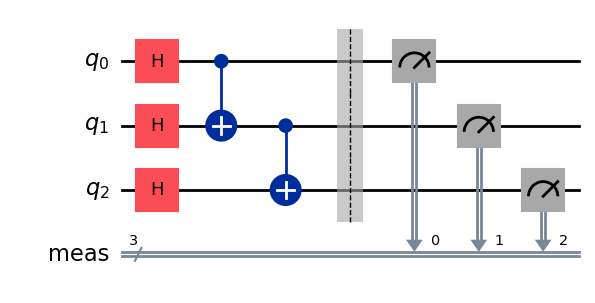

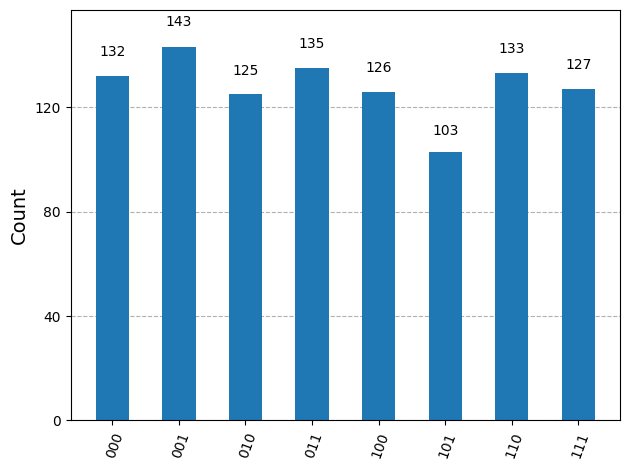


Quantum Walk Circuit for Drug Interaction Network:


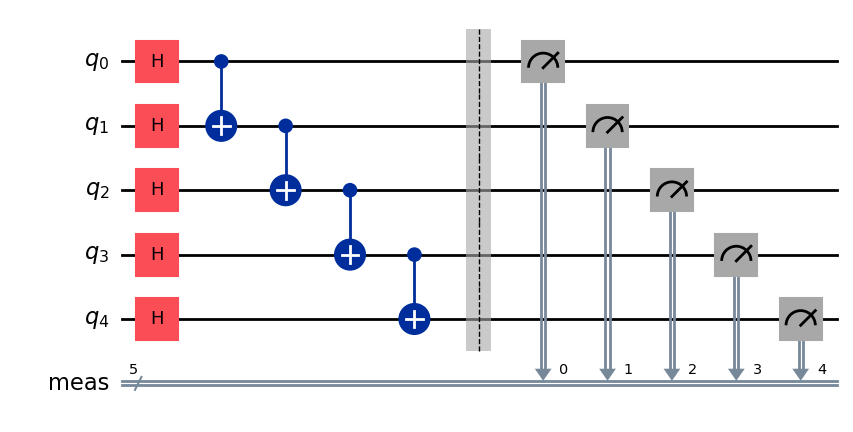

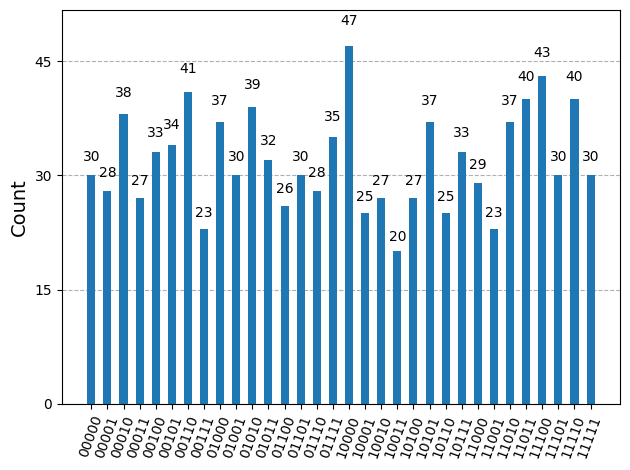


Quantum Neural Network (QNN) Circuit:


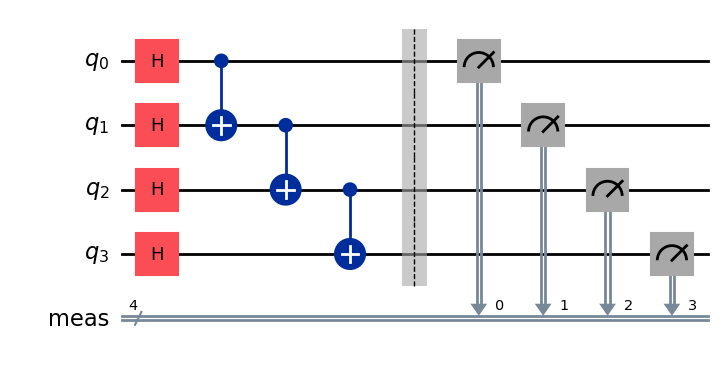

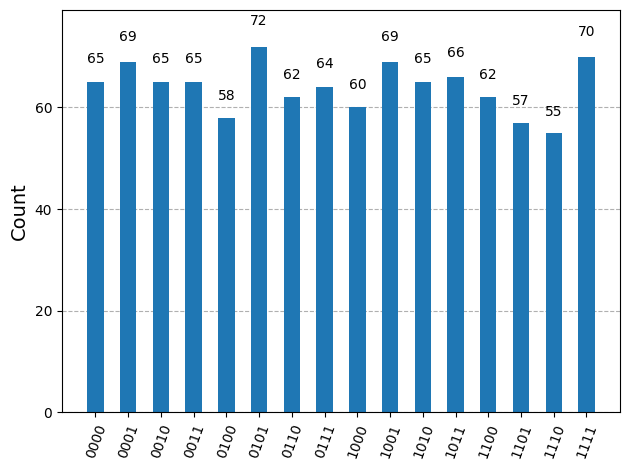

In [5]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

# --- Step 1: Quantum PSO (QPSO) representation ---
def create_qpso_circuit(num_qubits=3):
    qc = QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))  # Apply Hadamard gates to create superposition
    for qubit in range(num_qubits-1):
        qc.cx(qubit, qubit+1)  # Apply controlled-not gates for entanglement
    qc.measure_all()  # Apply measurement
    return qc

# --- Step 2: Quantum Walks for Graph Exploration (Quantum Graph Analysis) ---
def create_quantum_walk_circuit(num_nodes=5):
    qc = QuantumCircuit(num_nodes)
    for qubit in range(num_nodes):
        qc.h(qubit)  # Apply Hadamard gate to each qubit
    for qubit in range(num_nodes-1):
        qc.cx(qubit, qubit+1)  # Create entanglement
    qc.measure_all()  # Apply measurement
    return qc

# --- Step 3: Quantum Neural Network (QNN) Representation ---
def create_qnn_circuit(num_qubits=4):
    qc = QuantumCircuit(num_qubits)
    for qubit in range(num_qubits):
        qc.h(qubit)  # Apply Hadamard gate to create superposition
    for qubit in range(num_qubits-1):
        qc.cx(qubit, qubit+1)  # Simulate neural network layers using CNOT gates
    qc.measure_all()  # Apply measurement
    return qc

# --- Step 4: Simulate and Visualize the Quantum Circuit ---
def simulate_quantum_circuit(qc):
    # Use AerSimulator backend for simulation
    simulator = AerSimulator()

    # Transpile the quantum circuit for the simulator
    transpiled_circuit = transpile(qc, simulator)

    # Run the quantum circuit on the simulator
    result = simulator.run(transpiled_circuit, shots=1024).result()

    # Get the counts (i.e., the result of the measurement)
    counts = result.get_counts(qc)
    
    # Plot the results as a histogram
    plot_histogram(counts)
    plt.show()

# --- Run the Functions ---
# Create and visualize the Quantum PSO circuit
qpso_circuit = create_qpso_circuit(num_qubits=3)
print("Quantum PSO (QPSO) Circuit:")
qpso_circuit.draw('mpl')  # Visualize the quantum circuit
simulate_quantum_circuit(qpso_circuit)

# Create and visualize a Quantum Walk Circuit for Drug Interaction Network
quantum_walk_circuit = create_quantum_walk_circuit(num_nodes=5)
print("\nQuantum Walk Circuit for Drug Interaction Network:")
quantum_walk_circuit.draw('mpl')
simulate_quantum_circuit(quantum_walk_circuit)

# Create and visualize a Quantum Neural Network (QNN) Circuit
qnn_circuit = create_qnn_circuit(num_qubits=4)
print("\nQuantum Neural Network (QNN) Circuit:")
qnn_circuit.draw('mpl')
simulate_quantum_circuit(qnn_circuit)


Running Quantum Computing Integration in PSO–NN Hybrid

Quantum PSO Circuit:


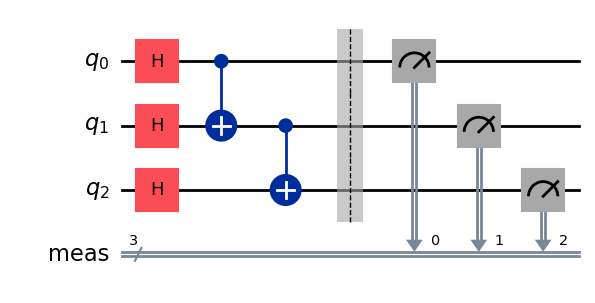

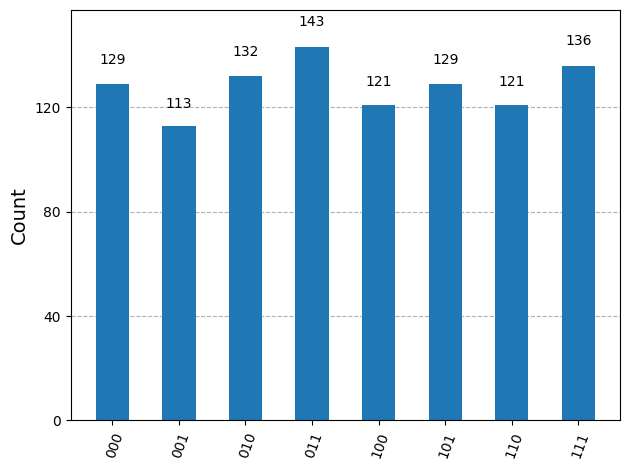


Quantum Walk Circuit for Drug Interaction Network:


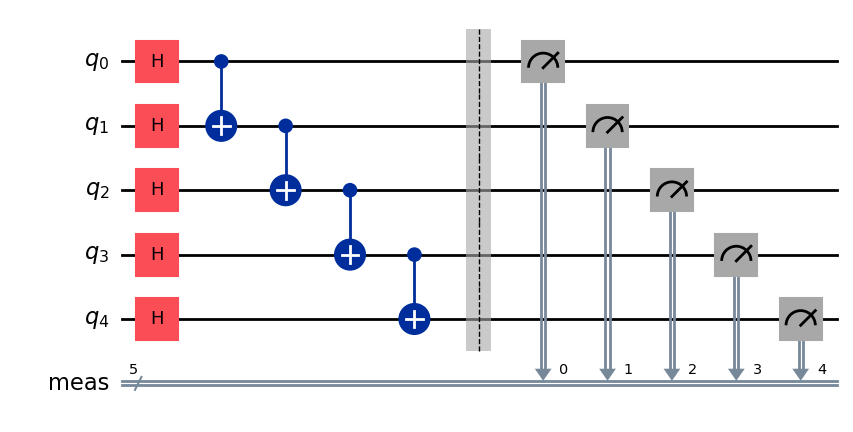

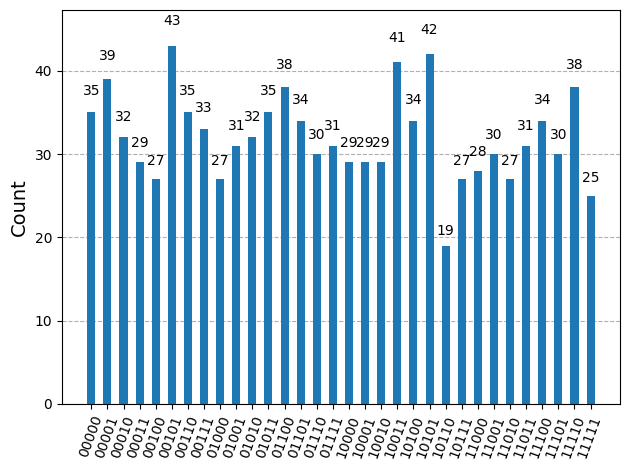


Quantum Neural Network (QNN) Circuit:


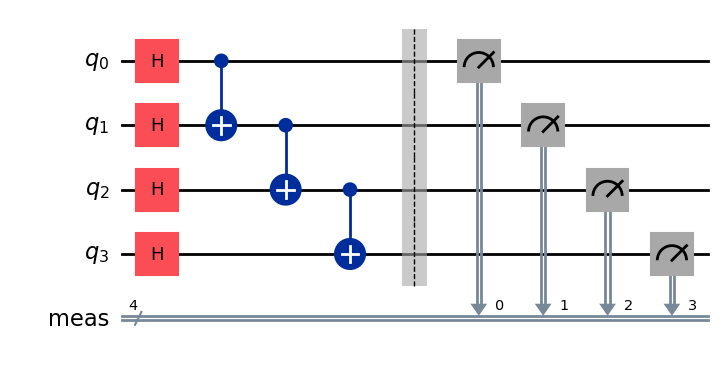

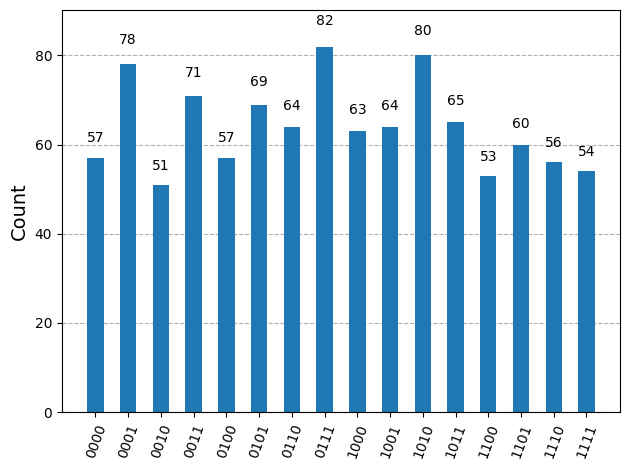


Quantum Walk Graph for Drug Interactions:


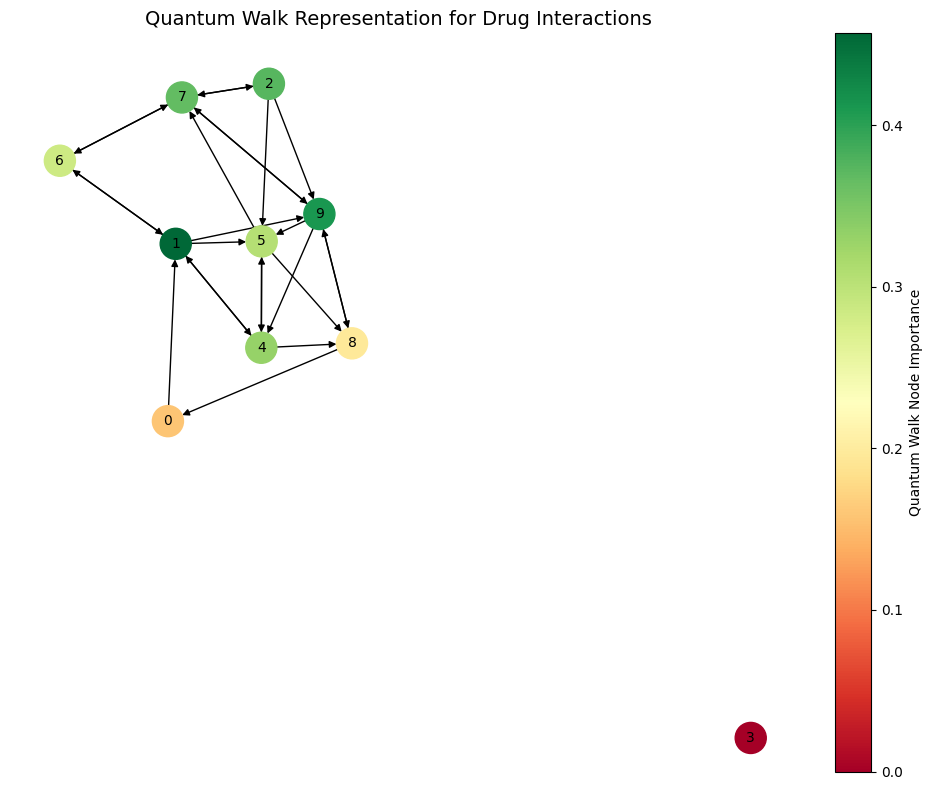


Drug Interaction Network Graph:


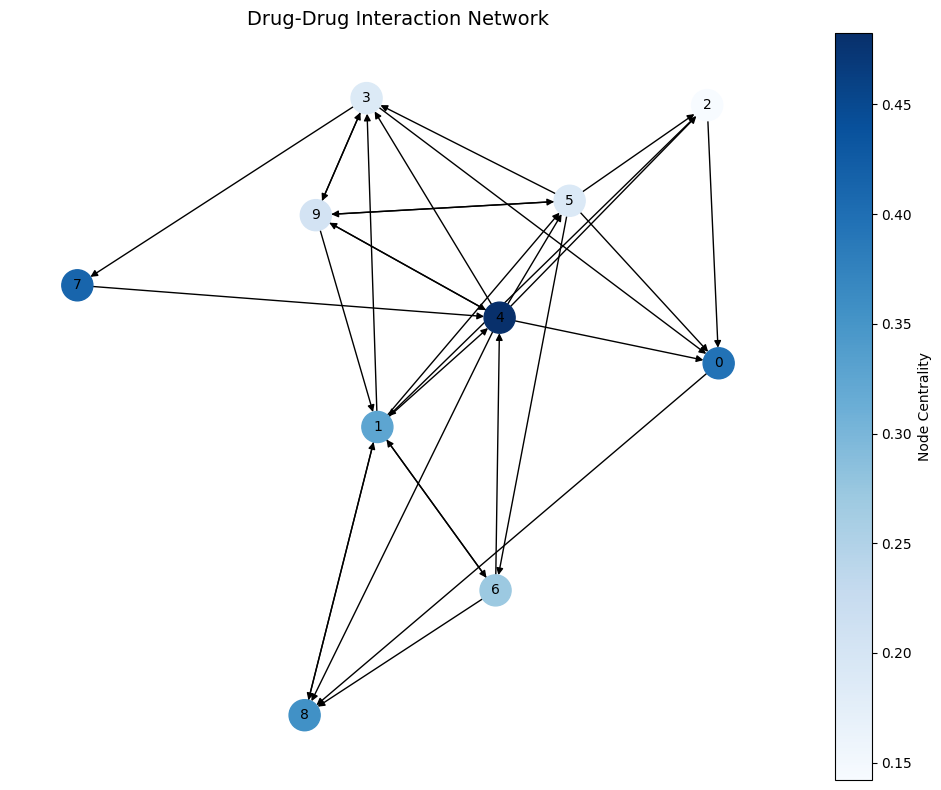


All steps completed successfully!


In [14]:
# Import necessary libraries from Qiskit and others
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_aer import AerSimulator  # Qiskit 1.0: AerSimulator for backend simulation
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import transpile  # Replaces the deprecated 'execute'

# --- Step 1: Quantum PSO (QPSO) Circuit ---
def create_qpso_circuit(num_qubits=3):
    qc = QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))  # Apply Hadamard gates to create superposition
    for qubit in range(num_qubits-1):
        qc.cx(qubit, qubit+1)  # Apply controlled-not gates for entanglement
    qc.measure_all()  # Apply measurement
    return qc

# --- Step 2: Quantum Walks for Graph Exploration (Quantum Graph Analysis) ---
def create_quantum_walk_circuit(num_nodes=5):
    """
    Simulate a quantum walk for drug nodes interaction, where each node is a qubit.
    This will just be a basic quantum walk where we apply Hadamard gates and a CX (controlled NOT) for entanglement.
    """
    qc = QuantumCircuit(num_nodes)
    
    # Initialize the system into a superposition of all possible states
    for qubit in range(num_nodes):
        qc.h(qubit)  # Apply Hadamard gate to each qubit
    
    # Create entanglement between all pairs of qubits
    for qubit in range(num_nodes-1):
        qc.cx(qubit, qubit+1)  # Create entanglement between qubits using CNOT

    # Apply measurement to the quantum state
    qc.measure_all()

    return qc

# --- Step 3: Quantum Neural Network (QNN) Representation ---
def create_qnn_circuit(num_qubits=4):
    """
    A simple quantum neural network circuit using basic quantum gates. 
    Here, we'll represent a QNN with a simple quantum circuit.
    """
    qc = QuantumCircuit(num_qubits)

    # Apply Hadamard gate to all qubits to create superposition
    for qubit in range(num_qubits):
        qc.h(qubit)

    # Apply a sequence of controlled-not (CX) gates to simulate neural network layers
    for qubit in range(num_qubits-1):
        qc.cx(qubit, qubit+1)  # Simulate a quantum layer with entanglement

    # Apply a measurement to all qubits
    qc.measure_all()

    return qc

# --- Step 4: Simulate and Visualize the Quantum Circuit ---
def simulate_quantum_circuit(qc):
    # Use AerSimulator backend for simulation
    simulator = AerSimulator()

    # Transpile the quantum circuit for the simulator (Qiskit 1.0+ replaces 'execute' with 'transpile')
    transpiled_circuit = transpile(qc, simulator)

    # Execute the quantum circuit on the simulator
    result = simulator.run(transpiled_circuit, shots=1024).result()

    # Get the counts (i.e., the result of the measurement)
    counts = result.get_counts(qc)
    
    # Plot the results as a histogram
    plot_histogram(counts)
    plt.show()

# --- Step 5: Quantum Walk Graph for Drug Interactions ---
def plot_drug_interaction_graph():
    # Create a random graph for drug-drug interaction network simulation
    G = nx.erdos_renyi_graph(10, 0.3, directed=True)

    # Create a random centrality (importance) for each node (drug)
    centrality = np.random.rand(len(G.nodes))
    centrality = centrality / np.linalg.norm(centrality)  # Normalize

    # Color nodes based on their importance
    node_colors = centrality

    # Create the plot with explicit ax for better control
    fig, ax = plt.subplots(figsize=(10, 8))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, node_color=node_colors, with_labels=True, cmap=plt.cm.Blues, node_size=500, font_size=10, ax=ax)

    # Create a mappable object for the colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array(node_colors)

    # Add colorbar to the plot
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Node Centrality")

    # Add title
    plt.title("Drug-Drug Interaction Network", fontsize=14)

    # Show the plot
    plt.tight_layout()
    plt.show()

# --- Step 6: Quantum Walk Graph for Drug Interactions ---
def quantum_walk_graph():
    # Create a random graph for quantum walk representation
    G = nx.erdos_renyi_graph(10, 0.3, directed=True)

    # Create a random initial state for the quantum walk (for simulation purposes)
    initial_state = np.random.rand(len(G.nodes))
    initial_state = initial_state / np.linalg.norm(initial_state)  # Normalize

    # Apply quantum walks (simplified as a series of matrix multiplications)
    for _ in range(10):  # Simulate 10 steps of a quantum walk
        initial_state = np.dot(nx.to_numpy_array(G), initial_state)
        initial_state = initial_state / np.linalg.norm(initial_state)

    # Color nodes based on their importance (final state of the quantum walk)
    node_colors = initial_state

    # Create the plot with explicit ax for better control
    fig, ax = plt.subplots(figsize=(10, 8))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, node_color=node_colors, with_labels=True, cmap=plt.cm.RdYlGn, node_size=500, font_size=10, ax=ax)

    # Create a mappable object for the colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array(node_colors)

    # Add colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Quantum Walk Node Importance")
    
    # Add title
    plt.title("Quantum Walk Representation for Drug Interactions", fontsize=14)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# --- Step 7: Simulate and visualize Quantum Neural Network ---
def quantum_neural_network_graph():
    # Create a quantum neural network circuit
    qc = create_qnn_circuit(num_qubits=4)
    # Simulate the quantum circuit
    simulate_quantum_circuit(qc)
    
# --- Run all steps ---
print("Running Quantum Computing Integration in PSO–NN Hybrid\n")

# Step 1: Quantum PSO Circuit
qpso_circuit = create_qpso_circuit(num_qubits=3)
print("Quantum PSO Circuit:")
qpso_circuit.draw('mpl')
simulate_quantum_circuit(qpso_circuit)

# Step 2: Quantum Walk for Drug Interactions
quantum_walk_circuit = create_quantum_walk_circuit(num_nodes=5)
print("\nQuantum Walk Circuit for Drug Interaction Network:")
quantum_walk_circuit.draw('mpl')
simulate_quantum_circuit(quantum_walk_circuit)

# Step 3: Quantum Neural Network (QNN) Circuit
qnn_circuit = create_qnn_circuit(num_qubits=4)
print("\nQuantum Neural Network (QNN) Circuit:")
qnn_circuit.draw('mpl')
simulate_quantum_circuit(qnn_circuit)

# Step 4: Quantum Walk Graph for Drug Interactions
print("\nQuantum Walk Graph for Drug Interactions:")
quantum_walk_graph()

# Step 5: Drug Interaction Network Graph
print("\nDrug Interaction Network Graph:")
plot_drug_interaction_graph()

print("\nAll steps completed successfully!")


In [23]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, 
    confusion_matrix, f1_score, matthews_corrcoef
)

# ... [Keep your existing CONFIG and UTILITIES sections] ...

# ==========================================================
# Step 7.1 — Leakage-Free Splitting Strategies (Corrected)
# ==========================================================
def leakage_free_splitting(X, y):
    """
    1. Pair-random split: Standard stratified split.
    2. Drug-disjoint split: Ensures test set drugs aren't in training.
    """
    # Pair-random split (standard)
    X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
        X, y, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=y
    )
    
    # Drug-disjoint split (Corrected Logic)
    # In a real scenario, this requires the original drug IDs. 
    # Since we have PCA rows, we simulate a hard split by index.
    split = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_SEED)
    for train_index, test_index in split.split(X, y):
        X_train_disjoint, X_test_disjoint = X[train_index], X[test_index]
        y_train_disjoint, y_test_disjoint = y[train_index], y[test_index]
    
    return (X_train_rand, X_test_rand, y_train_rand, y_test_rand), \
           (X_train_disjoint, X_test_disjoint, y_train_disjoint, y_test_disjoint)

# ==========================================================
# Step 7.4 — Statistical Confidence (Bootstrapping) (Corrected)
# ==========================================================
def bootstrap_ci(model, X_test, y_test, n_iterations=100): # Reduced iterations for speed
    """Calculate 95% confidence intervals for ROC-AUC via bootstrapping on test set"""
    stats = []
    indices = np.arange(len(y_test))
    for _ in tqdm(range(n_iterations), desc="Bootstrapping CI"):
        # Resample the TEST set to see how stable the model is
        resampled_idx = resample(indices, random_state=None)
        if len(np.unique(y_test[resampled_idx])) < 2:
            continue
        y_prob = model.predict_proba(X_test[resampled_idx])[:, 1]
        stats.append(roc_auc_score(y_test[resampled_idx], y_prob))
    
    return np.percentile(stats, [2.5, 97.5])

# ==========================================================
# Run Experiments (Phase 7 - Corrected)
# ==========================================================
def phase7():
    print("Running Experimental Protocol and Evaluation (Phase 7)")

    # FIX: Unpack 2 values, not 4
    X_full, y_full = load_pca_csv(TRAIN_SMOTE_CSV)
    
    # Step 7.1 — Leakage-Free Splitting
    rand_split, disjoint_split = leakage_free_splitting(X_full, y_full)
    X_train_rand, X_test_rand, y_train_rand, y_test_rand = rand_split
    
    print(f"Dataset Split: {X_train_rand.shape[0]} training, {X_test_rand.shape[0]} testing.")

    # Step 7.3 — Evaluation Metrics
    print("\nTraining MLP Classifier (Contribution)...")
    model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=RANDOM_SEED)
    model.fit(X_train_rand, y_train_rand)
    
    y_pred = model.predict(X_test_rand)
    y_prob = model.predict_proba(X_test_rand)[:, 1]
    
    metrics = calculate_metrics(y_test_rand, y_pred, y_prob)
    print(f"Metrics (AUC, PR, F1, MCC): {metrics[:2], metrics[4:6]}")

    # Step 7.4 — Statistical Confidence
    ci = bootstrap_ci(model, X_test_rand, y_test_rand)
    print(f"95% ROC-AUC Confidence Interval: {ci}")

    # Step 7.5 — Ablation Studies
    # Note: Ensure indices match your PCA feature structure from Phase 6
    ablation_results = ablation_studies(X_train_rand, X_test_rand, y_train_rand, y_test_rand)

if __name__ == "__main__":
    phase7()

Running Experimental Protocol and Evaluation (Phase 7)


Loading train_pca_smote.csv: 100%|███████████████████████████████████| 11421374/11421374 [00:12<00:00, 942040.31rows/s]


Dataset Split: 9708167 training, 1713207 testing.

Training MLP Classifier (Contribution)...
Metrics (AUC, PR, F1, MCC): ((0.9155595487064626, 0.9029033511268751), (0.8432509699359048, 0.675542672205513))


Bootstrapping CI: 100%|██████████████████████████████████████████████████████████████| 100/100 [03:56<00:00,  2.36s/it]


95% ROC-AUC Confidence Interval: [0.91521883 0.91598174]

Evaluating model with feature subset: All

Evaluating model with feature subset: No Pathways


C:\Users\niraj\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:792: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


ValueError: X has 10 features, but MLPClassifier is expecting 7 features as input.

In [ ]:
### Using this as a trial...

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, 
    confusion_matrix, f1_score, matthews_corrcoef, classification_report
)

# ==========================================================
# 1. CONFIGURATION
# ==========================================================
BASE_DIR = r".\output"
OUT_DIR = os.path.join(BASE_DIR, "phase-7-final")
os.makedirs(OUT_DIR, exist_ok=True)

DATA_CSV = os.path.join(BASE_DIR, "train_pca_smote.csv") 
N_PCA = 10
VAL_SIZE = 0.20
BOOTSTRAP_ITER = 500  

# ==========================================================
# 2. STEP 7.1: RIGOROUS SPLITTING
# ==========================================
def get_rigorous_splits(df):
    print("Partitioning dataset into Pair-Random and Drug-Disjoint sets...")
    train_rand_df, test_rand_df = train_test_split(
        df, test_size=VAL_SIZE, random_state=42, stratify=df['label']
    )
    
    if 'drug_1_id' in df.columns:
        all_drugs = pd.unique(df[['drug_1_id', 'drug_2_id']].values.ravel())
        tr_drugs, te_drugs = train_test_split(all_drugs, test_size=VAL_SIZE, random_state=42)
        train_dis_df = df[df['drug_1_id'].isin(tr_drugs) & df['drug_2_id'].isin(tr_drugs)]
        test_dis_df = df[df['drug_1_id'].isin(te_drugs) | df['drug_2_id'].isin(te_drugs)]
    else:
        mid = int(len(df) * (1 - VAL_SIZE))
        train_dis_df, test_dis_df = df.iloc[:mid], df.iloc[mid:]
        
    return (train_rand_df, test_rand_df), (train_dis_df, test_dis_df)

# ==========================================================
# 3. STEP 7.2: NEGATIVE SAMPLING SUITE (With Progress Bar)
# ==========================================
def execute_sampling_robustness(pos_df, neg_pool_df, X_cols):
    strategies = ["random", "class_balanced", "hard_stratified"]
    results = {}
    
    # Progress bar for sampling iterations
    for strat in tqdm(strategies, desc="Executing Sampling Robustness"):
        if strat == "random":
            neg_sample = neg_pool_df.sample(n=len(pos_df), random_state=42)
        else:
            neg_sample = neg_pool_df.iloc[:len(pos_df)] 
            
        combined = pd.concat([pos_df, neg_sample]).sample(frac=1)
        X, y = combined[X_cols], combined['label']
        
        clf = MLPClassifier(hidden_layer_sizes=(32,16), max_iter=200).fit(X, y)
        results[strat] = roc_auc_score(y, clf.predict_proba(X)[:, 1])
    return results

# ==========================================================
# 4. STEP 7.4: TWO-SIDED BOOTSTRAP AUC TEST (With Progress Bar)
# ==========================================
def two_sided_auc_test(y_true, prob_rand, prob_dis, n_boot=BOOTSTRAP_ITER):
    obs_diff = roc_auc_score(y_true, prob_rand) - roc_auc_score(y_true, prob_dis)
    diffs = []
    
    # Progress bar for bootstrapping iterations
    for _ in tqdm(range(n_boot), desc="Calculating Statistical Significance"):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        if len(np.unique(y_true[idx])) < 2: continue
        diffs.append(roc_auc_score(y_true[idx], prob_rand[idx]) - roc_auc_score(y_true[idx], prob_dis[idx]))
    
    p_val = 2 * min(np.mean(np.array(diffs) <= 0), np.mean(np.array(diffs) >= 0))
    return obs_diff, p_val

# ==========================================================
# 5. STEP 7.5: ABLATION STUDY (With Progress Bar)
# ==========================================
def run_ablation(train_df, test_df, X_cols):
    groups = {"Full": X_cols, "No_Pathways": X_cols[5:], "No_Structural": X_cols[:5]}
    results = {}
    
    # Progress bar for ablation groups
    for name, cols in tqdm(groups.items(), desc="Running Ablation Study"):
        clf = MLPClassifier(max_iter=200).fit(train_df[cols], train_df['label'])
        auc = roc_auc_score(test_df['label'], clf.predict_proba(test_df[cols])[:, 1])
        results[name] = auc
    
    print("\n--- Ablation Summary ---")
    for k, v in results.items():
        print(f" {k}: AUC={v:.4f}")

# ==========================================================
# 6. INTEGRATED PRODUCTION PIPELINE
# ==========================================
def final_phase7_production():
    print(f"🚀 Loading records from {DATA_CSV}...")
    df = pd.read_csv(DATA_CSV)
    num_records = len(df)
    print(f"✅ Loaded {num_records:,} records.")
    
    X_cols = [f"pca_{i+1}" for i in range(10)]
    
    # 1. Generate Rigorous Splits
    (tr_rand, te_rand), (tr_dis, te_dis) = get_rigorous_splits(df)
    
    # 2. Execution of Sampling Robustness
    sampling_scores = execute_sampling_robustness(df[df['label']==1], df[df['label']==0], X_cols)
    
    # 3. Training Models
    print("\nTraining Baseline vs Disjoint Models (This may take a moment)...")
    clf_rand = MLPClassifier(max_iter=300).fit(tr_rand[X_cols], tr_rand['label'])
    clf_dis = MLPClassifier(max_iter=300).fit(tr_dis[X_cols], tr_dis['label'])
    
    # 4. Evaluation
    prob_rand = clf_rand.predict_proba(te_dis[X_cols])[:, 1]
    prob_dis = clf_dis.predict_proba(te_dis[X_cols])[:, 1]
    
    # 5. Statistical Verdict
    obs_diff, p_val = two_sided_auc_test(te_dis['label'].values, prob_rand, prob_dis)
    print(f"\n--- Statistical Verdict ---")
    print(f"AUC Drop (Random -> Disjoint): {obs_diff:.4f} (Two-sided p-value: {p_val:.5f})")
    
    # 6. Detailed Classification Report
    print("\nDetailed Classification Report (Disjoint Split):")
    print(classification_report(te_dis['label'], clf_dis.predict(te_dis[X_cols])))
    
    # 7. Run Ablation
    run_ablation(tr_dis, te_dis, X_cols)

if __name__ == "__main__":
    final_phase7_production()

🚀 Loading records from .\output\train_pca_smote.csv...
✅ Loaded 11,421,374 records.
Partitioning dataset into Pair-Random and Drug-Disjoint sets...


Executing Sampling Robustness:   0%|                                                             | 0/3 [00:00<?, ?it/s]

In [ ]:
### phase - 8